# Exercise for Chapter 2 (Solutions)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import warnings

from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA


from arch import arch_model

from scipy.stats import ttest_1samp

In [2]:
pd.options.display.max_columns = None
pd.options.display.width=None
sns.set(style="darkgrid")
register_matplotlib_converters()
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

### Exercise 1

Consider the exchange rate daily data from December 4, 2006 to November 5, 2010 (Rupee versus Dollar, Pound and Euro), in file exchange_rates_1.csv.
1. Compute the sample average, standard deviation and the first order autocorrelation of daily returns over the entire sample period.
Test if the mean and the first order autocorrelation are significantly different from zero using the tests proposed in Section 2.6.

2. Plot histograms of the returns over the entire sample period; Does the distribution look normal? Test it through Jarque-Bera test in (2.37).

3. Aggregate the data at the weekly level. Repeat (1) and (2) on the aggregated data. Compare the result with the result for the daily level.


#### Part 1

Let's load the data look at a few rows and then plot to see what the data looks like.

In [3]:
fx_prices = pd.read_csv('../datasets/exchange_rates_1.csv',index_col='Date',parse_dates=['Date'])
fx_prices.columns = ['USDINR','GBPINR','EURINR']
fx_prices.round(2).head()

USDINR  GBPINR  EURINR
Date                              
2006-12-04   44.59   88.24   59.40
2006-12-05   45.10   89.27   60.17
2006-12-06   44.69   87.95   59.38
2006-12-07   44.66   87.94   59.44
2006-12-08   44.66   87.60   59.34

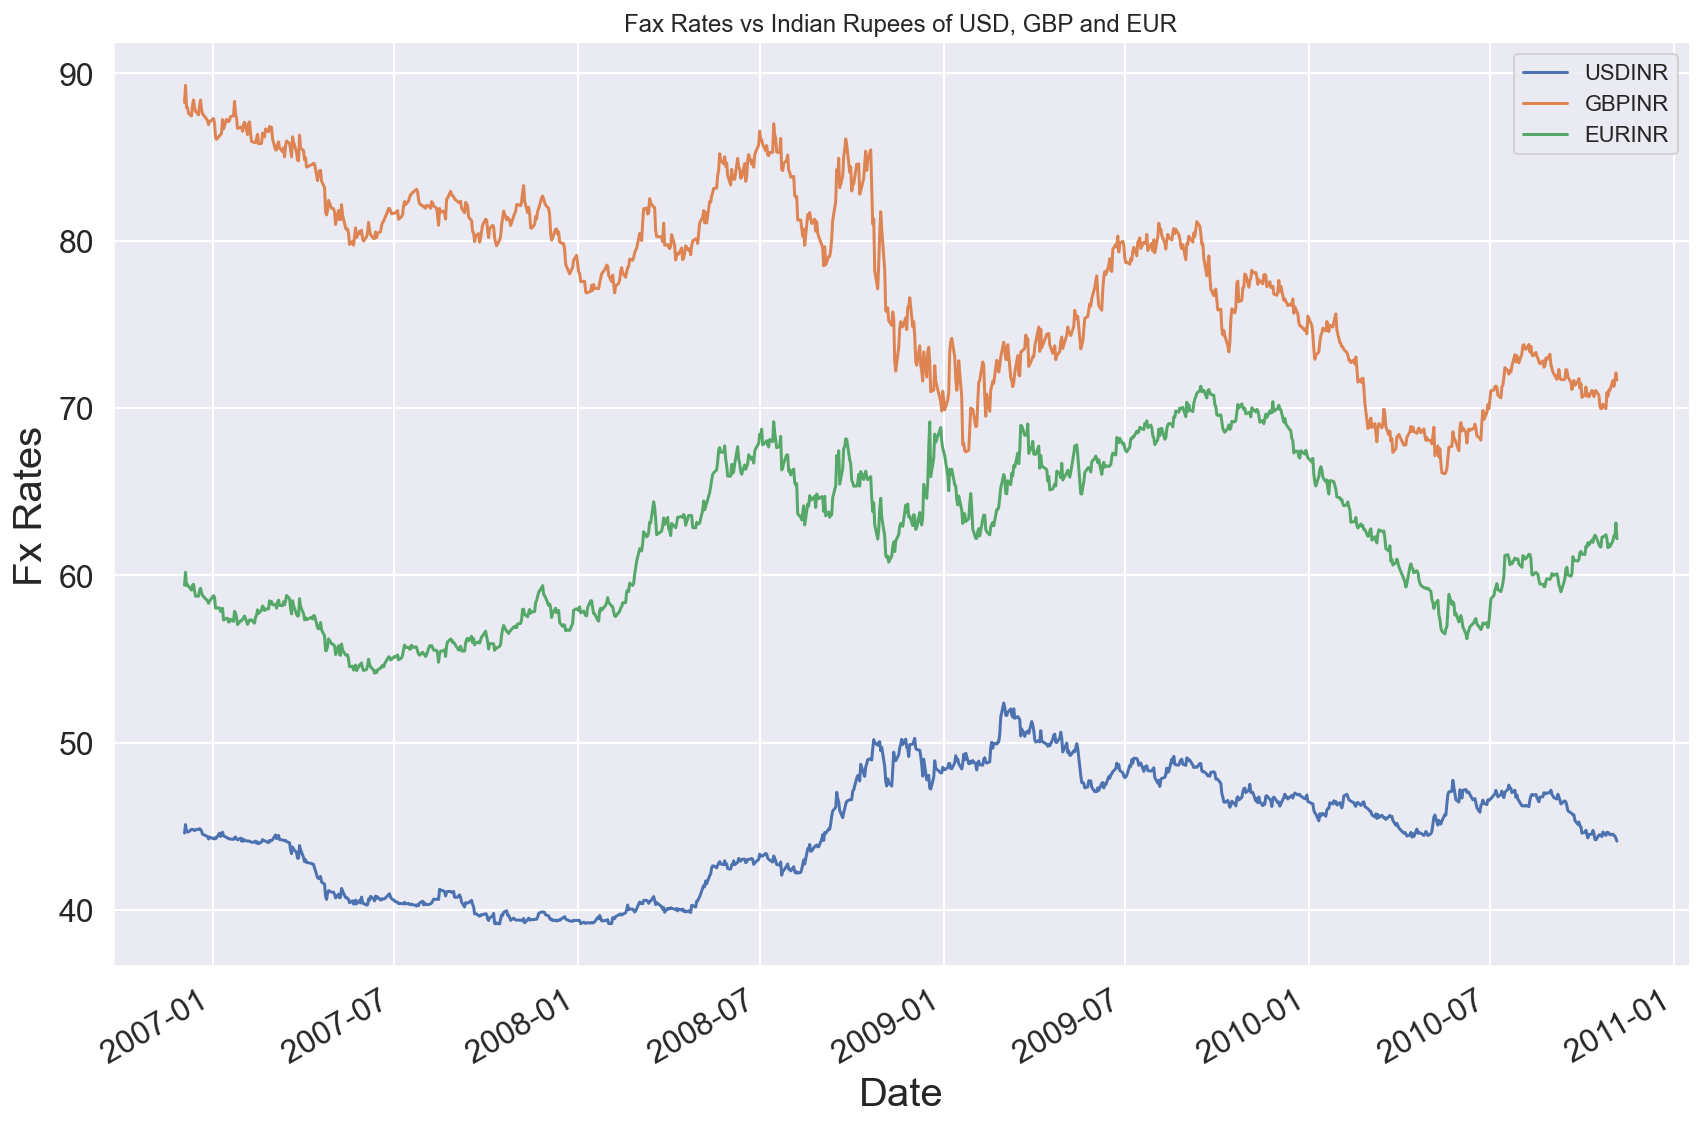

In [4]:
fig,ax = plt.subplots(figsize=(12,8))
_ = fx_prices.plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates vs Indian Rupees of USD, GBP and EUR')
sns.despine()
plt.tight_layout()
plt.show()

Let's generate the returns and have a quick look

In [5]:
fx_returns = fx_prices.pct_change().dropna().round(4)
fx_returns.round(4).head()

USDINR  GBPINR  EURINR
Date                              
2006-12-05  0.0114  0.0117  0.0130
2006-12-06 -0.0089 -0.0148 -0.0132
2006-12-07 -0.0008 -0.0001  0.0009
2006-12-08 -0.0000 -0.0038 -0.0016
2006-12-11  0.0036 -0.0019 -0.0039

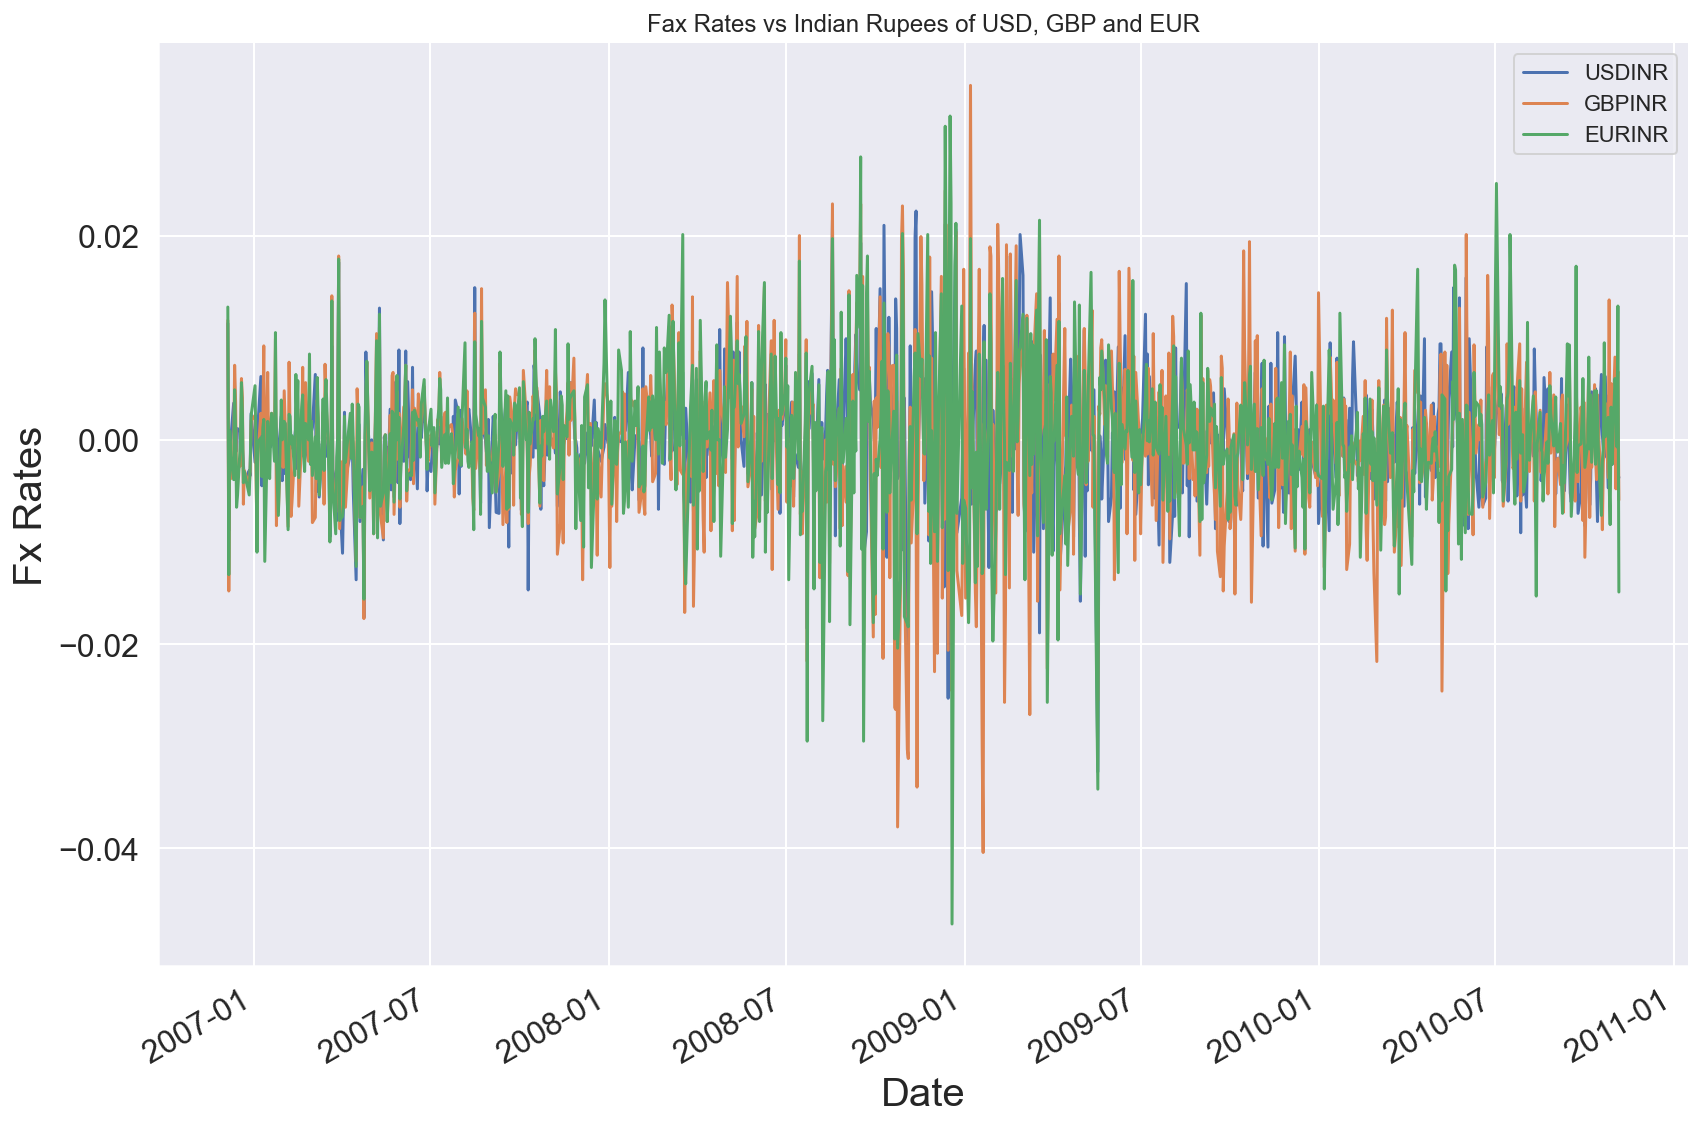

In [6]:
fig,ax = plt.subplots(figsize=(12,8))
_ = fx_returns.plot(ax = ax)
_ = plt.ylabel('Fx Rates')
_ = plt.title('Fax Rates vs Indian Rupees of USD, GBP and EUR')
sns.despine()
plt.tight_layout()
plt.show()

Let's review the main statistics of the returns:

In [7]:
stats = pd.concat({'mean':fx_returns.mean(axis=0),'std':fx_returns.std(axis=0),'autocorr':fx_returns.apply(lambda s: s.autocorr(lag=1))},axis=1)
stats

mean       std  autocorr
USDINR  0.000006  0.005638 -0.047870
GBPINR -0.000174  0.008085 -0.016840
EURINR  0.000074  0.007261 -0.053214

To test the hypohtesis that the means are zero let's first do a one sample t-test analysis:

In [8]:
ttest_tstats, ttest_pv = ttest_1samp(fx_returns,0)
print(f'p-values for one sample t-test:\n{ttest_pv}')

p-values for one sample t-test:
[0.97496084 0.49723581 0.74677083]


All three p-values are greater than zero, so we don’t have enough evidence to reject the null hypothesis that
mean equals zero.

We then look at 1 lag autocorrelation using the Ljung-Box test for autocorrelation of residuals:

In [9]:
lbox_pvalues = [acorr_ljungbox(fx_returns.loc[:,curr],lags=1)[1][0] for curr in fx_returns.columns]
print(f'p-values for one LJung-Box test:\n{lbox_pvalues}')

p-values for one LJung-Box test:
[0.1301733426993926, 0.5940867526678513, 0.09295756910584677]


All three p-values are greater than zero, so we don’t have enough evidence to reject the null hypothesis that the ACF of lag 1 equals zero

#### Part 2

Let's plot the histograms of returns:

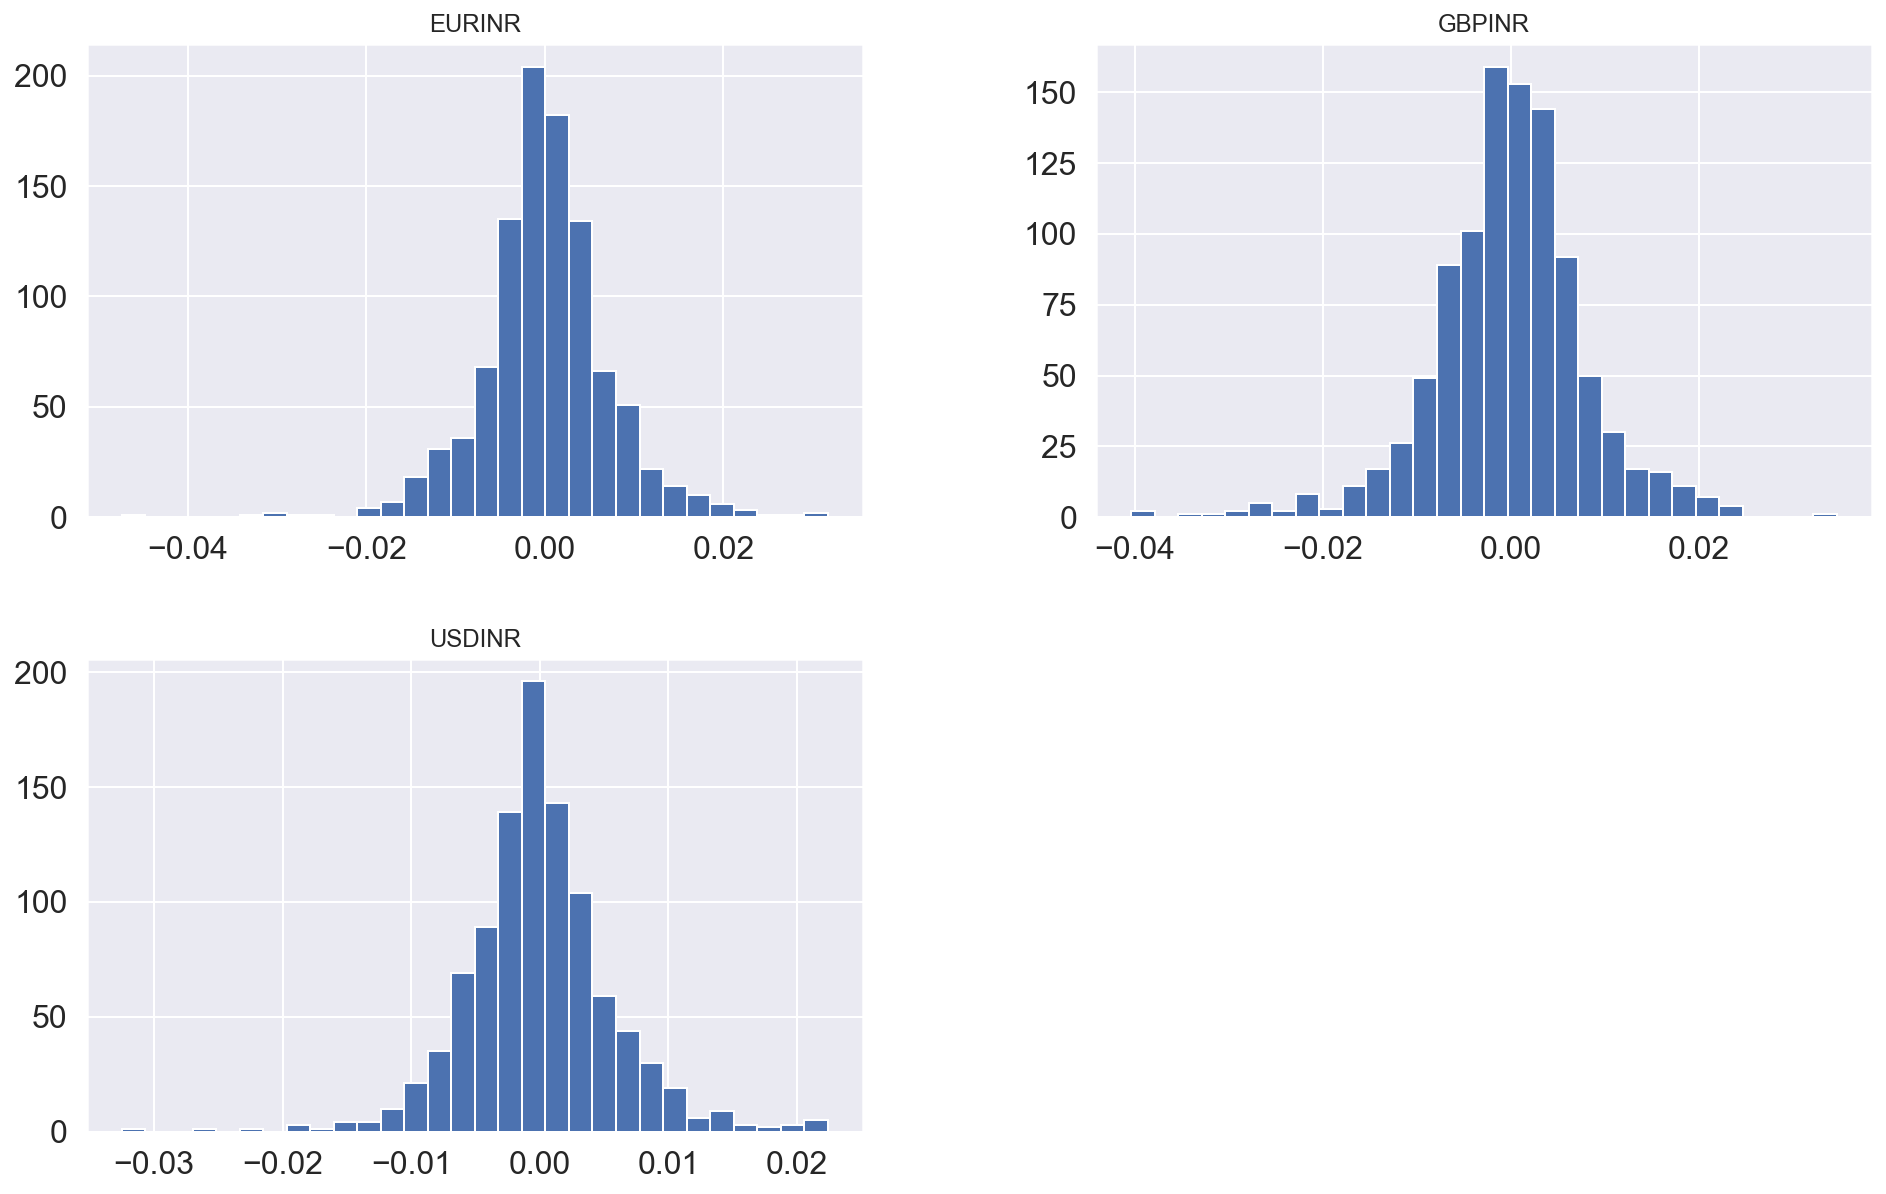

In [10]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
_ = fx_returns.hist(bins=30,ax=ax.reshape(4)[0:3])
_ = ax[1,1].set_visible(False)
plt.show()

The returns do not look particularly normal. Notice the higher than normal kurtosis and skew. We use the Jarque-Bera for goodness of fit

In [11]:
jb_test_pv = jarque_bera(fx_returns)[1]
print(f'p-values for jarque_bera Test:\n{jb_test_pv}')

p-values for jarque_bera Test:
[5.38927612e-085 1.84647412e-066 3.76467431e-140]


The p-values are essentially 0 thus we need to reject the hypothesis that the returns are normal

#### Part 3

Let's resample the data to create a weekly dataset and re-run all out analysis.

In [12]:
fx_weekly_prices = fx_prices.resample('W').first()
fx_weekly_returns = fx_weekly_prices.apply(lambda s: np.log(s) - np.log(s).shift(1),axis=0).dropna()

In [13]:
weekly_stats = pd.concat({'mean':fx_weekly_returns.mean(axis=0),'std':fx_weekly_returns.std(axis=0),'autocorr':fx_weekly_returns.apply(lambda s: s.autocorr(lag=1))},axis=1)
weekly_stats

mean       std  autocorr
USDINR -0.000007  0.011966  0.115449
GBPINR -0.001022  0.016916 -0.123775
EURINR  0.000215  0.014977 -0.059014

In [14]:
ttest_tstats, ttest_pv = ttest_1samp(fx_weekly_returns,0)
print(f'p-values for one sample t-test:\n{ttest_pv}')

p-values for one sample t-test:
[0.99326437 0.38909941 0.83770731]


In [15]:
lbox_pvalues = [acorr_ljungbox(fx_weekly_returns.loc[:,curr],lags=1)[1][0] for curr in fx_returns.columns]
print(f'p-values for one LJung-Box test:\n{lbox_pvalues}')

p-values for one LJung-Box test:
[0.09685847108112841, 0.07660584576684498, 0.39617349788492895]


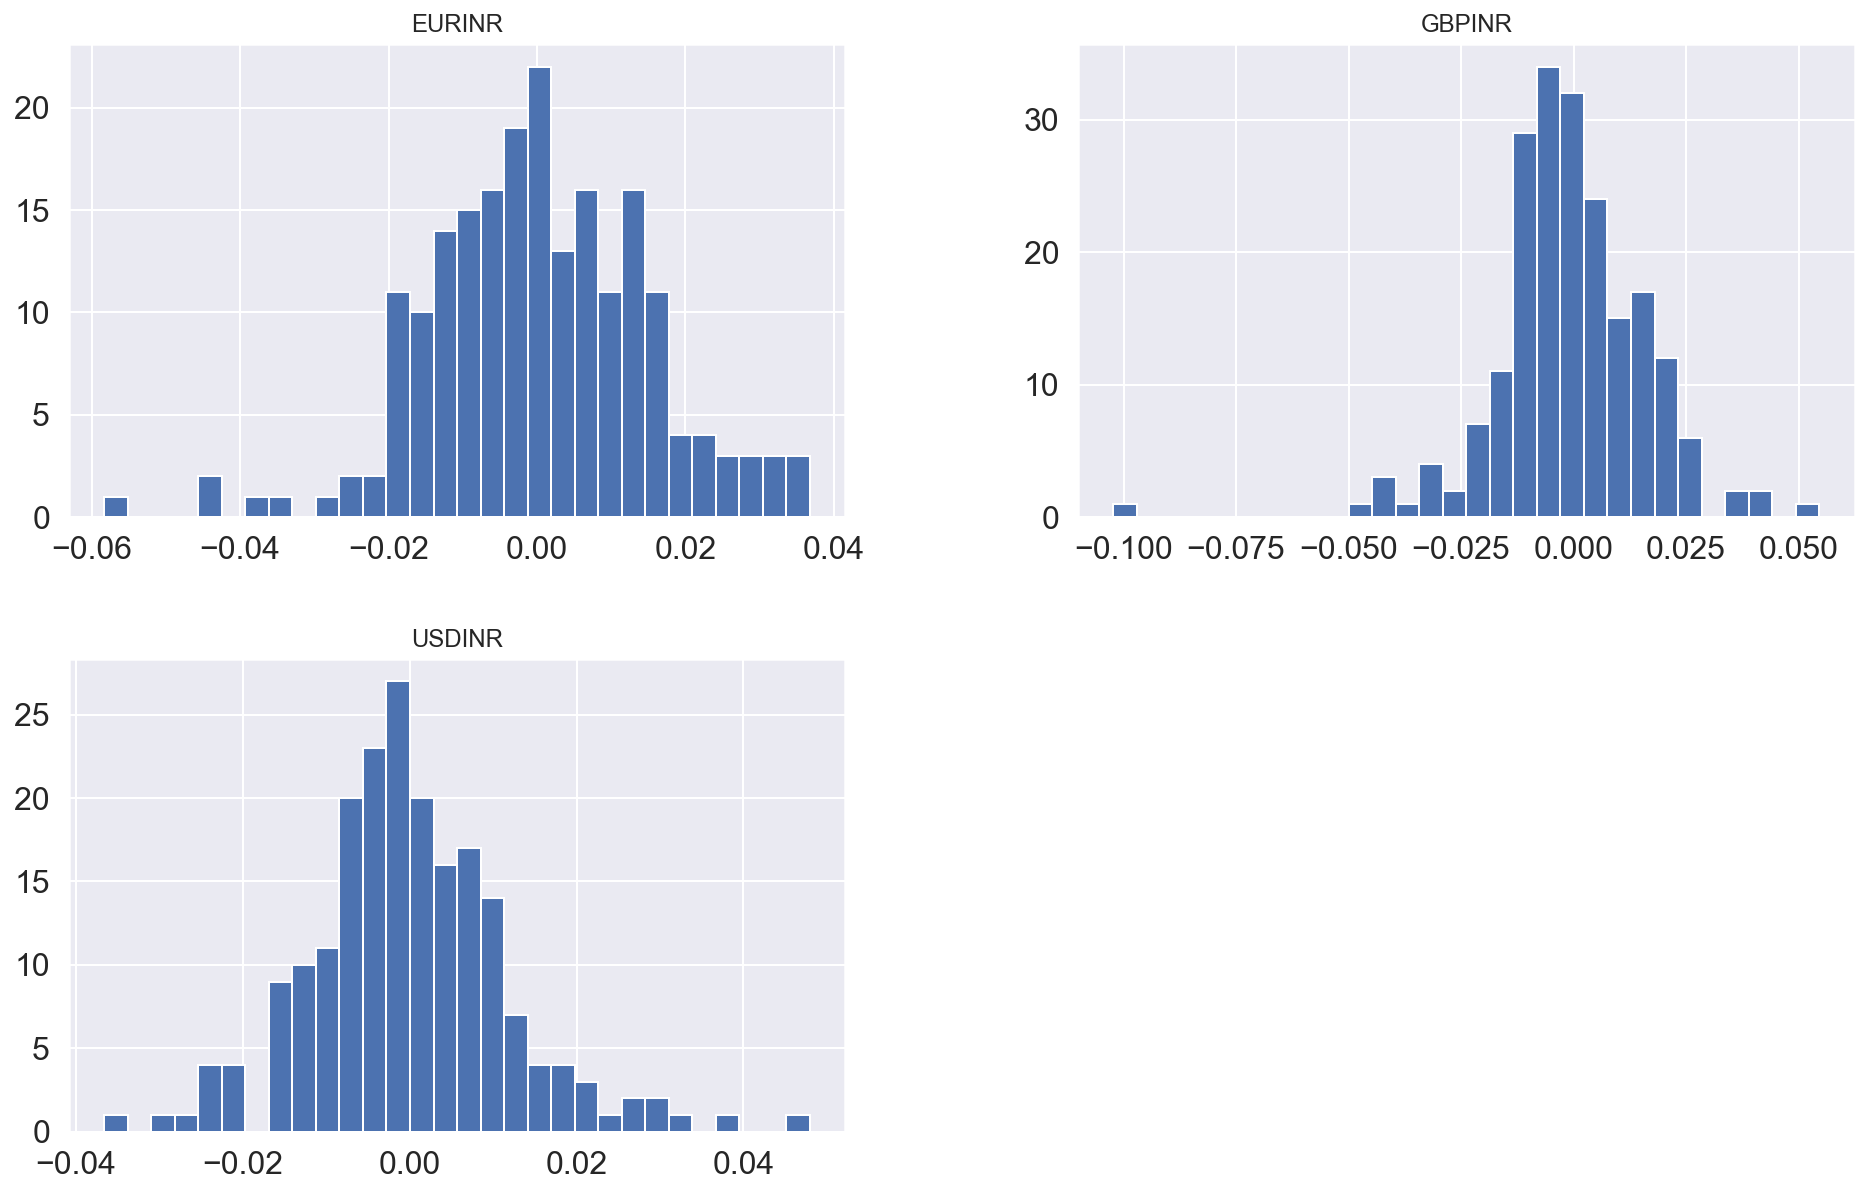

In [16]:
fig,ax = plt.subplots(2,2,figsize=(16,10))
_ = fx_weekly_returns.hist(bins=30, ax=ax.reshape(4)[0:3])
_ = ax[1,1].set_visible(False)
plt.show()

In [17]:
jb_test_pv = jarque_bera(fx_weekly_returns)[1]
print(f'p-values for jarque_bera Test:\n{jb_test_pv}')

p-values for jarque_bera Test:
[2.34731094e-07 2.35545812e-77 4.07331729e-03]


The analysis confirms that the results still hold if we look at weekly data:

- Cannot reject mean different than 0
- Cannot reject that there is no autocorrelation on lag 1
- Must reject that the sample is normally distributed

### Exercise 2

For the returns of all three time series in Problem 1, construct...
1. ARMA models for the returns. Identify the model structure via ACF and PACF.
2. GARCH models for the squared returns; compare the model coefficients for the three series. Comment on the difference, if any.
3. Is there a co-movement among the three exchange-rate series? To make the plots on a comparable scale, convert the starting points of the series unity. Does the
co-movement vary over different time regimes? (Back up your claim with solid analysis.) Identify the transition states and speculate how you can exploit this for
trading decisions.

#### Part 1 ARMA Modeling

##### USDINR

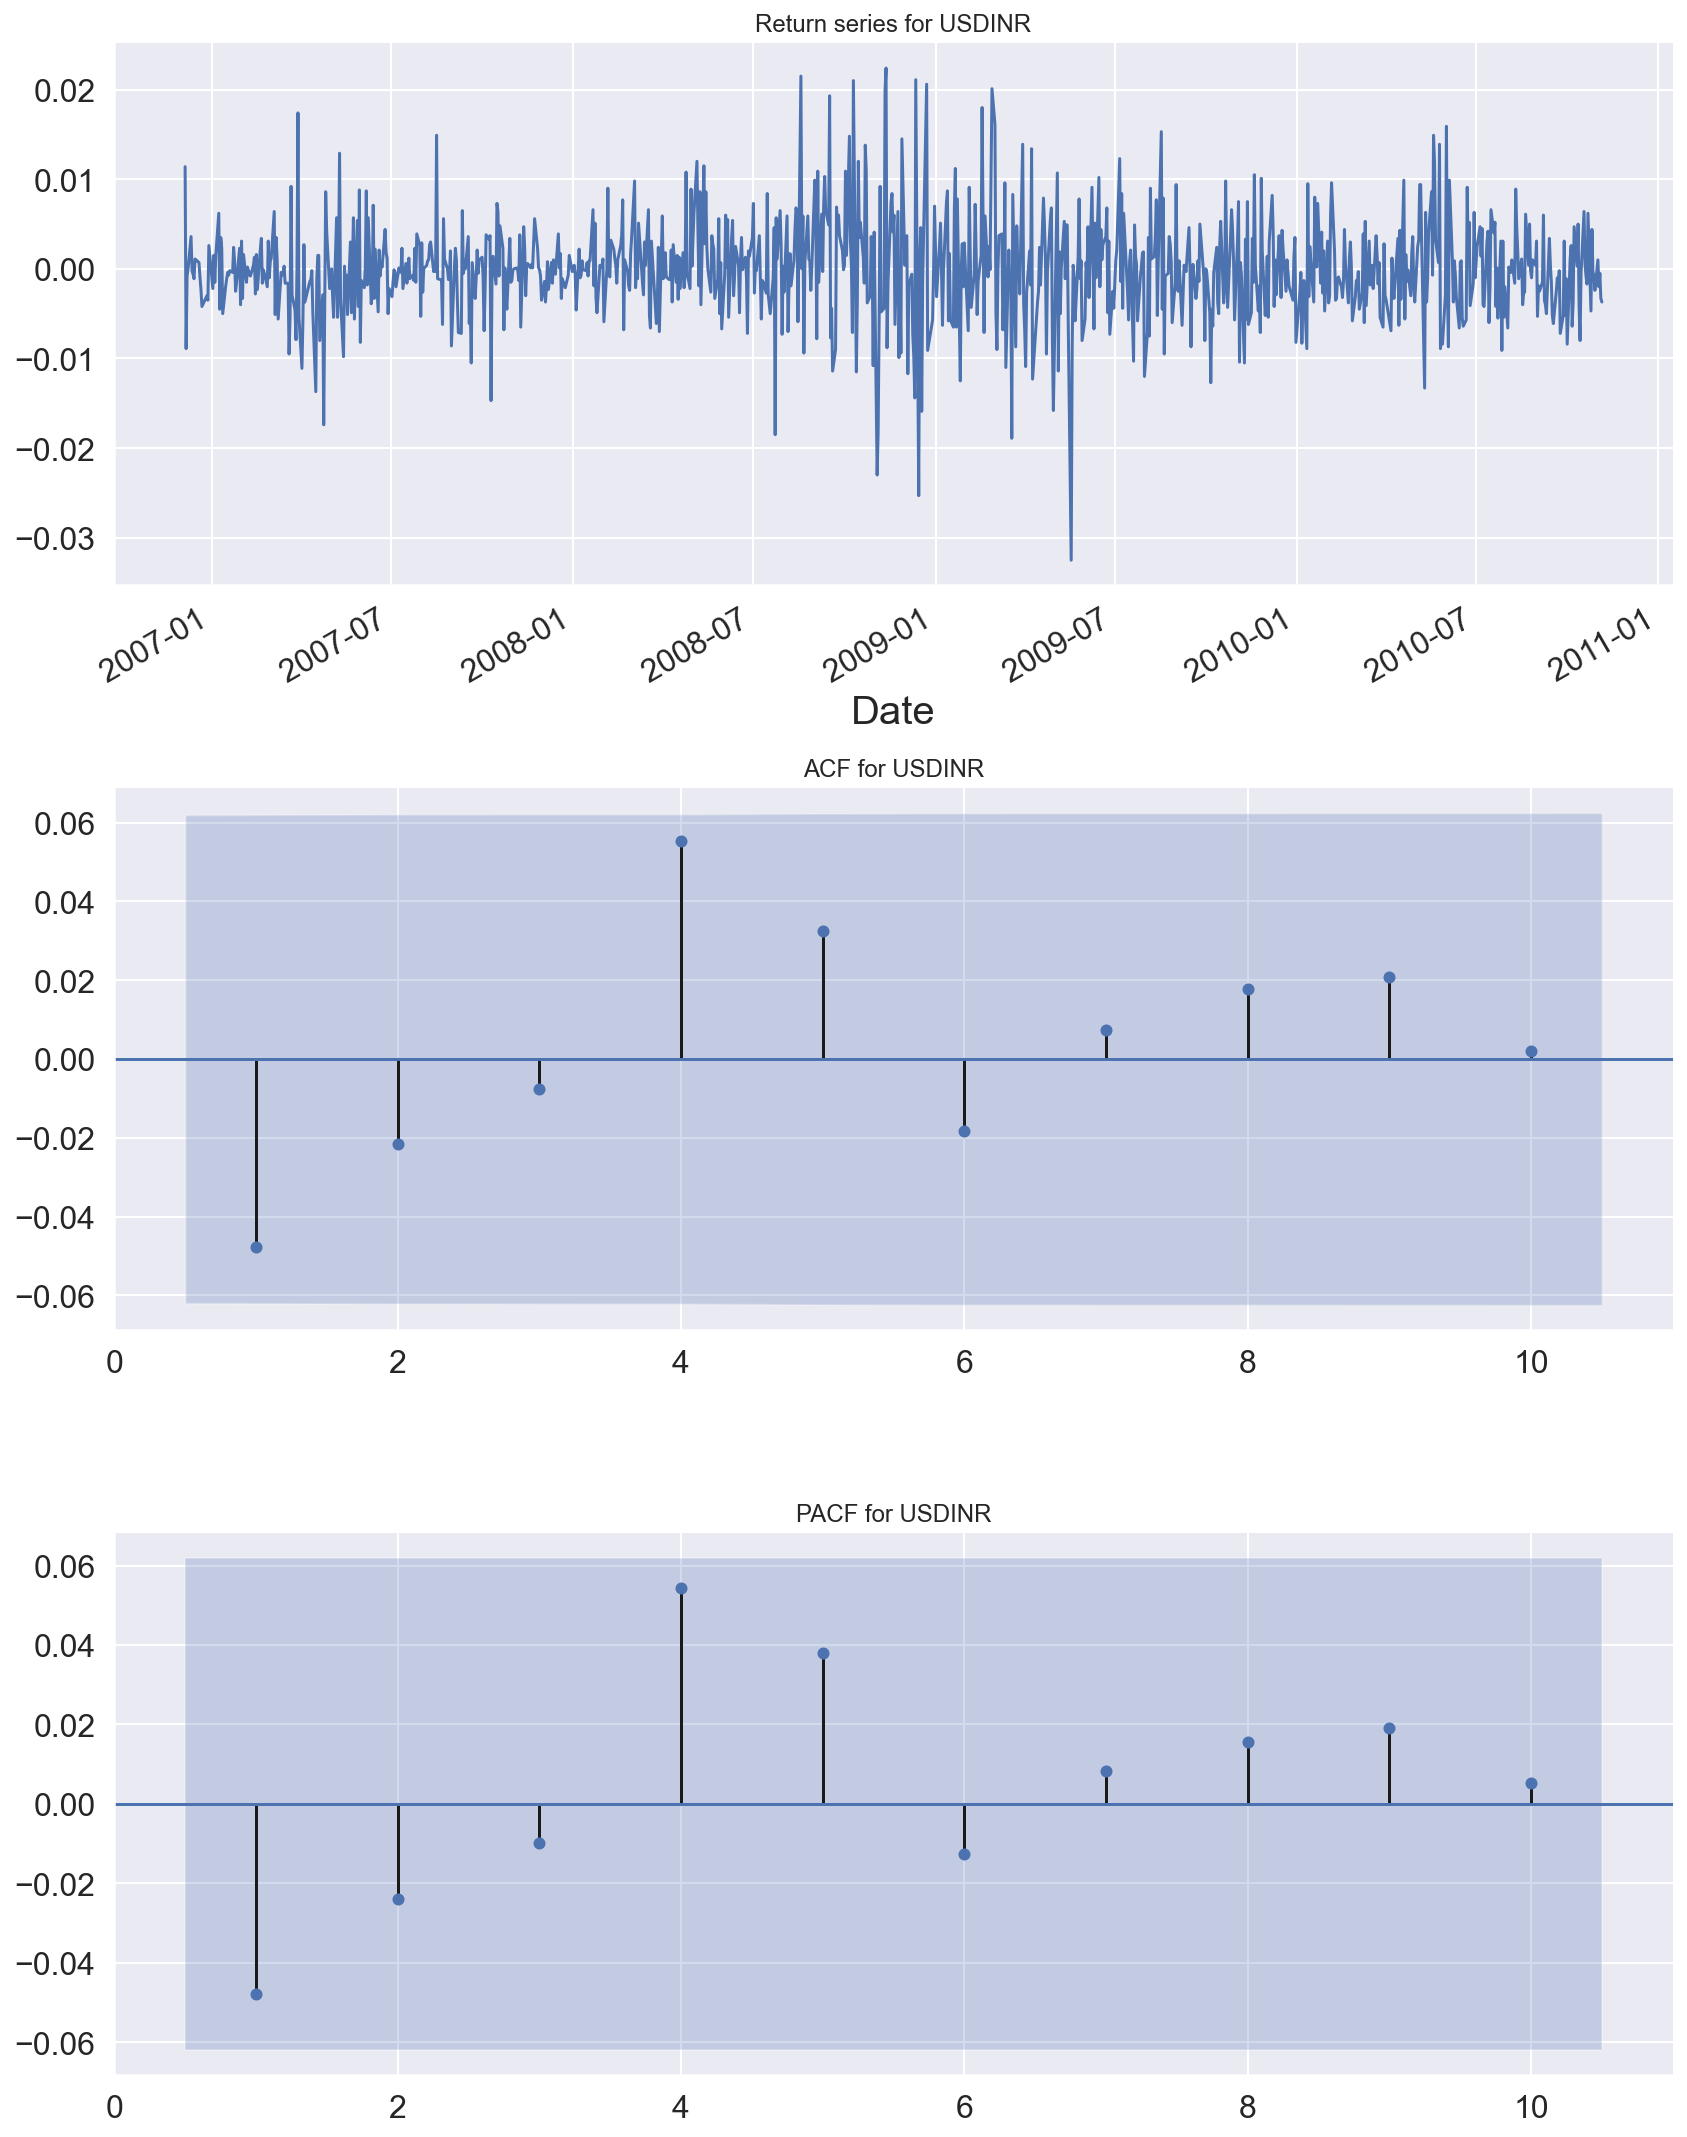

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.USDINR.plot(ax=ax1,title='Return series for USDINR')
_ = plot_acf(fx_returns.USDINR, ax=ax2,zero=False,alpha=0.05,lags=10,title='ACF for USDINR')
_ = plot_pacf(fx_returns.USDINR, ax=ax3,zero=False,alpha=0.05,lags=10,title='PACF for USDINR')
sns.despine()
plt.tight_layout()
plt.show()

The ACF and PACF show little or more significance at any lag.
Returns look little more than white noise so no real point running an ARMA modeling.

##### GBPINR

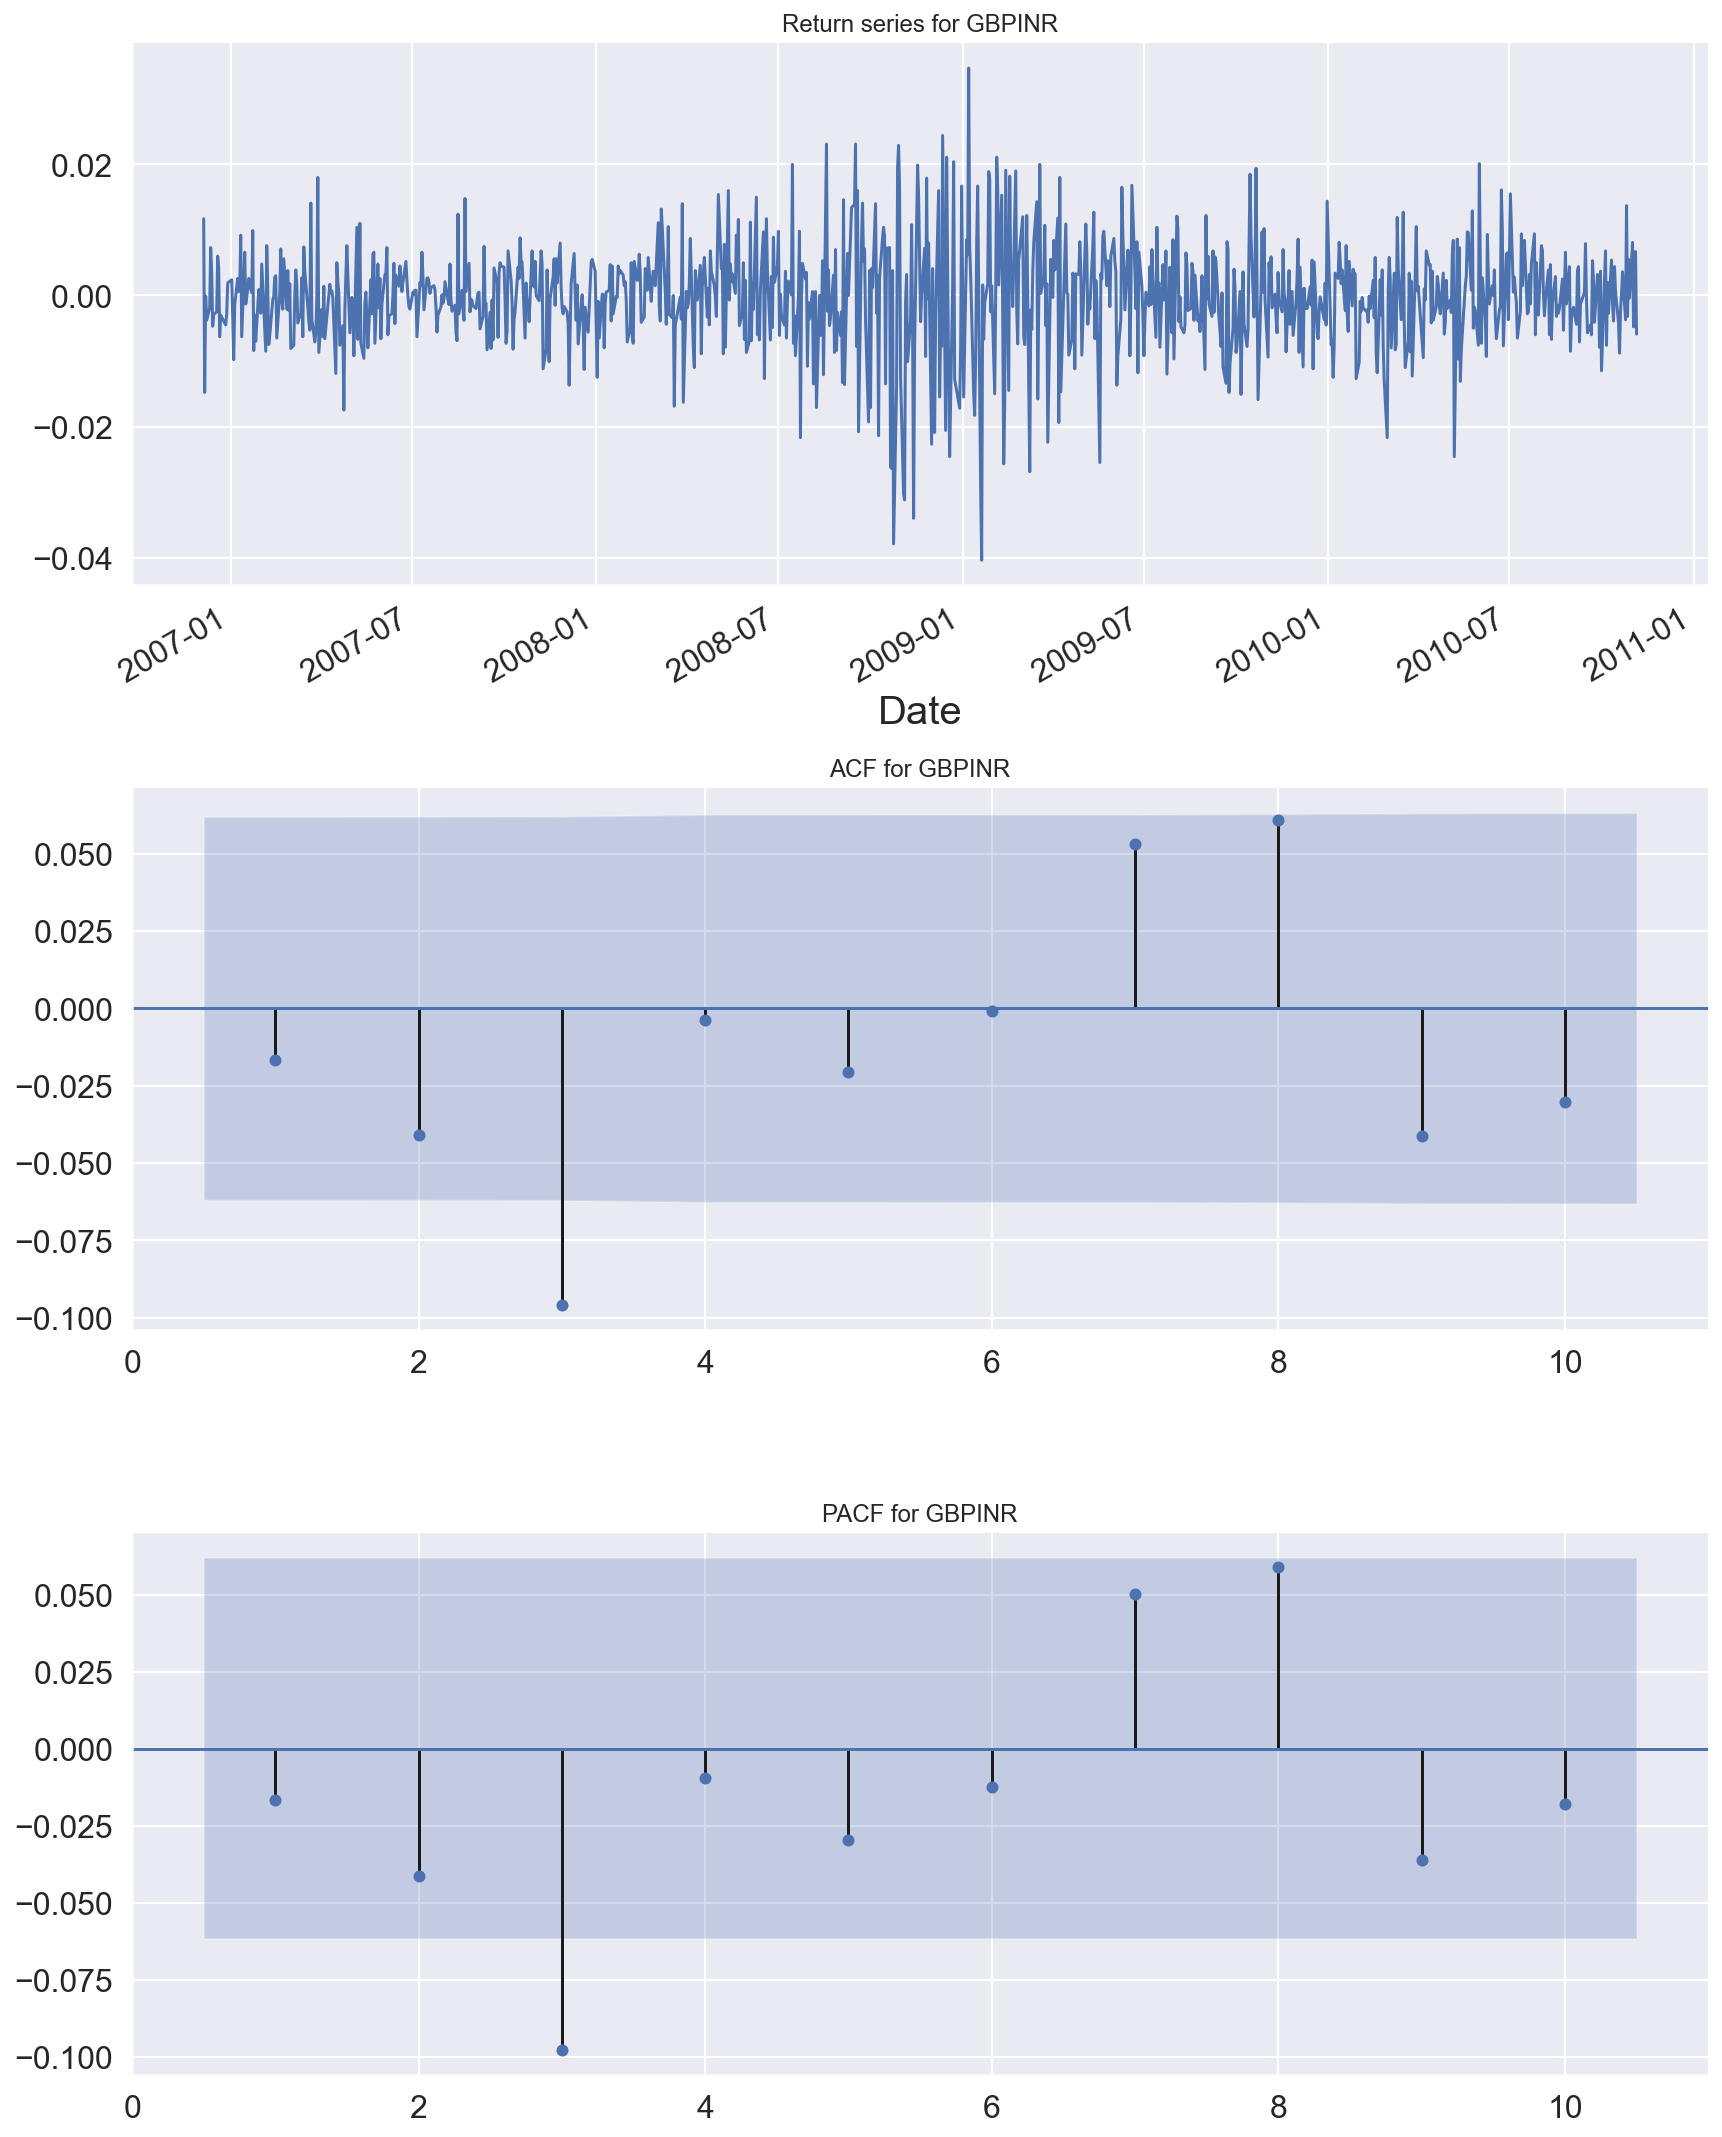

In [19]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.GBPINR.plot(ax=ax1,title='Return series for GBPINR')
_ = plot_acf(fx_returns.GBPINR, ax=ax2,zero = False,alpha=0.05,lags=10,title='ACF for GBPINR')
_ = plot_pacf(fx_returns.GBPINR, ax=ax3, zero = False,alpha=0.05,lags=10,title='PACF for GBPINR')
sns.despine()
plt.tight_layout()
plt.show()

The series show small but releavant ACF at lag 3 and so does the PACF. This could imply an ARMA(3,3). We are using the ARIMA implementation of the stats model package

In [20]:
results = ARIMA(fx_returns.GBPINR,(3,0,3)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 GBPINR   No. Observations:                 1001
Model:                     ARMA(3, 3)   Log Likelihood                3409.325
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 25 Oct 2020   AIC                          -6802.650
Time:                        09:11:22   BIC                          -6763.380
Sample:                             0   HQIC                         -6787.726
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.000     -0.829      0.407      -0.001       0.000
ar.L1.GBPINR    -0.2366      0.227     -1.044      0.296      -0.681       0.208
ar.L2.GBPINR    -0.1715      0.191     -0.900      0.368      -0.545       0.202
ar.L3.GBPINR     0.3563      0.239      1.491      0.136      -0.112       0.824
ma.L1.GBPINR     0.2112      0.215      0.984      0.325      -0.209       0.632
ma.L2.GBPINR     0.1231      0.181      0.678      0.498      -0.233       0.479
ma.L3.GBPINR    -0.4626      0.228     -2.031      0.042      -0.909      -0.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6404           -1.0875j            1.2621           -0.3347
AR.2           -0.6404           +1.0875j            1.2621            0.3347
AR.3            1.7621           -0.0000j            1.7621           -0.0000
MA.1           -0.6233           -1.0201j            1.1954           -0.3373
MA.2           -0.6233           +1.0201j            1.1954            0.3373
MA.3            1.5126           -0.0000j            1.5126           -0.0000
-----------------------------------------------------------------------------
"""

Most of the coefficients are non significant so the model seems overspecificied. Let's try a simpler ARMA(1,1) model

In [21]:
results = ARIMA(fx_returns.GBPINR,(1,0,1)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 GBPINR   No. Observations:                 1001
Model:                     ARMA(1, 1)   Log Likelihood                3403.279
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 25 Oct 2020   AIC                          -6798.558
Time:                        09:11:23   BIC                          -6778.923
Sample:                             0   HQIC                         -6791.096
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.000     -0.688      0.492      -0.001       0.000
ar.L1.GBPINR    -0.8320      0.153     -5.452      0.000      -1.131      -0.533
ma.L1.GBPINR     0.8142      0.159      5.125      0.000       0.503       1.126
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2019           +0.0000j            1.2019            0.5000
MA.1           -1.2281           +0.0000j            1.2281            0.5000
-----------------------------------------------------------------------------
"""

A little better but not likely really a strongly predicting relationship.

##### EURINR

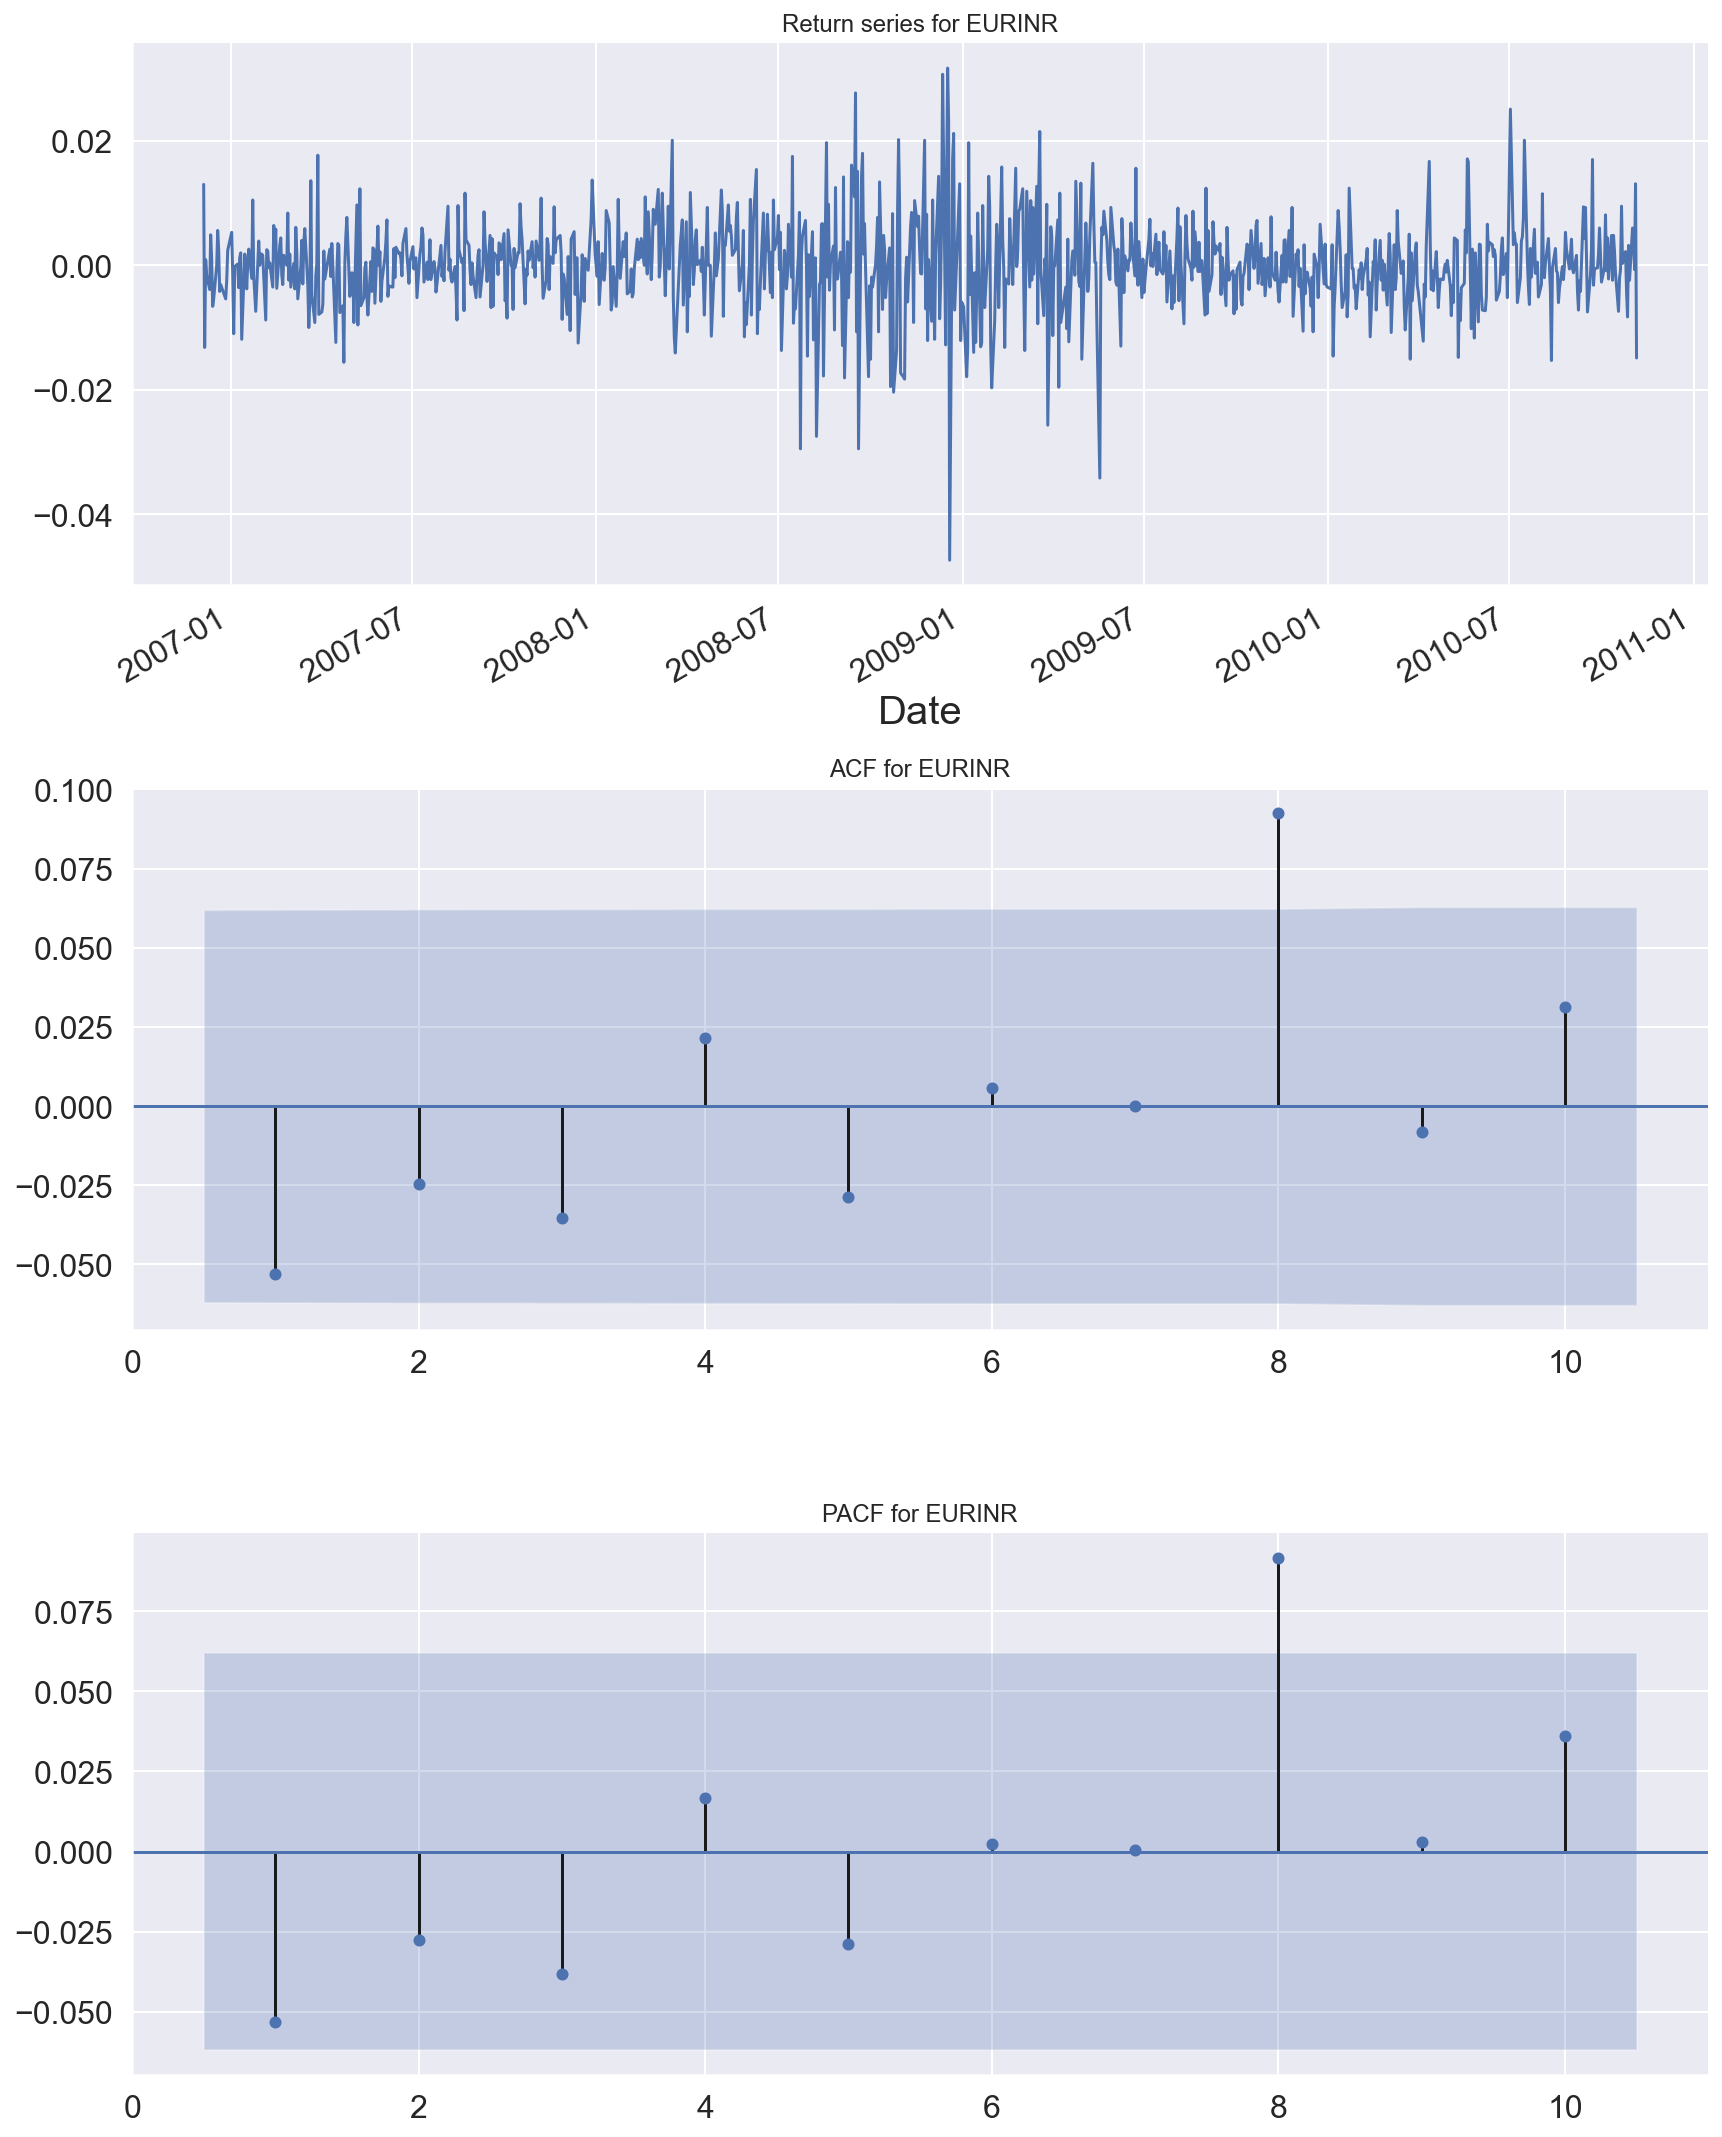

In [22]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = fx_returns.EURINR.plot(ax=ax1,title='Return series for EURINR')
_ = plot_acf(fx_returns.EURINR, ax=ax2,zero = False,alpha=0.05,lags=10,title='ACF for EURINR')
_ = plot_pacf(fx_returns.EURINR, ax=ax3, zero = False,alpha=0.05,lags=10,title='PACF for EURINR')
sns.despine()
plt.tight_layout()
plt.show()



The ACF and PACF show only significance at lag 7 so very weak dependency. No real point running an ARMA modeling.

#### Part 2 GARCH Modeling


We'll use the arch package to fit the time series


##### USDINR

In [23]:
am = arch_model(fx_returns.USDINR)
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6.346434436222032e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8.42753773409707e+26
Iteration:      3,   Func. Count:     34,   Neg. LLF: 1.9721936693701143e+22
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2083615611722199.2
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.65091332932914e+20
Iteration:      6,   Func. Count:     76,   Neg. LLF: 8795446818084500.0
Iteration:      7,   Func. Count:     91,   Neg. LLF: 3.878710911402228e+20
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6733602488270100.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3854.3176772261477
            Iterations: 12
            Function evaluations: 113
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 USDINR   R-squared:                      -0.000
Mean Model:             Constant 

### Question 3

Exchange rates: The file exchange_rates_2.csv contains exchange rates between US dollar and twenty-five major currencies. The daily data spans January 3, 2000 to April 10, 2012. Use this data to perform the following tasks: After computing the returns, $r_{t} = log(p_{t}) − log(p_{t-1}$ for each series.
1. Plot histograms of the returns and test if the distributions are normal, via Q–Q plots.
2. Compute the auto-correlation function and identify which lags are significant. What is the tentative ARMA model?
3. Is there any ARCH effect? Why?
4. GARCH(1,1) and IGARCH(1,1) models using both normal and $t$-distributions for the innovations. Which volatility model appears to be the best?

In [24]:
fx_rates2 = pd.read_csv('../datasets/exchange_rates_2.csv',index_col='DATE',parse_dates=True)
fx_rates2 = fx_rates2.drop(columns=['Unnamed: 0','days']).dropna()
fx_rates2.index.name='Date'
fx_rates2.head()
currencies = fx_rates2.columns

In [62]:
fx_returns = fx_rates2.apply(lambda x: np.log(x) - np.log(x.shift())).dropna()
fx_returns.head()

ARS       AUD       BRL       CAD       CHF       CNY  \
Date                                                                     
2003-06-12  0.010648  0.001356  0.003501 -0.001331  0.005494  0.000012   
2003-06-13 -0.001767  0.004208 -0.008423 -0.007465 -0.004309 -0.000036   
2003-06-16 -0.001770  0.000899  0.012433 -0.001082 -0.006287  0.000012   
2003-06-17 -0.004439  0.004485 -0.002788  0.001566  0.002880 -0.000012   
2003-06-18 -0.004458  0.003870  0.007823 -0.004406  0.013671  0.000000   

                 CZK       DKK       EUR       GBP       HKD       HUF  \
Date                                                                     
2003-06-12  0.002178  0.002167 -0.002214  0.000510  0.000026  0.005342   
2003-06-13 -0.006019 -0.005800  0.005737 -0.000989  0.000038 -0.002360   
2003-06-16 -0.002739 -0.004875  0.004946  0.008155 -0.000051  0.003606   
2003-06-17  0.004700  0.003491 -0.003422  0.004778  0.000013  0.012219   
2003-06-18  0.011644  0.010559 -0.010506 -0.006863 -0.000013  0.022317   

                 JPY       KRW       MXN       NOK       NZD       PLN  \
Date                                                                     
2003-06-12  0.001061 -0.001842 -0.001131 -0.000315  0.000605  0.004946   
2003-06-13 -0.002166 -0.001090 -0.001416 -0.006559  0.002590 -0.008324   
2003-06-16 -0.000298 -0.001343 -0.006397 -0.001571  0.004817 -0.015308   
2003-06-17  0.004837 -0.005307 -0.002285  0.001124  0.001972  0.004101   
2003-06-18  0.003381  0.000675  0.006696  0.008185  0.000771  0.018215   

                 RUB       SAR       SEK       SGD       TRY       ZAR  
Date                                                                    
2003-06-12  0.000000  0.000013  0.000788  0.000892 -0.004098 -0.014630  
2003-06-13  0.000000 -0.000053 -0.004969 -0.002275 -0.002045  0.003847  
2003-06-16 -0.003413  0.000000 -0.006756 -0.003061  0.001705 -0.008338  
2003-06-17 -0.001086  0.000000  0.001983 -0.001158 -0.002428  0.006736  
2003-06-18 -0.000099  0.000000  0.011470  0.001100  0.001133  0.009859

#### Part 1

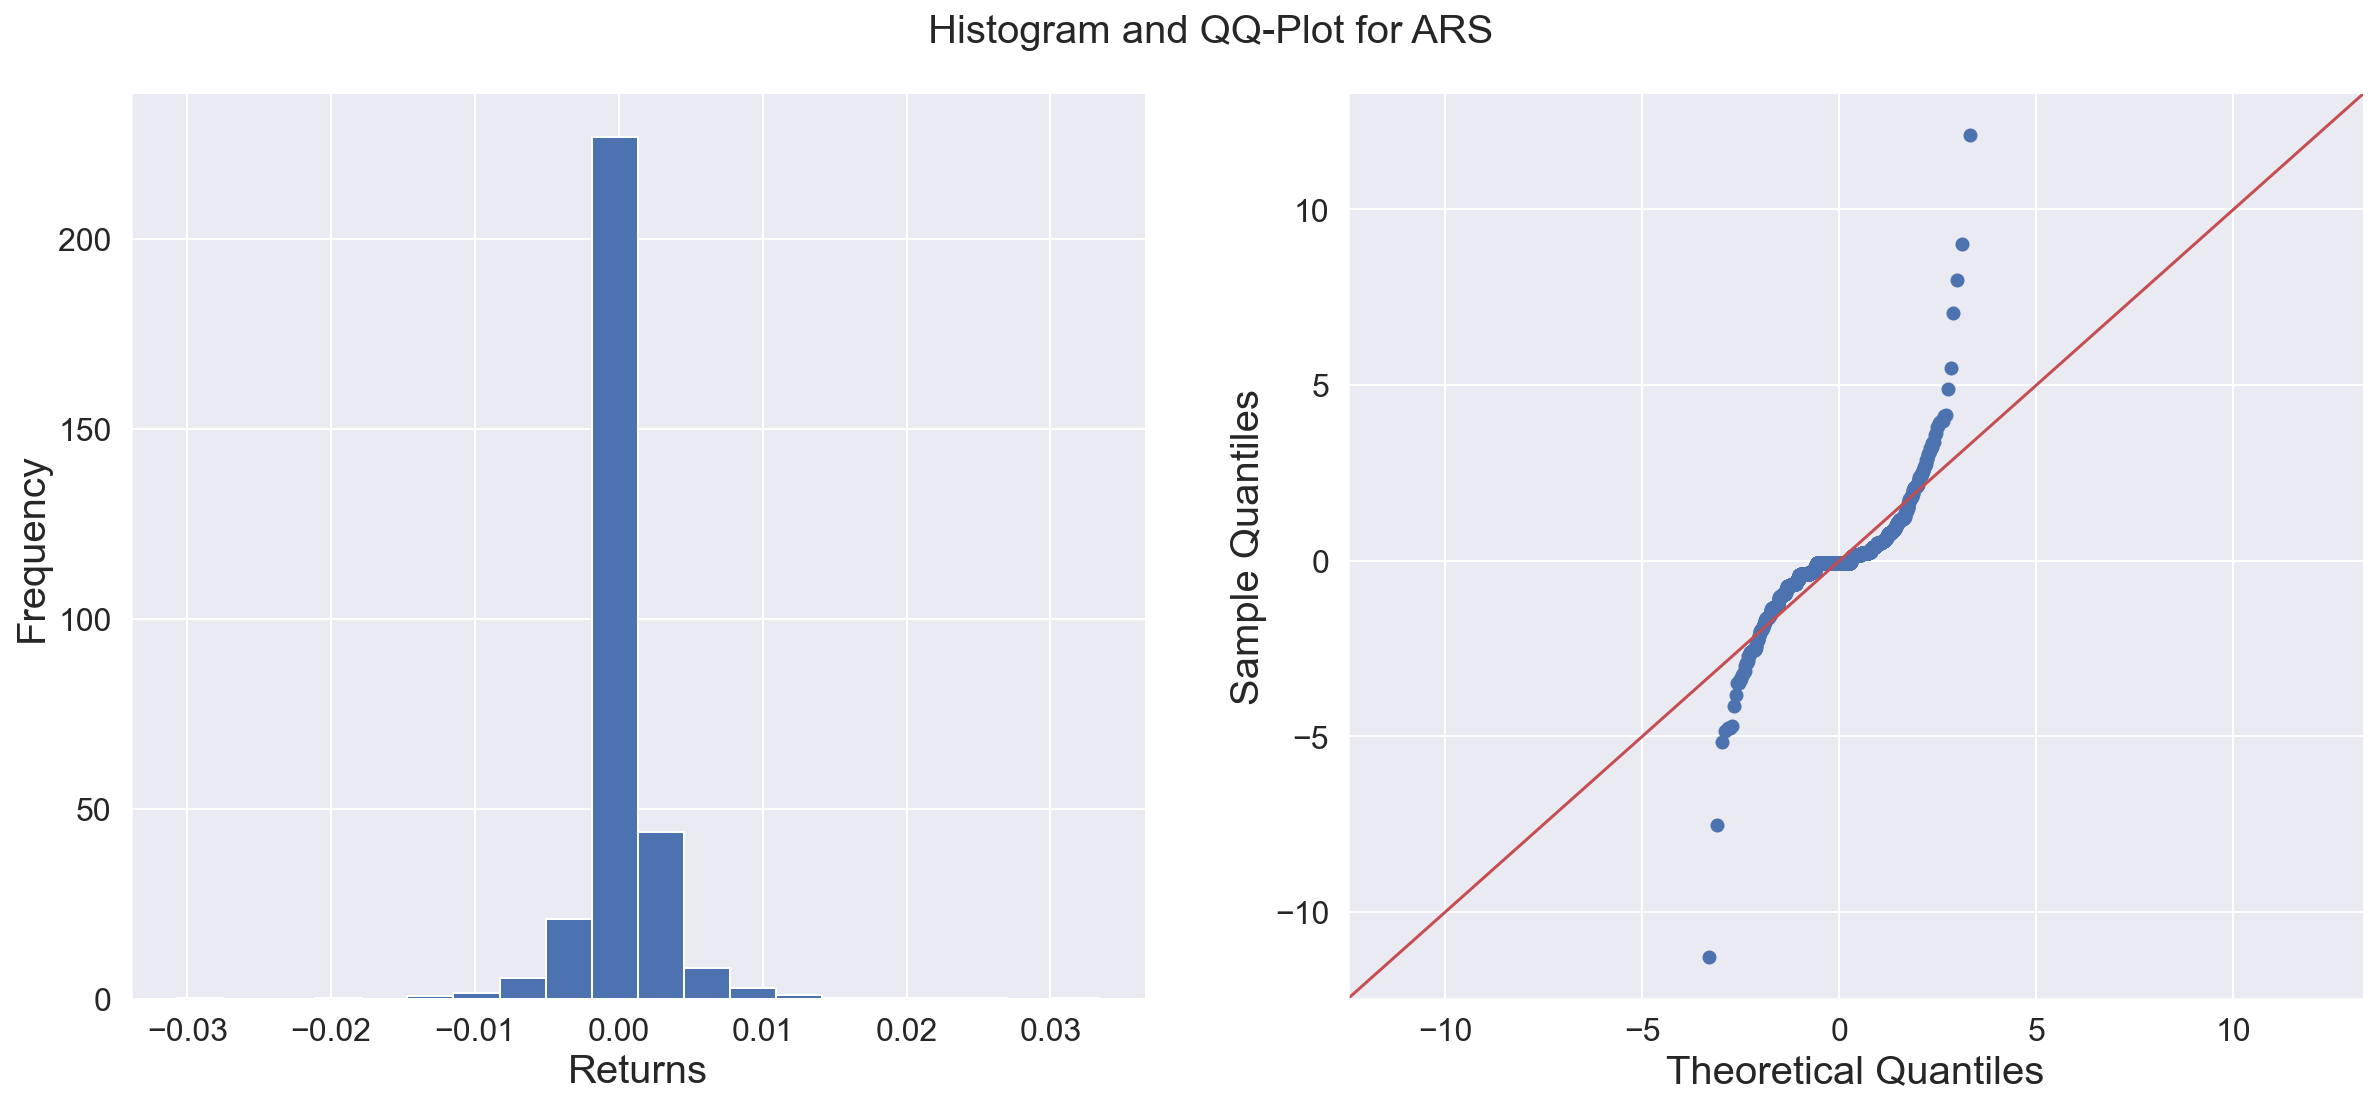

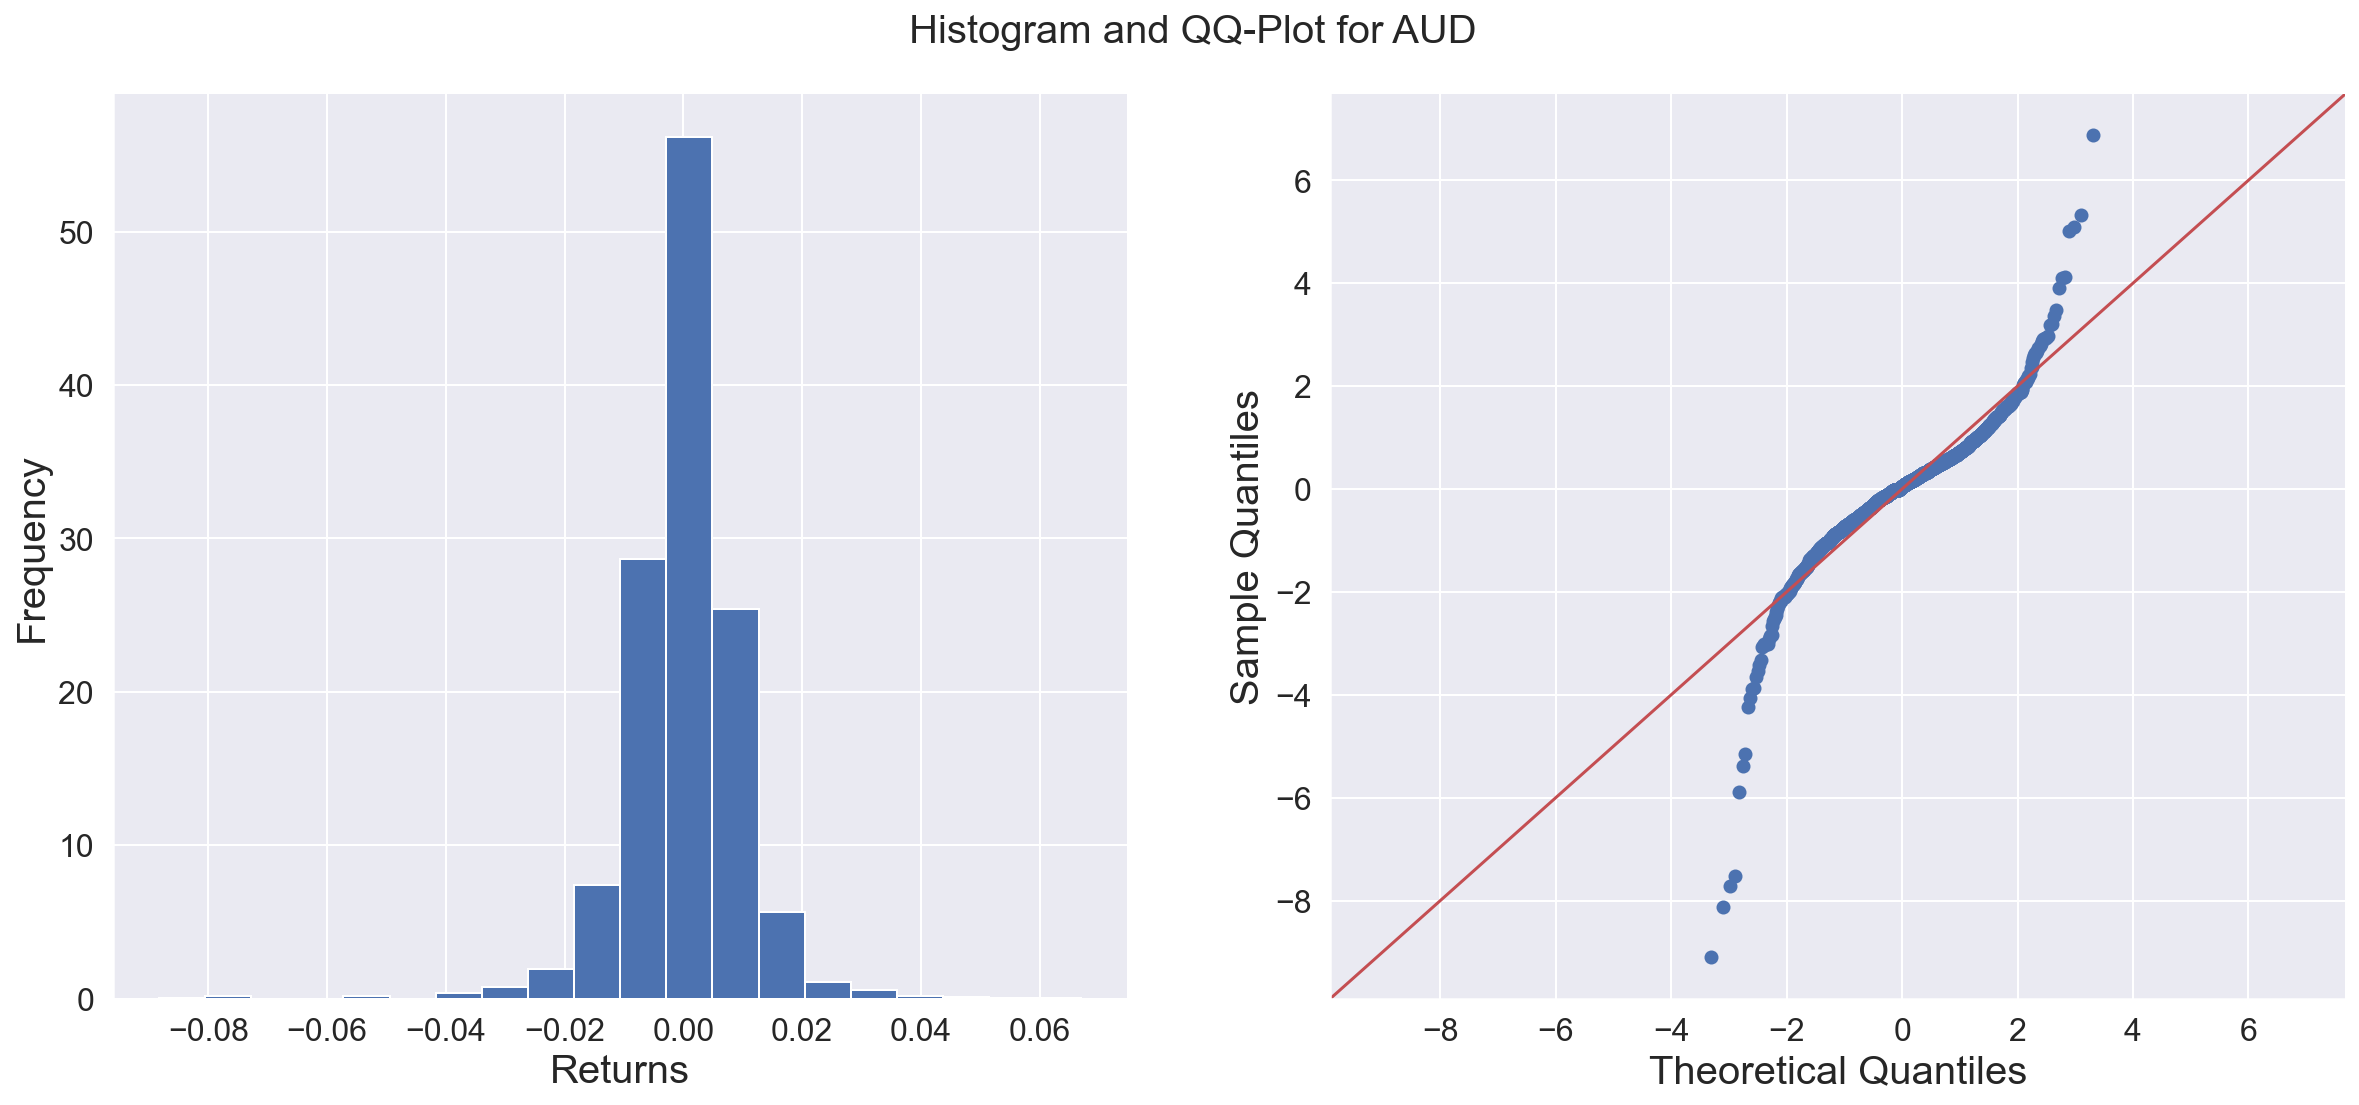

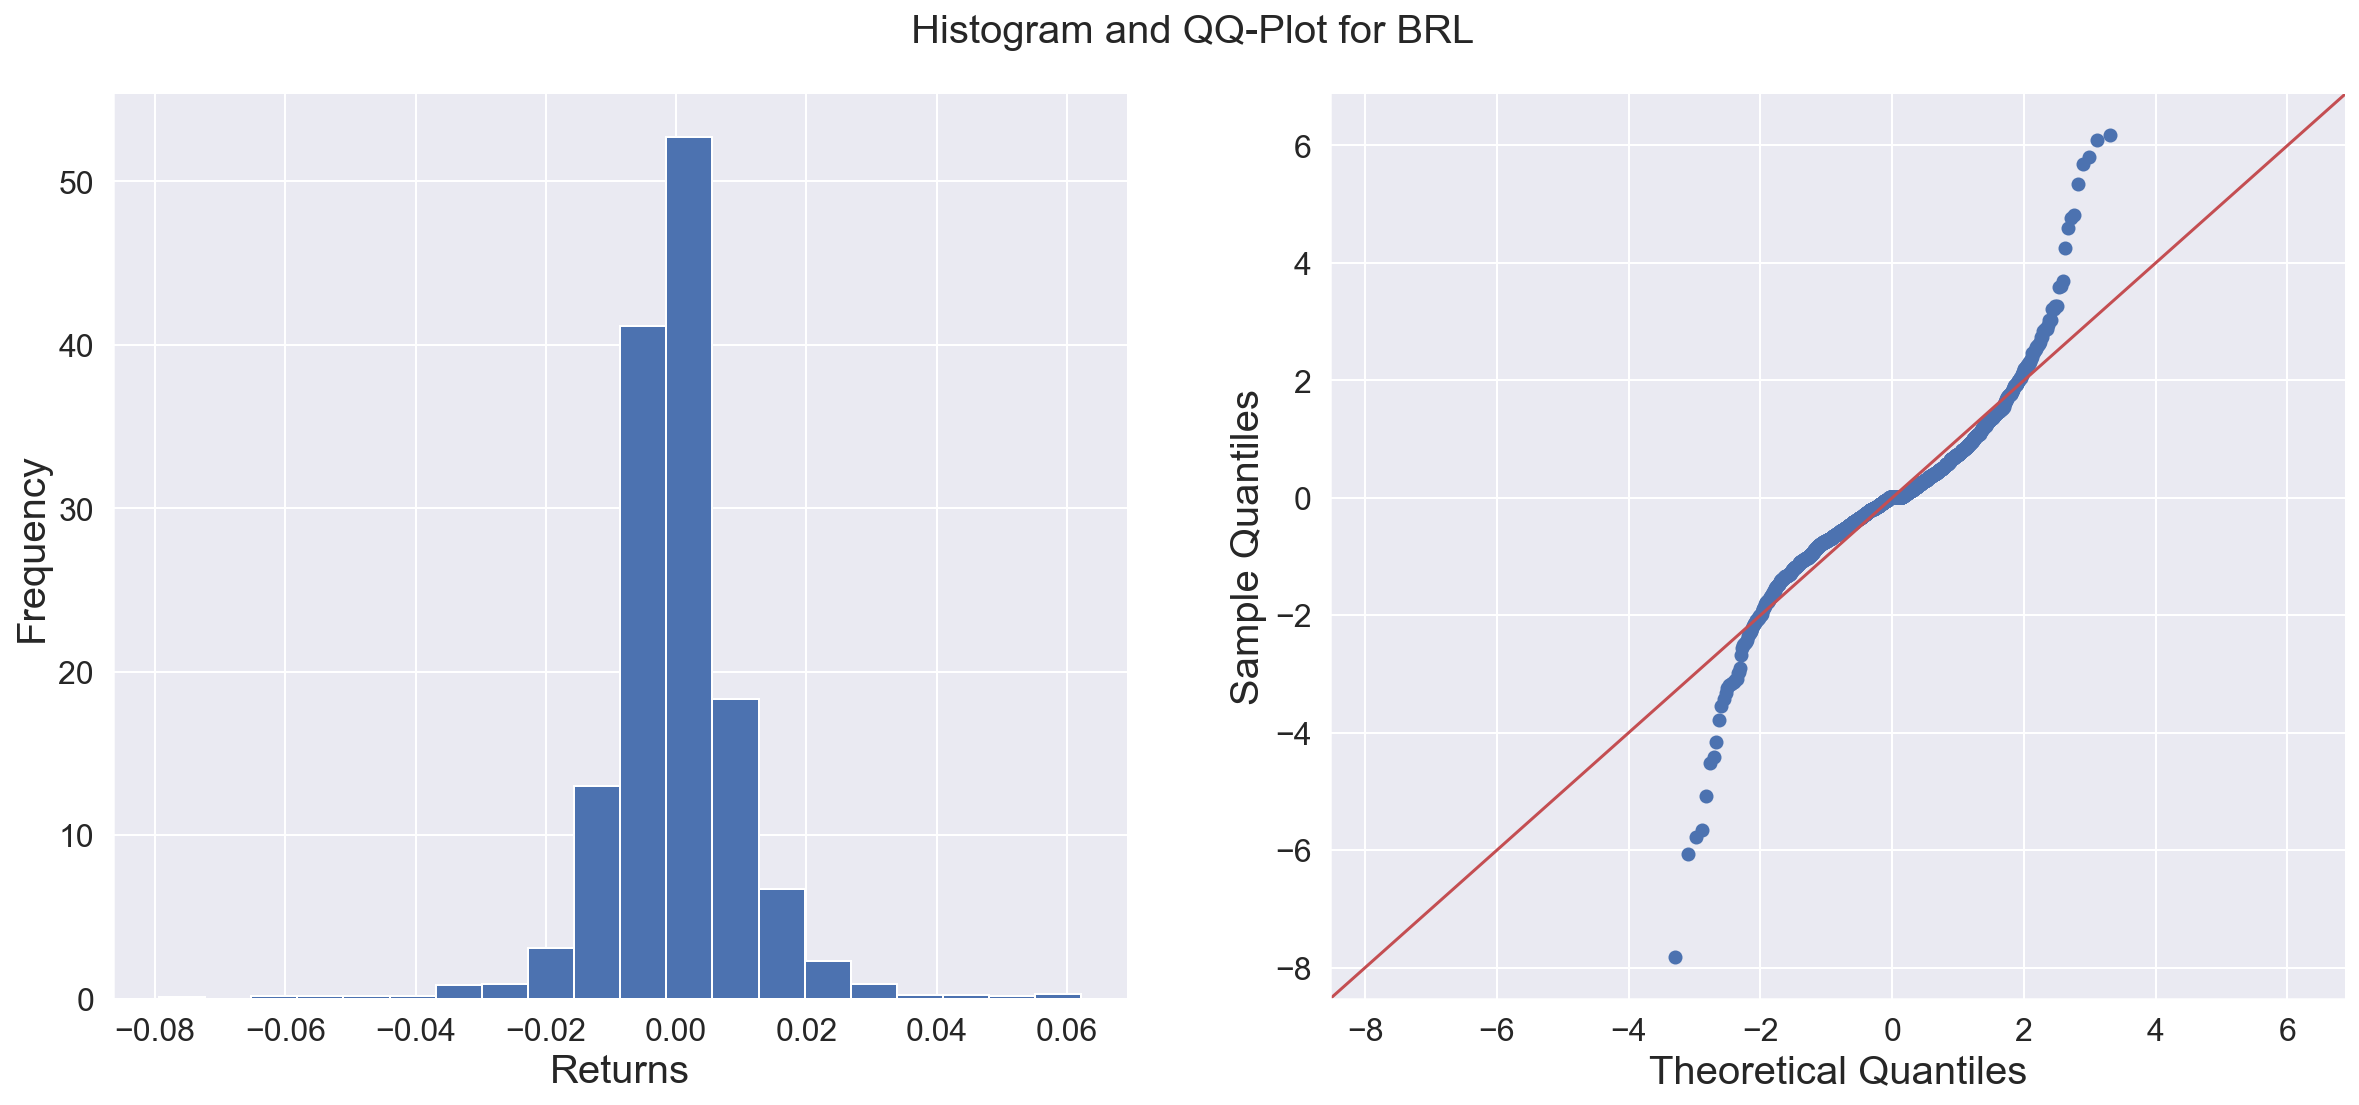

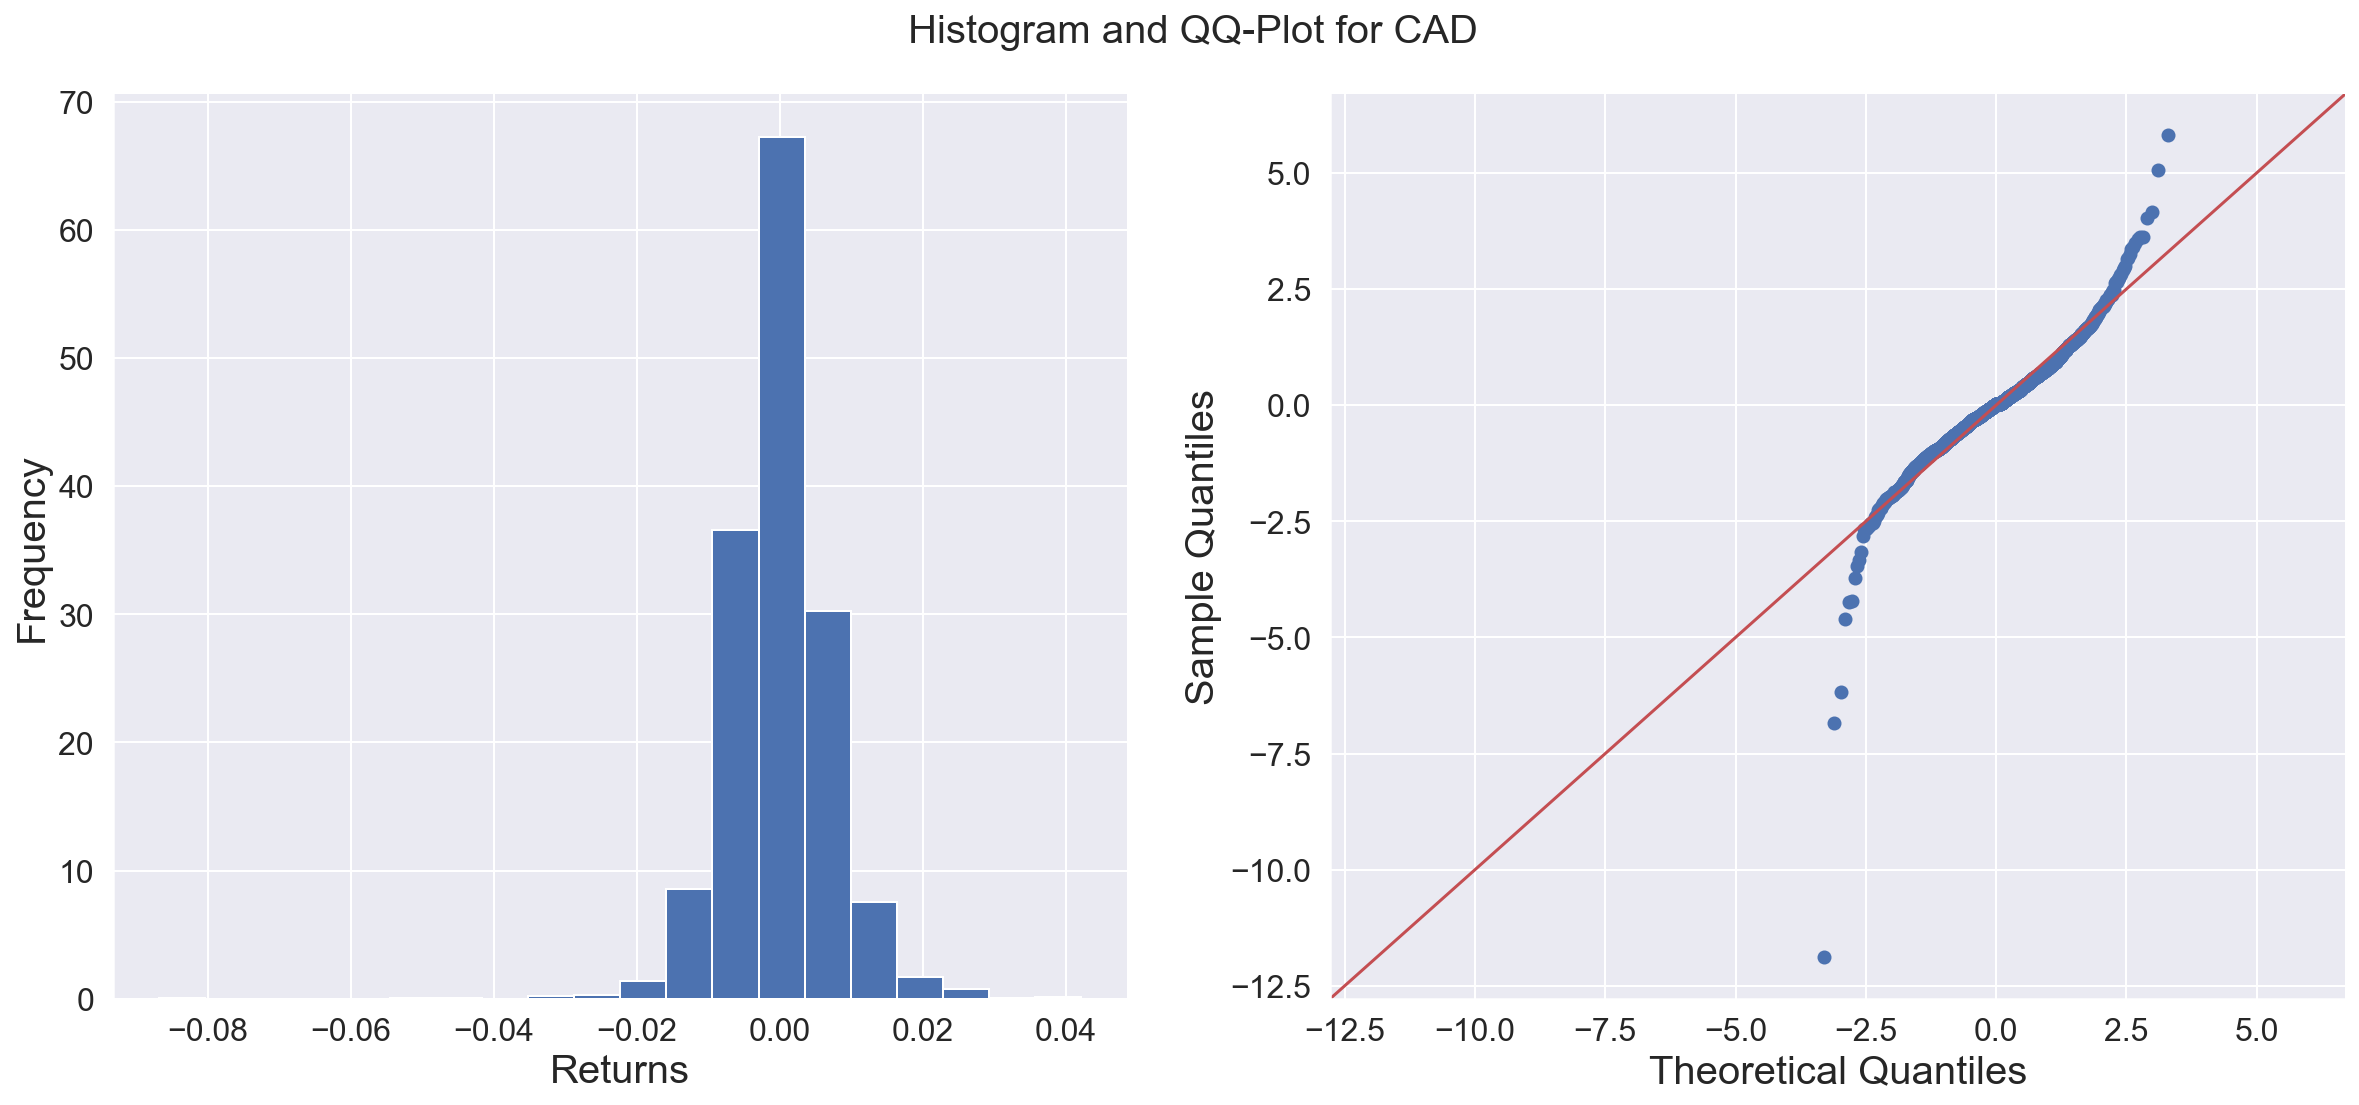

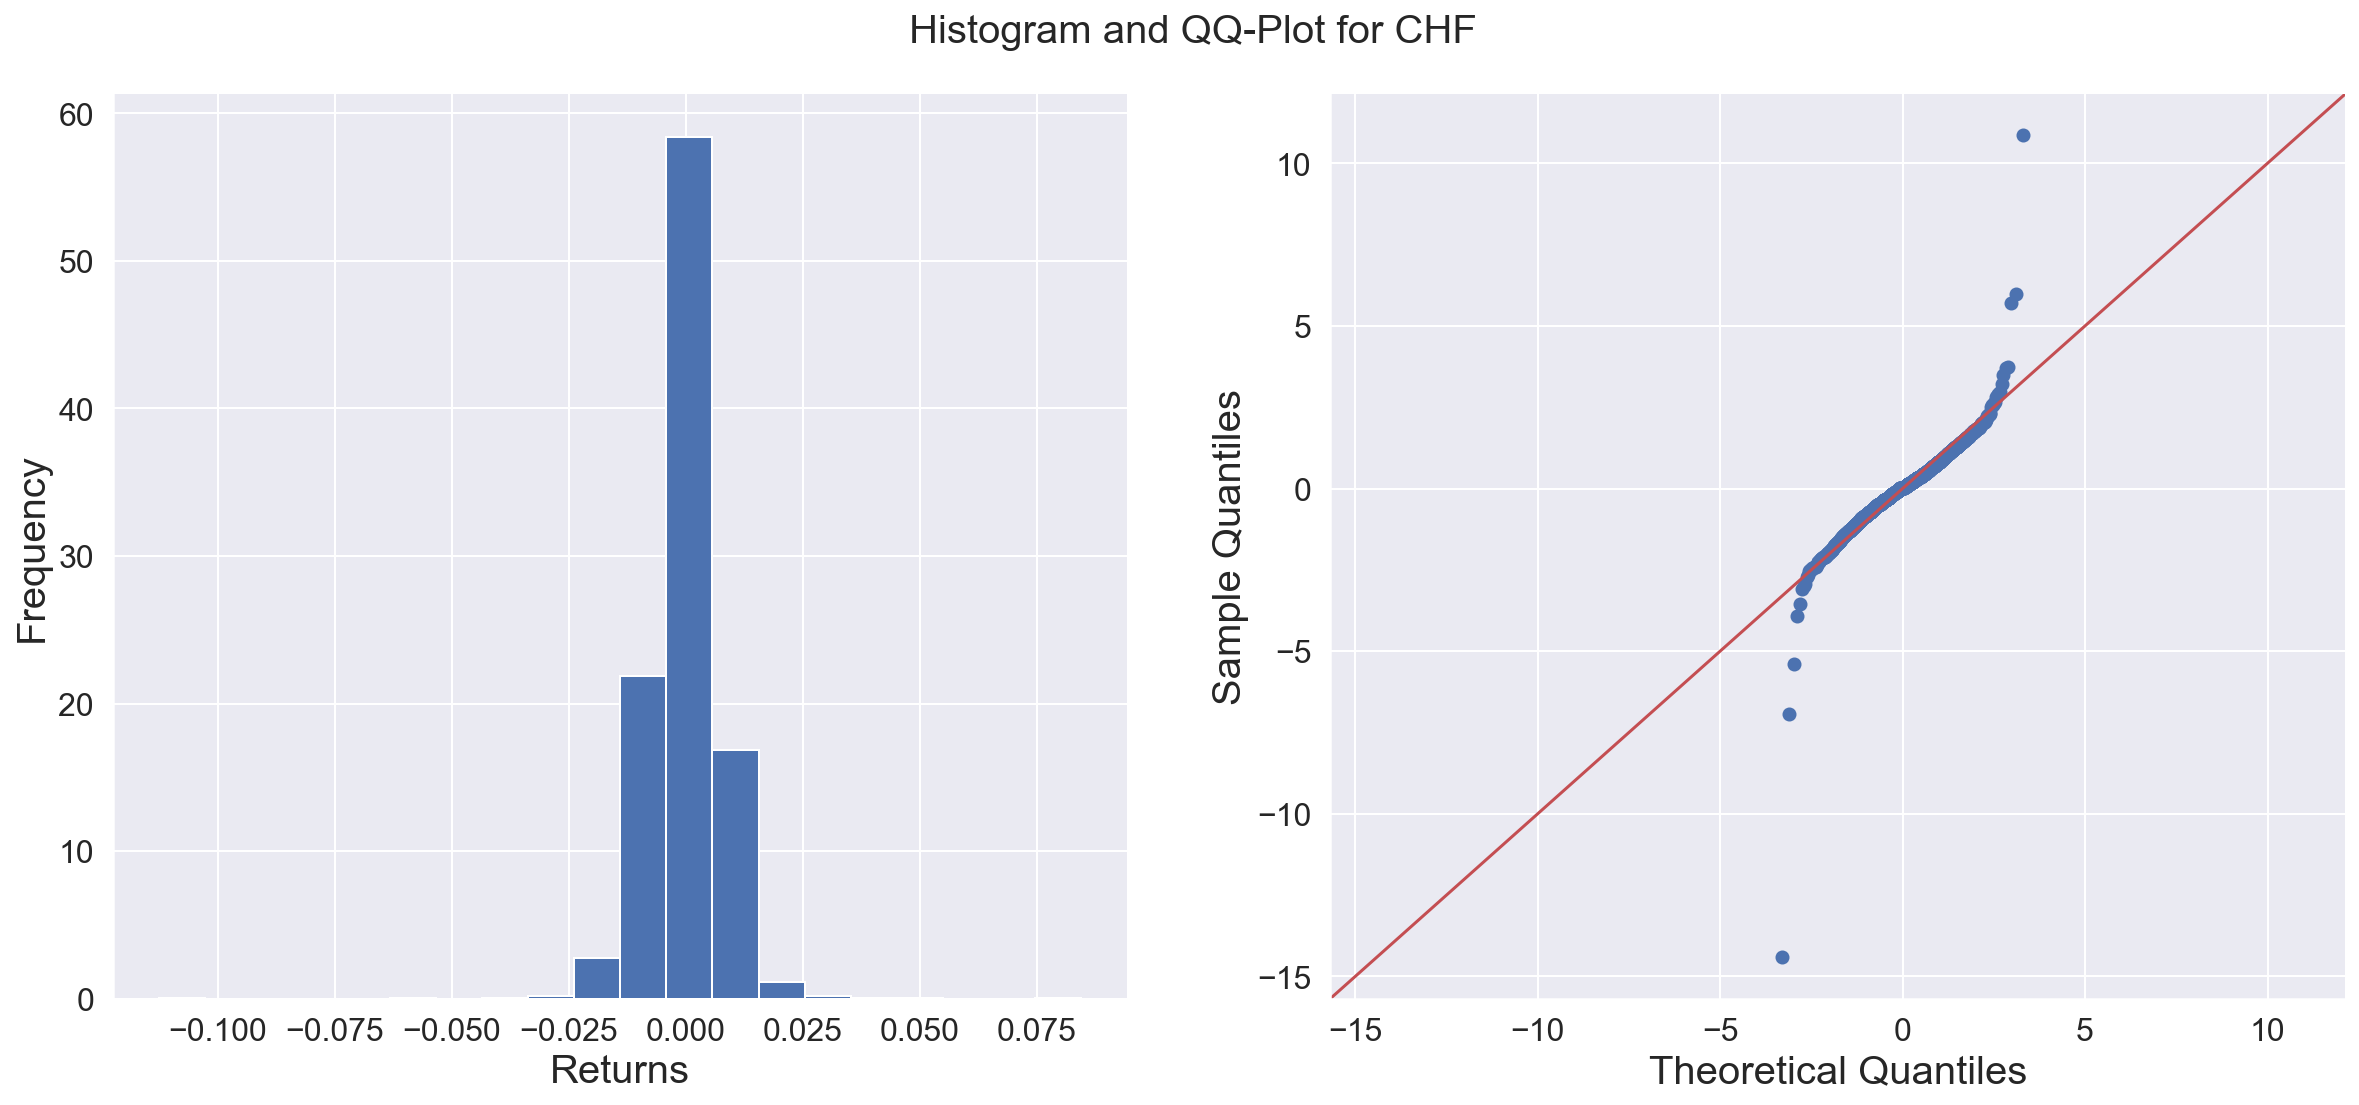

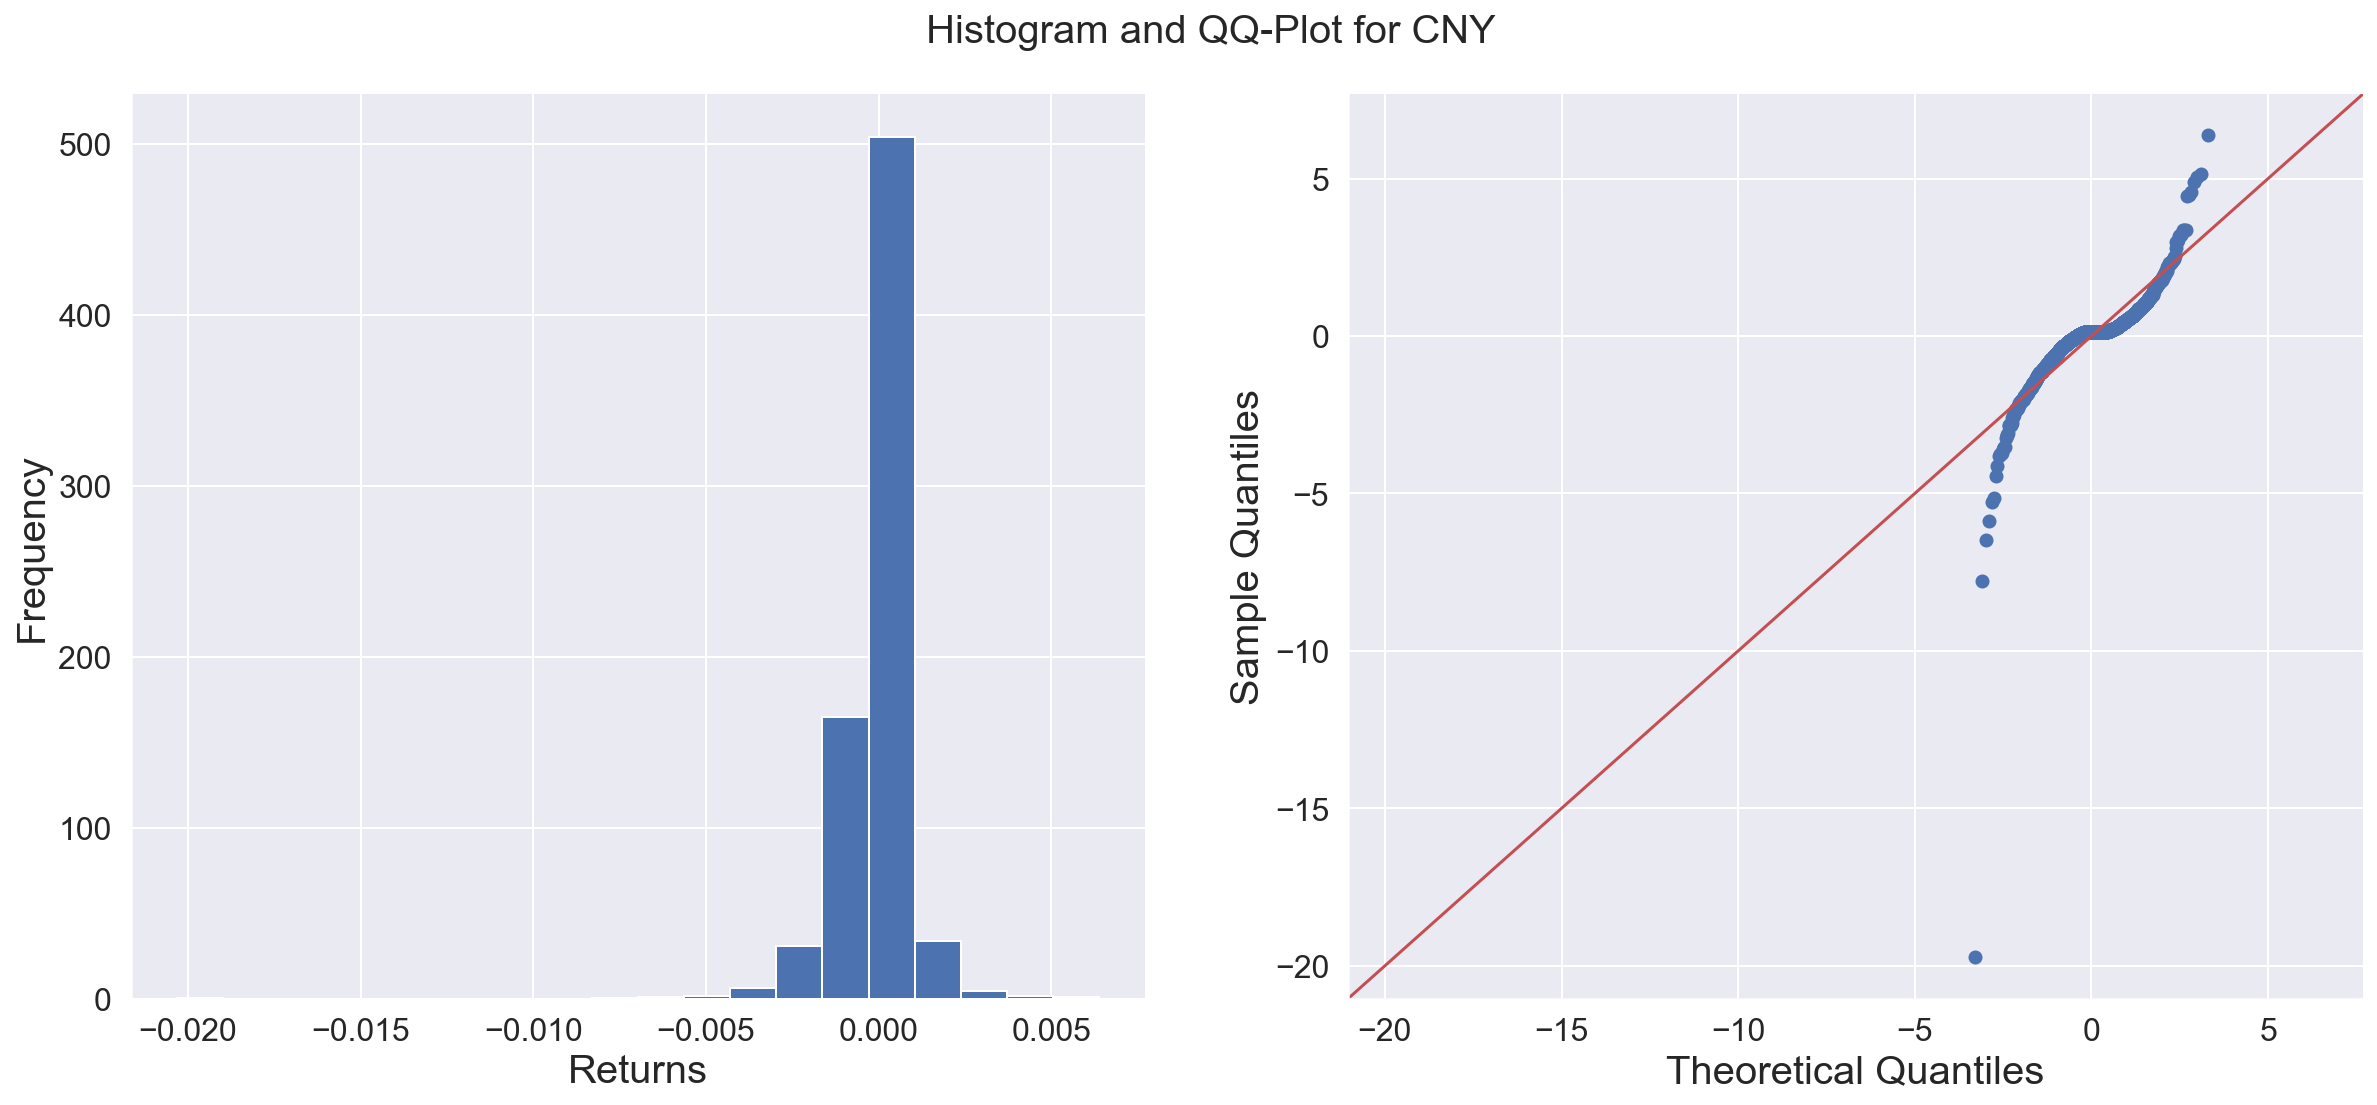

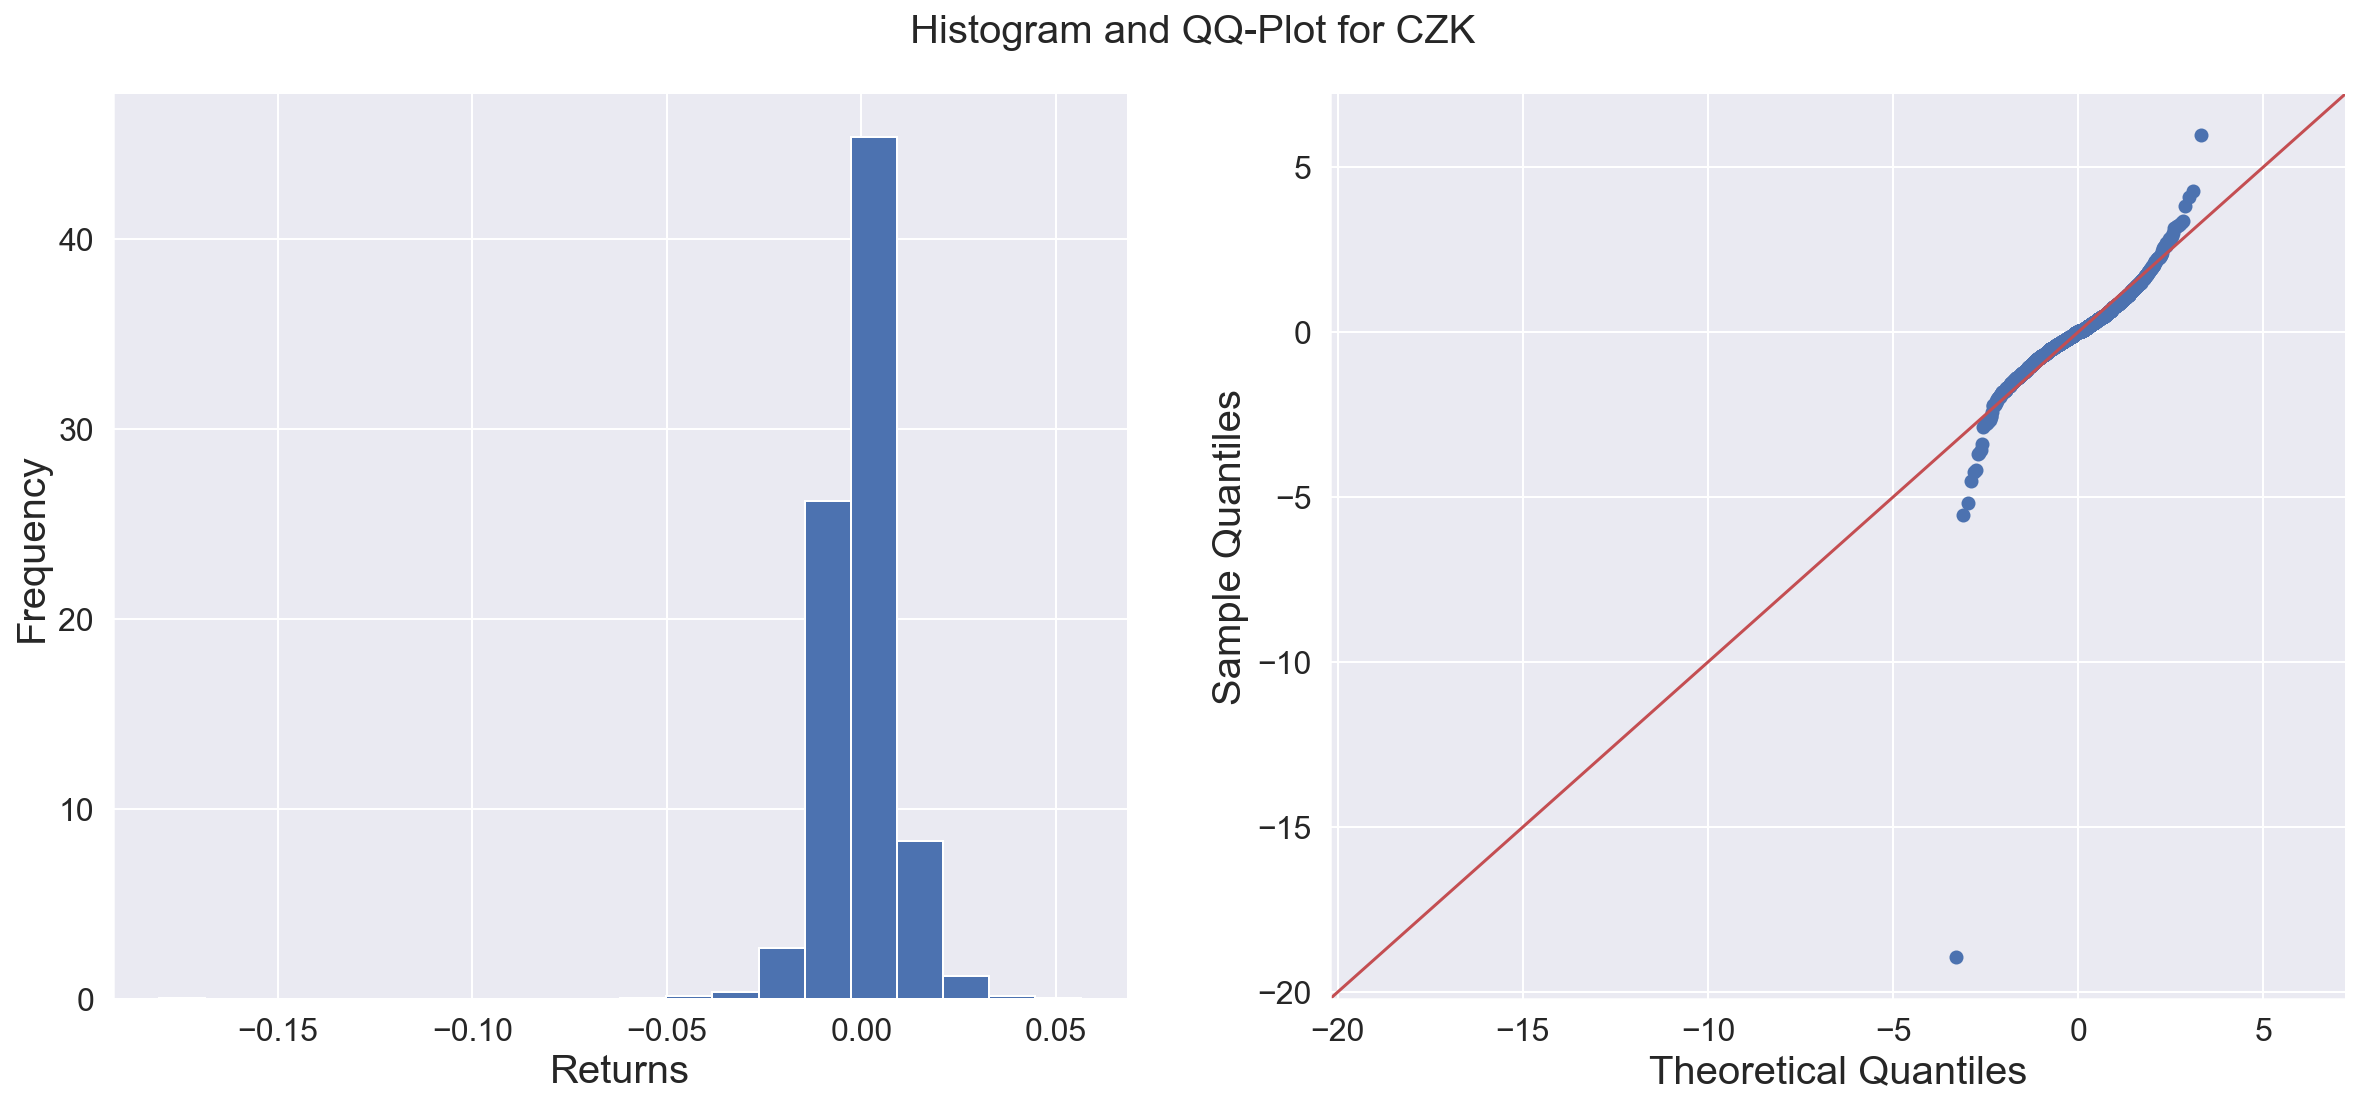

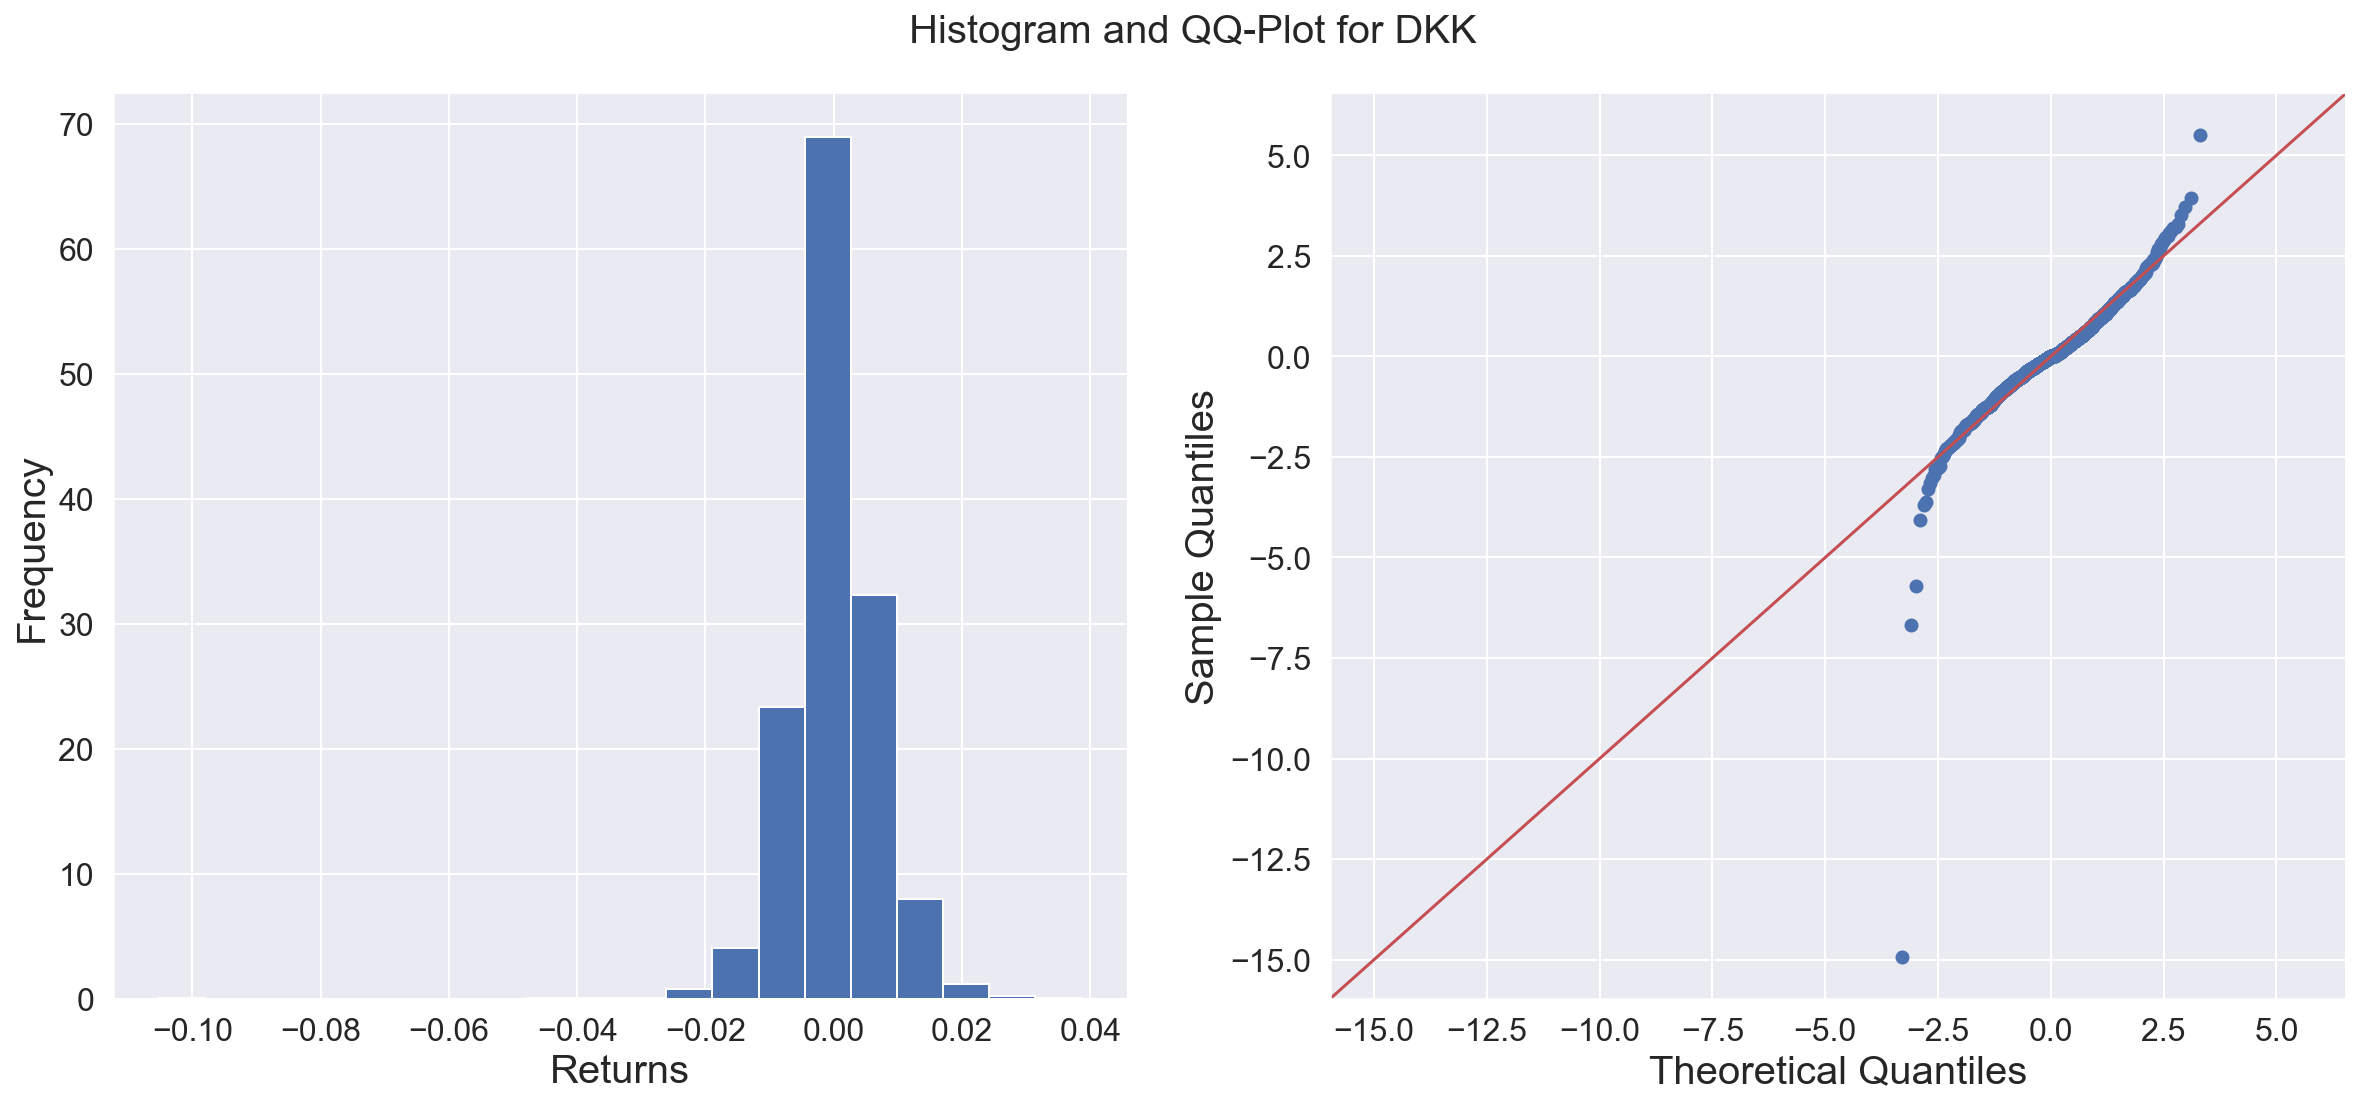

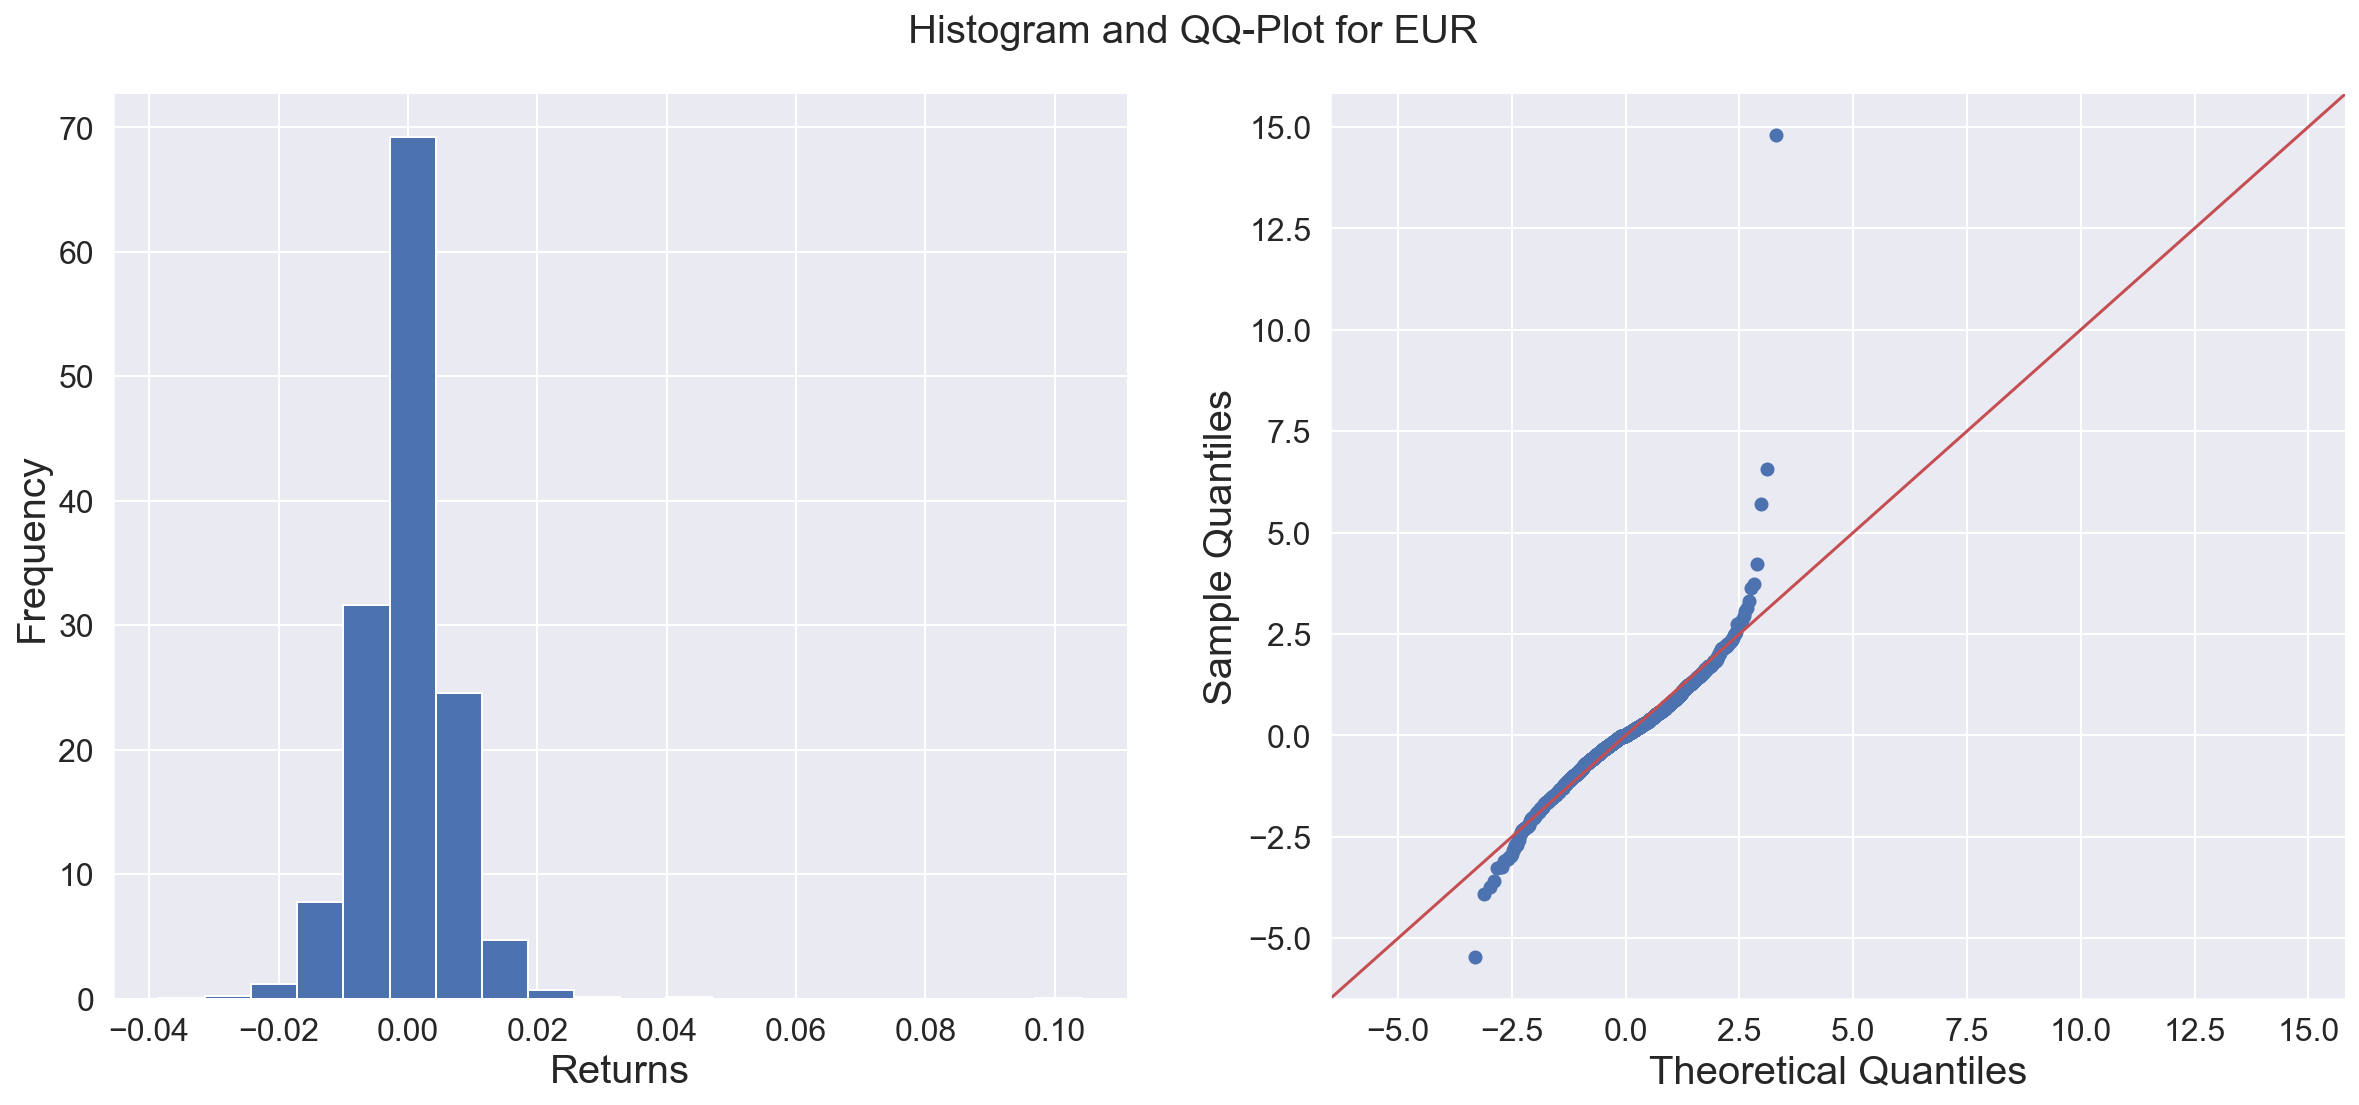

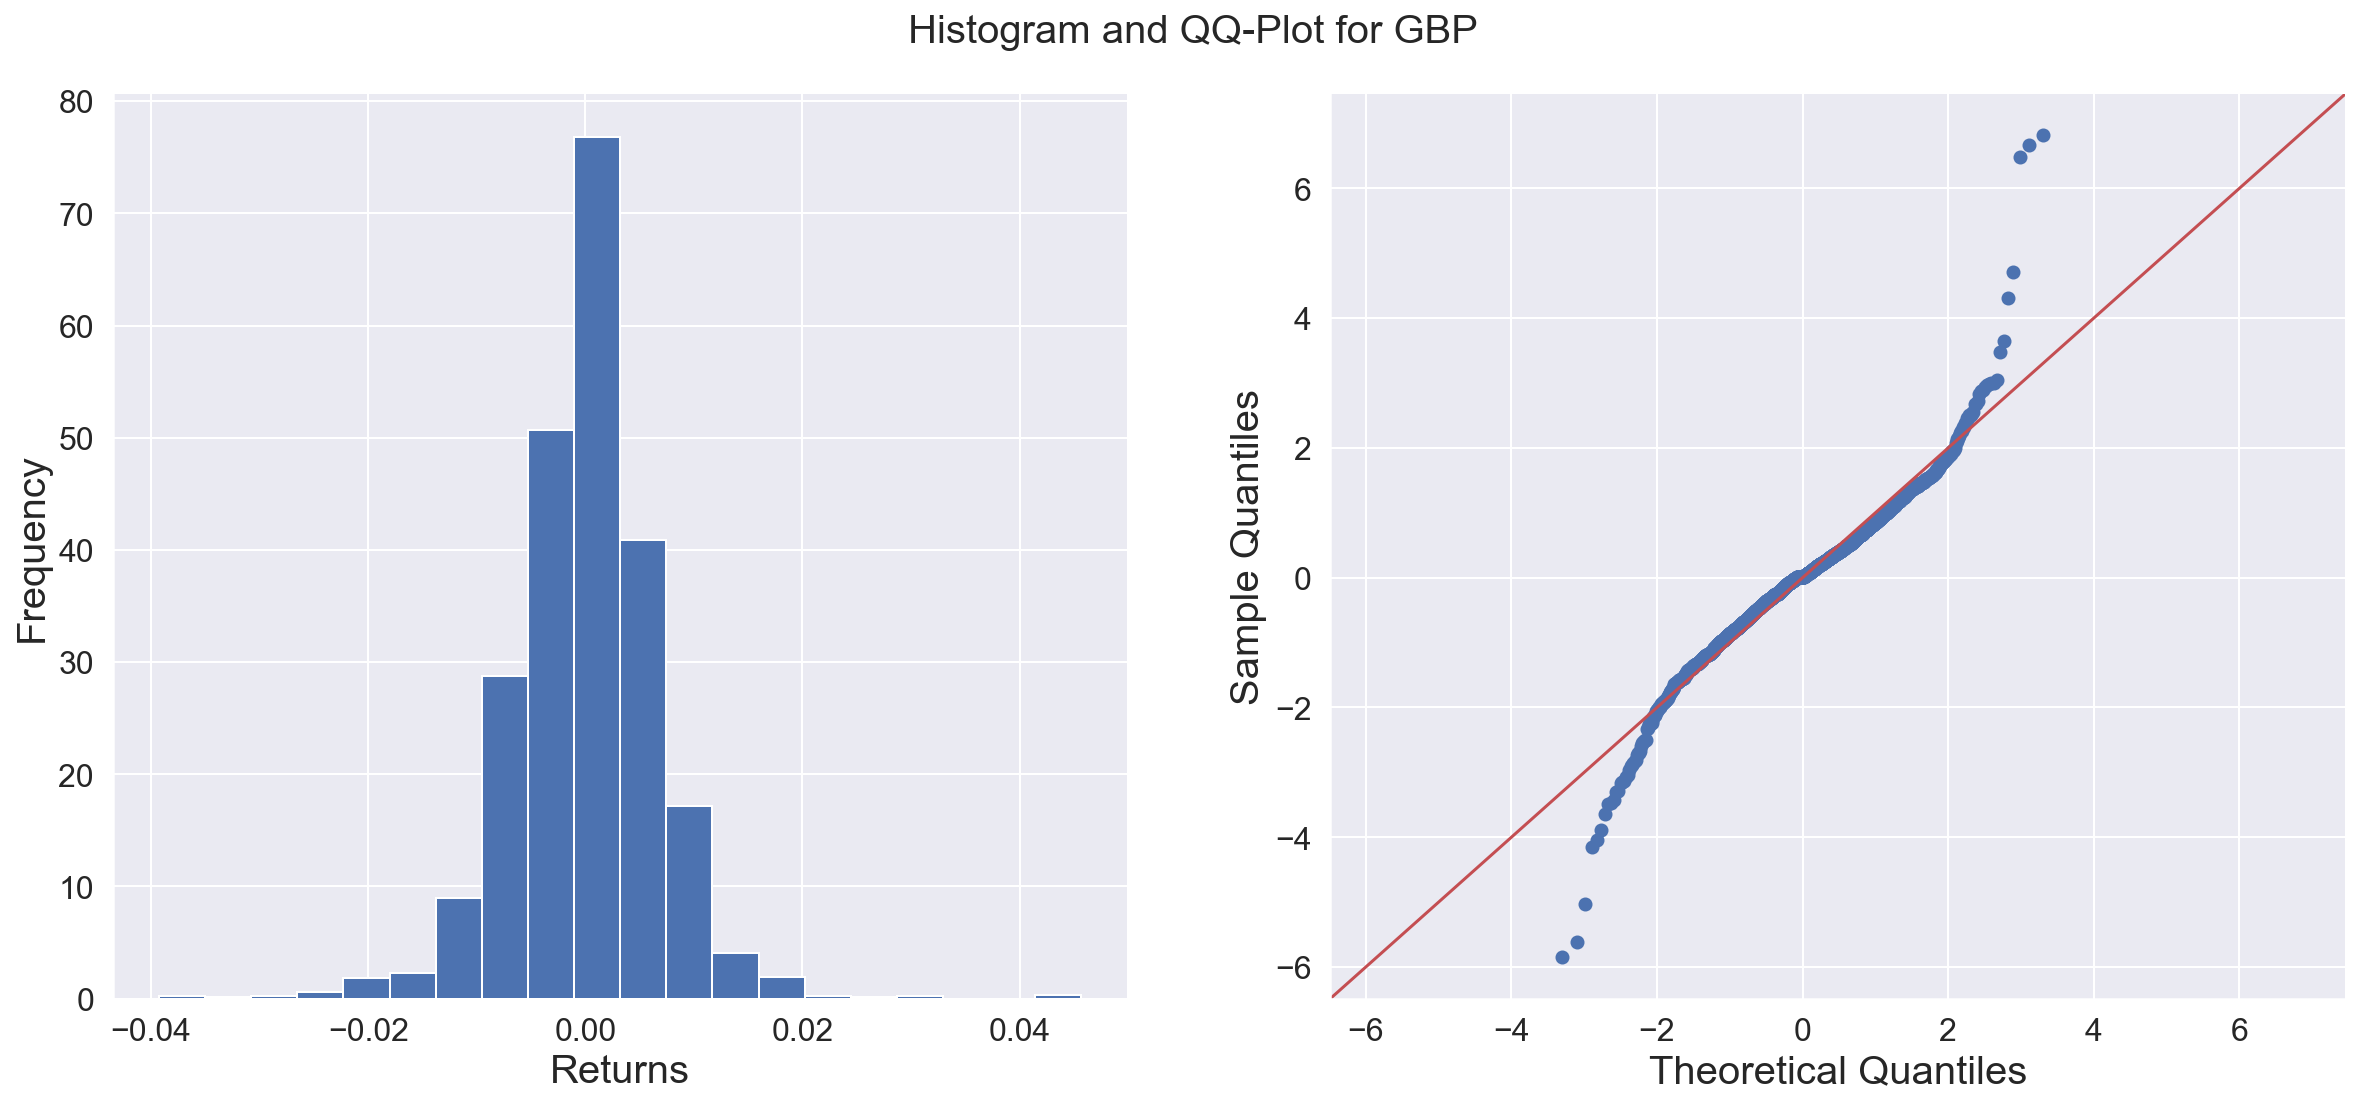

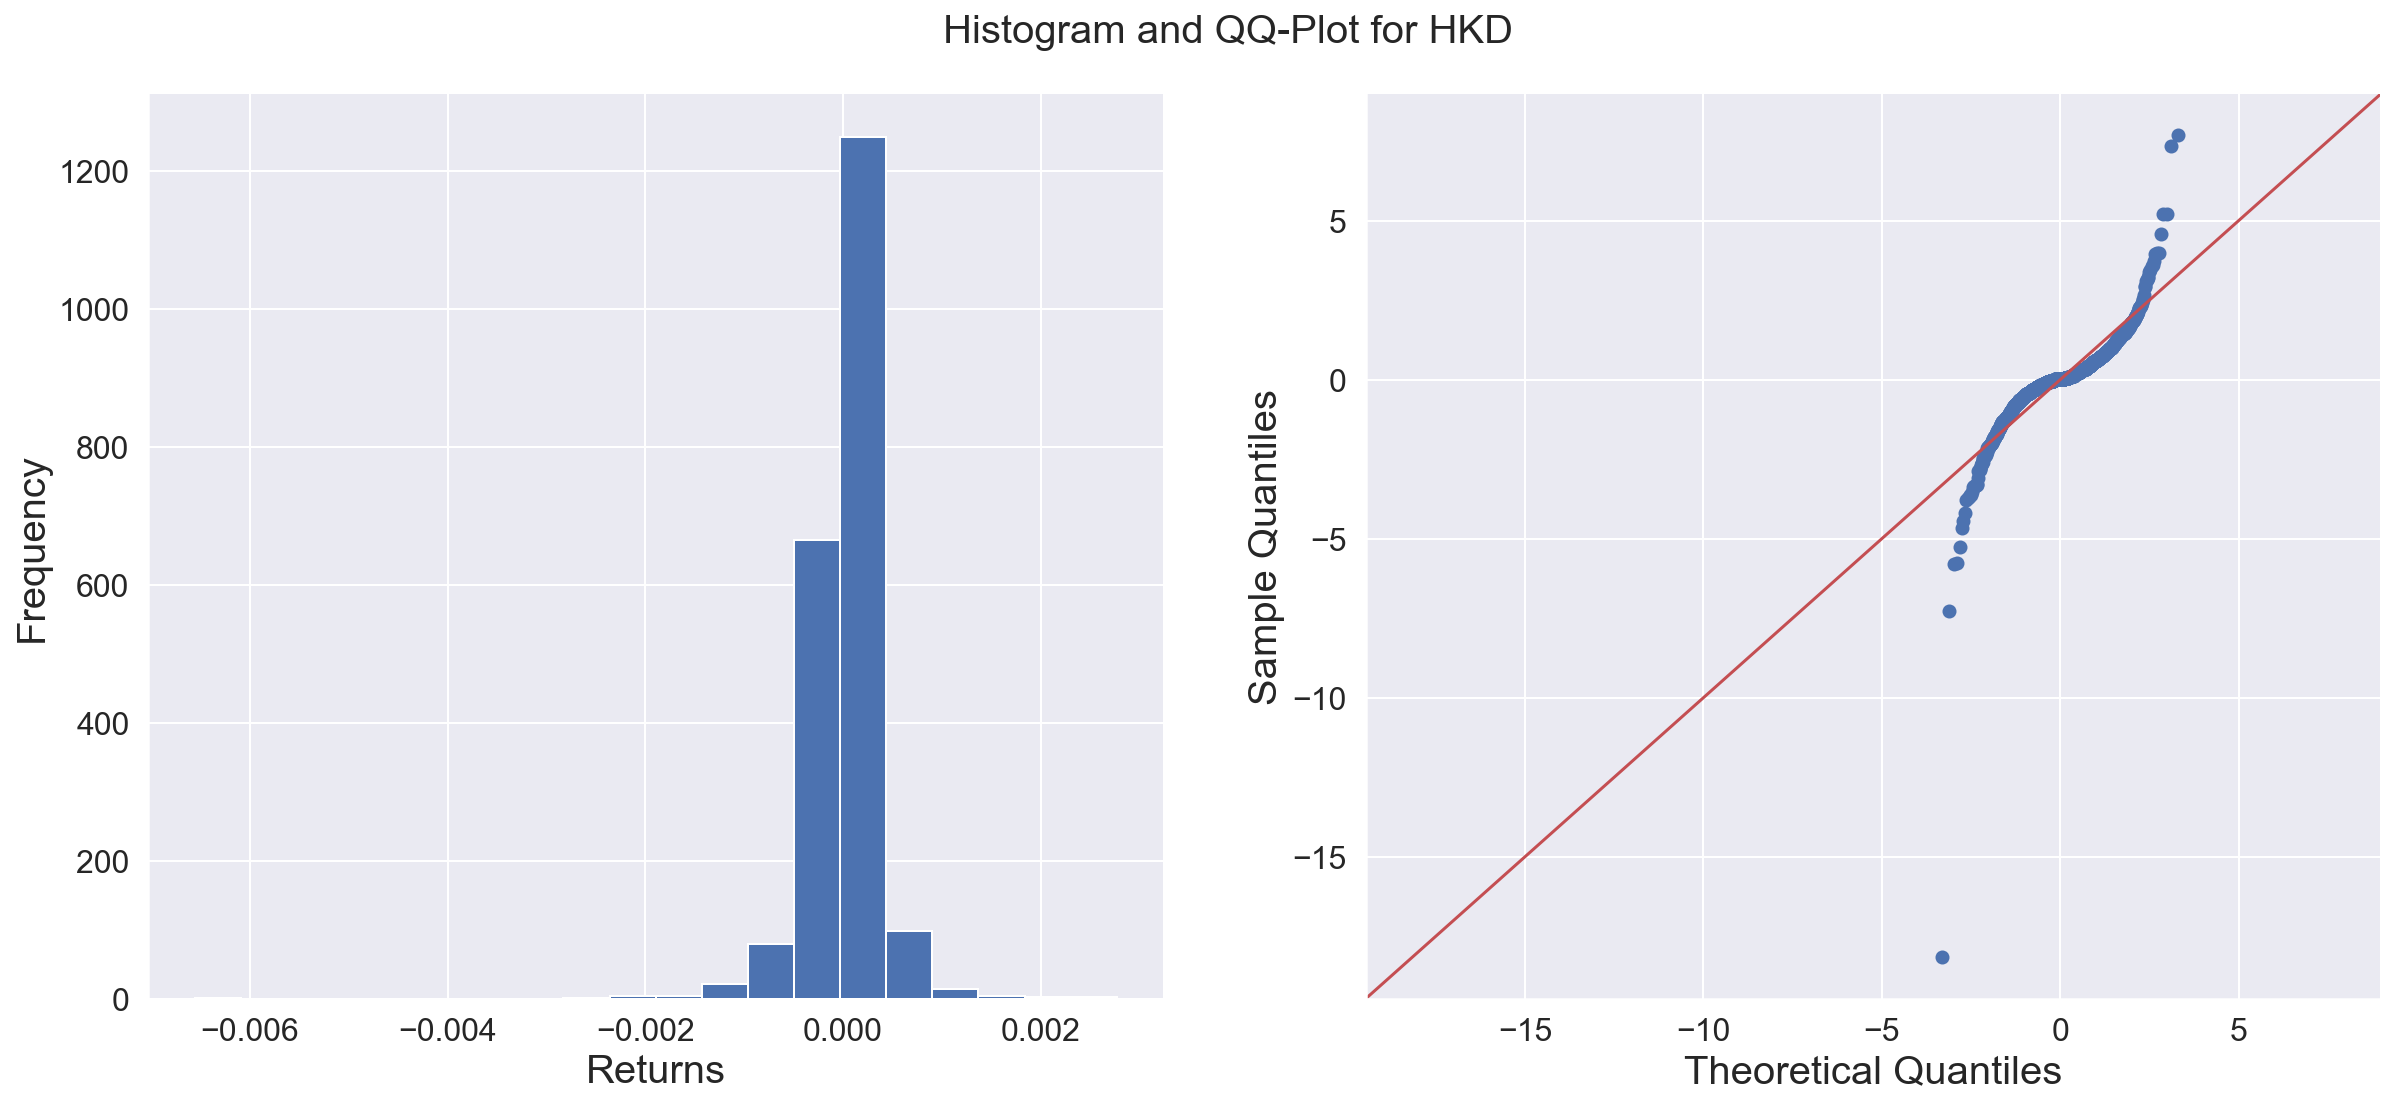

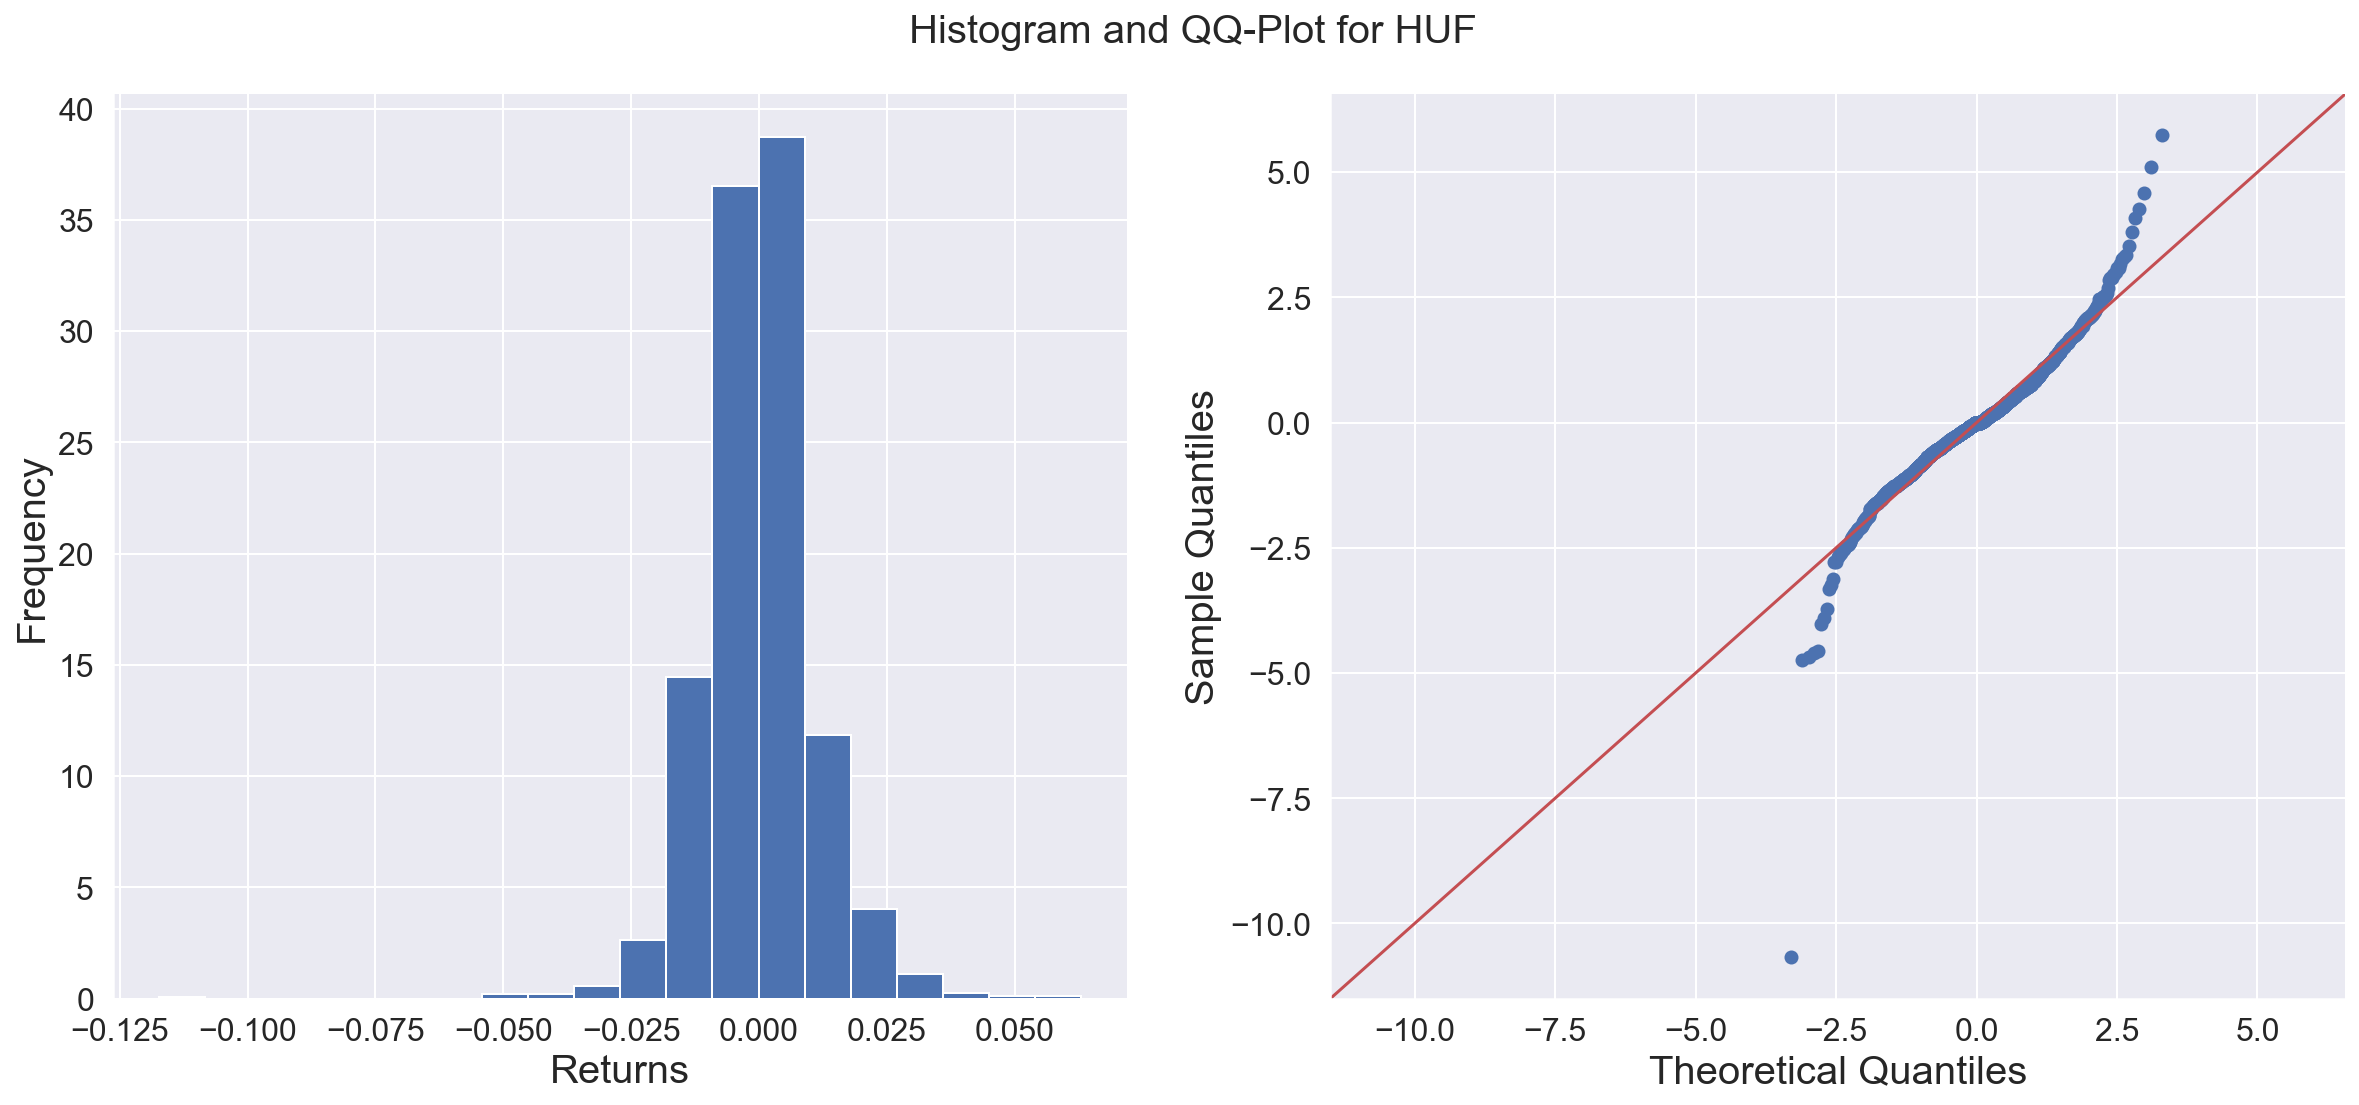

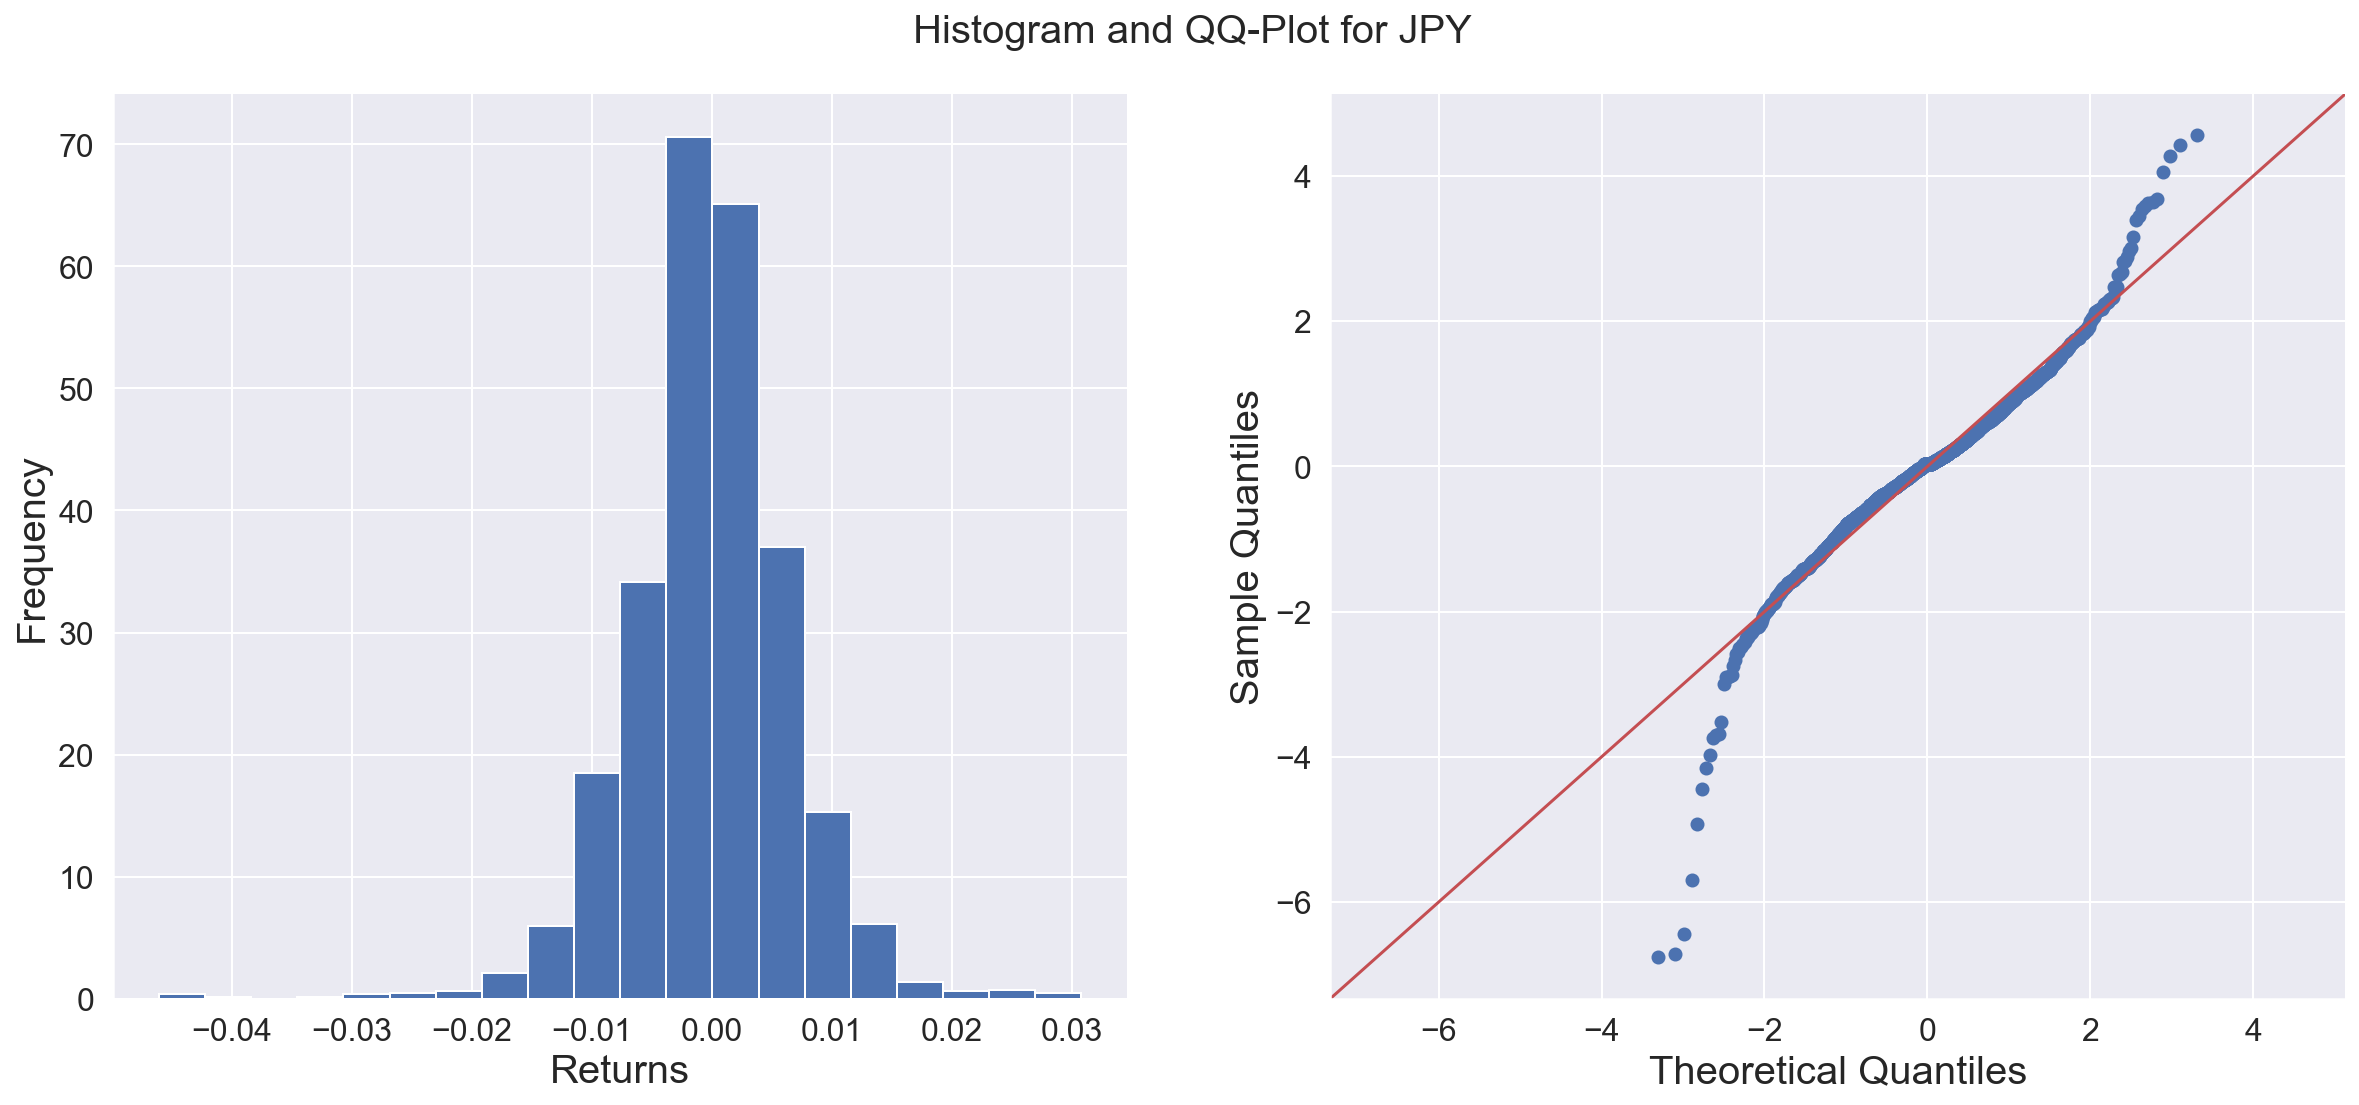

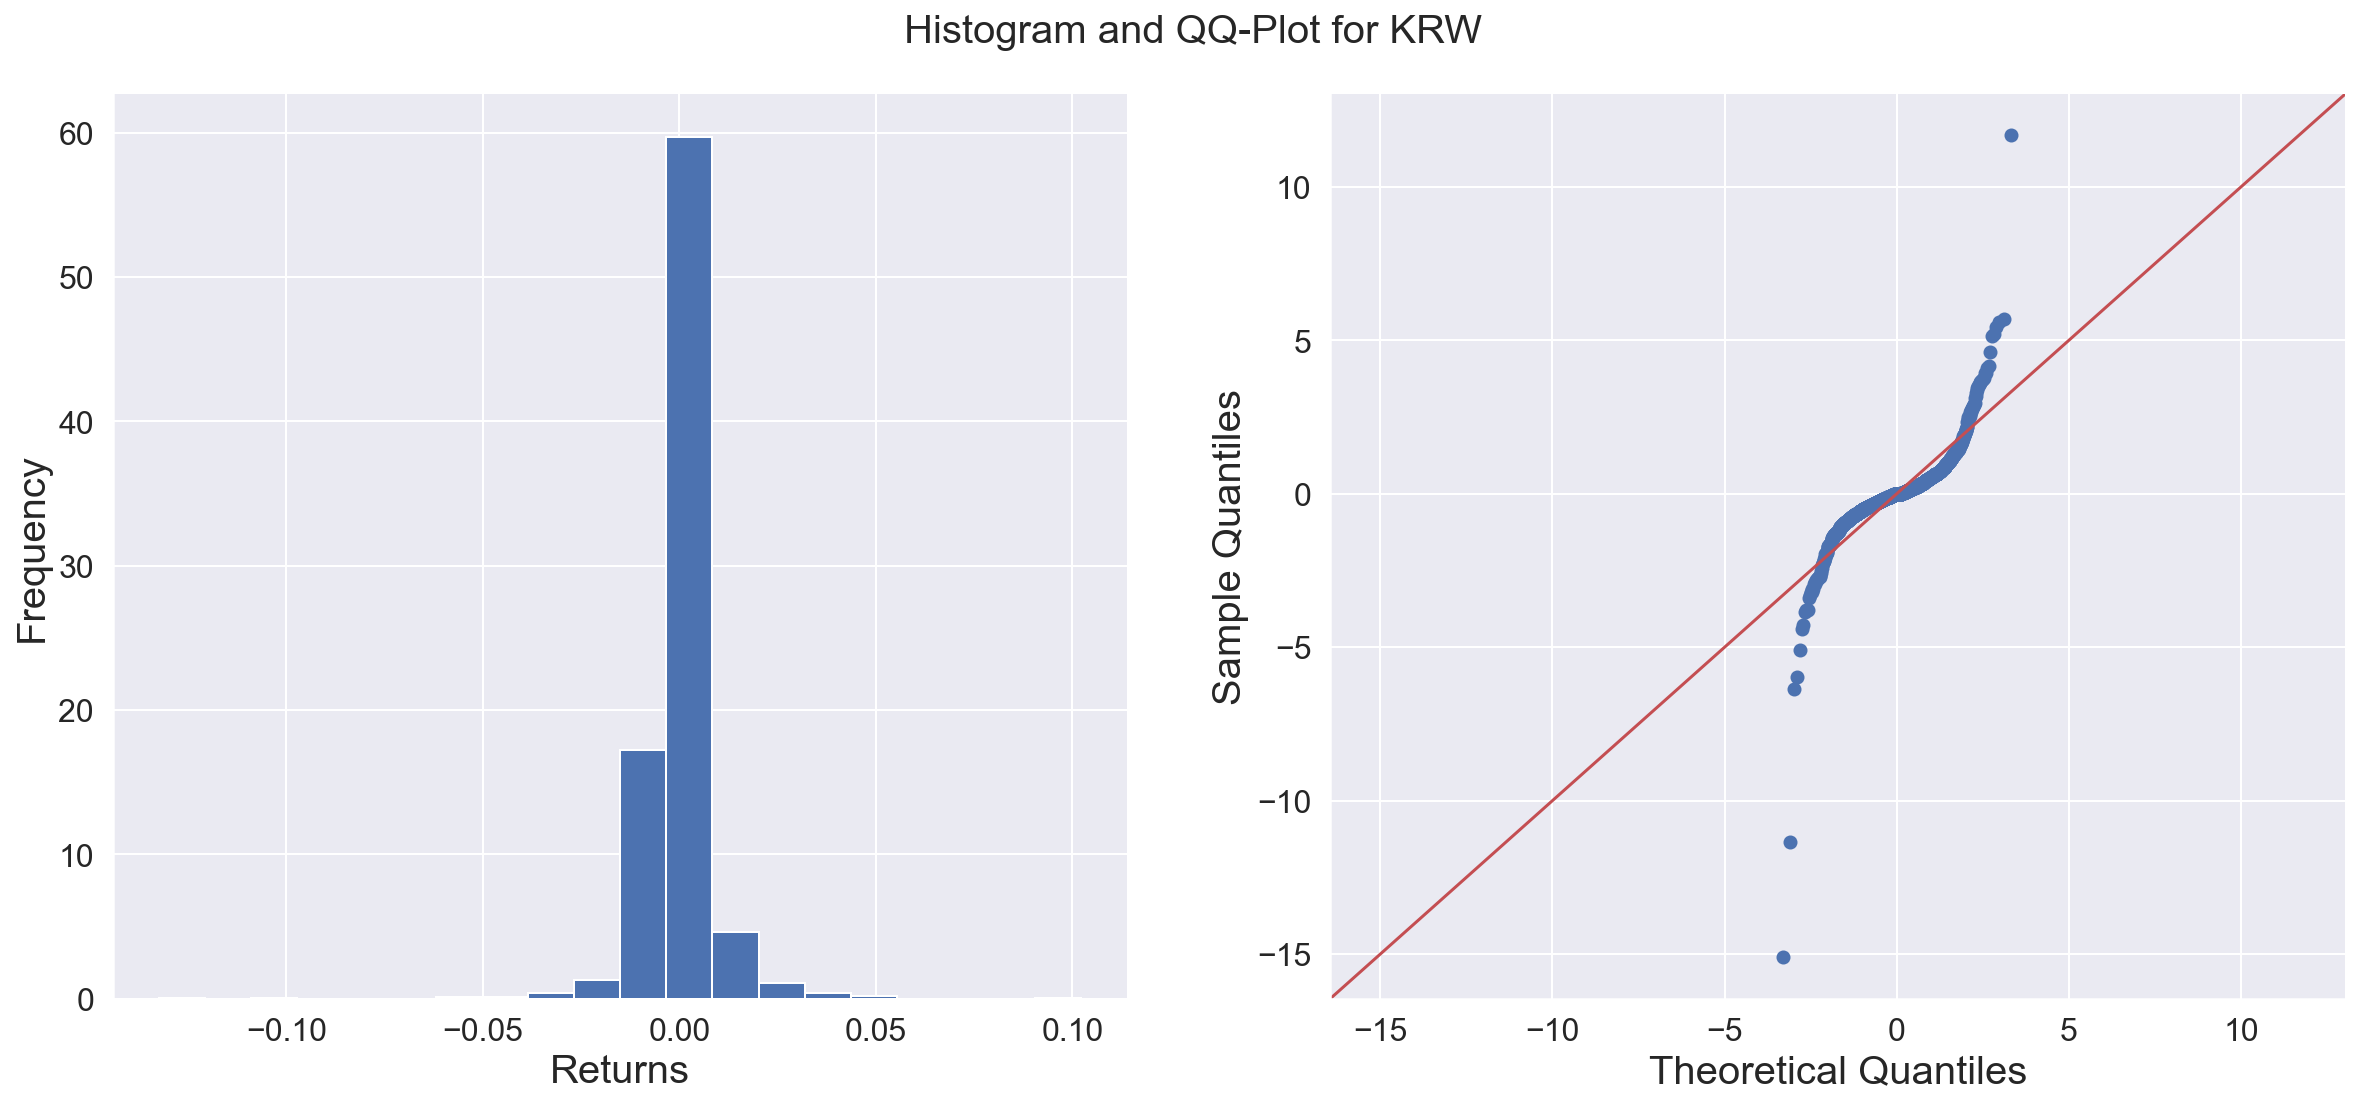

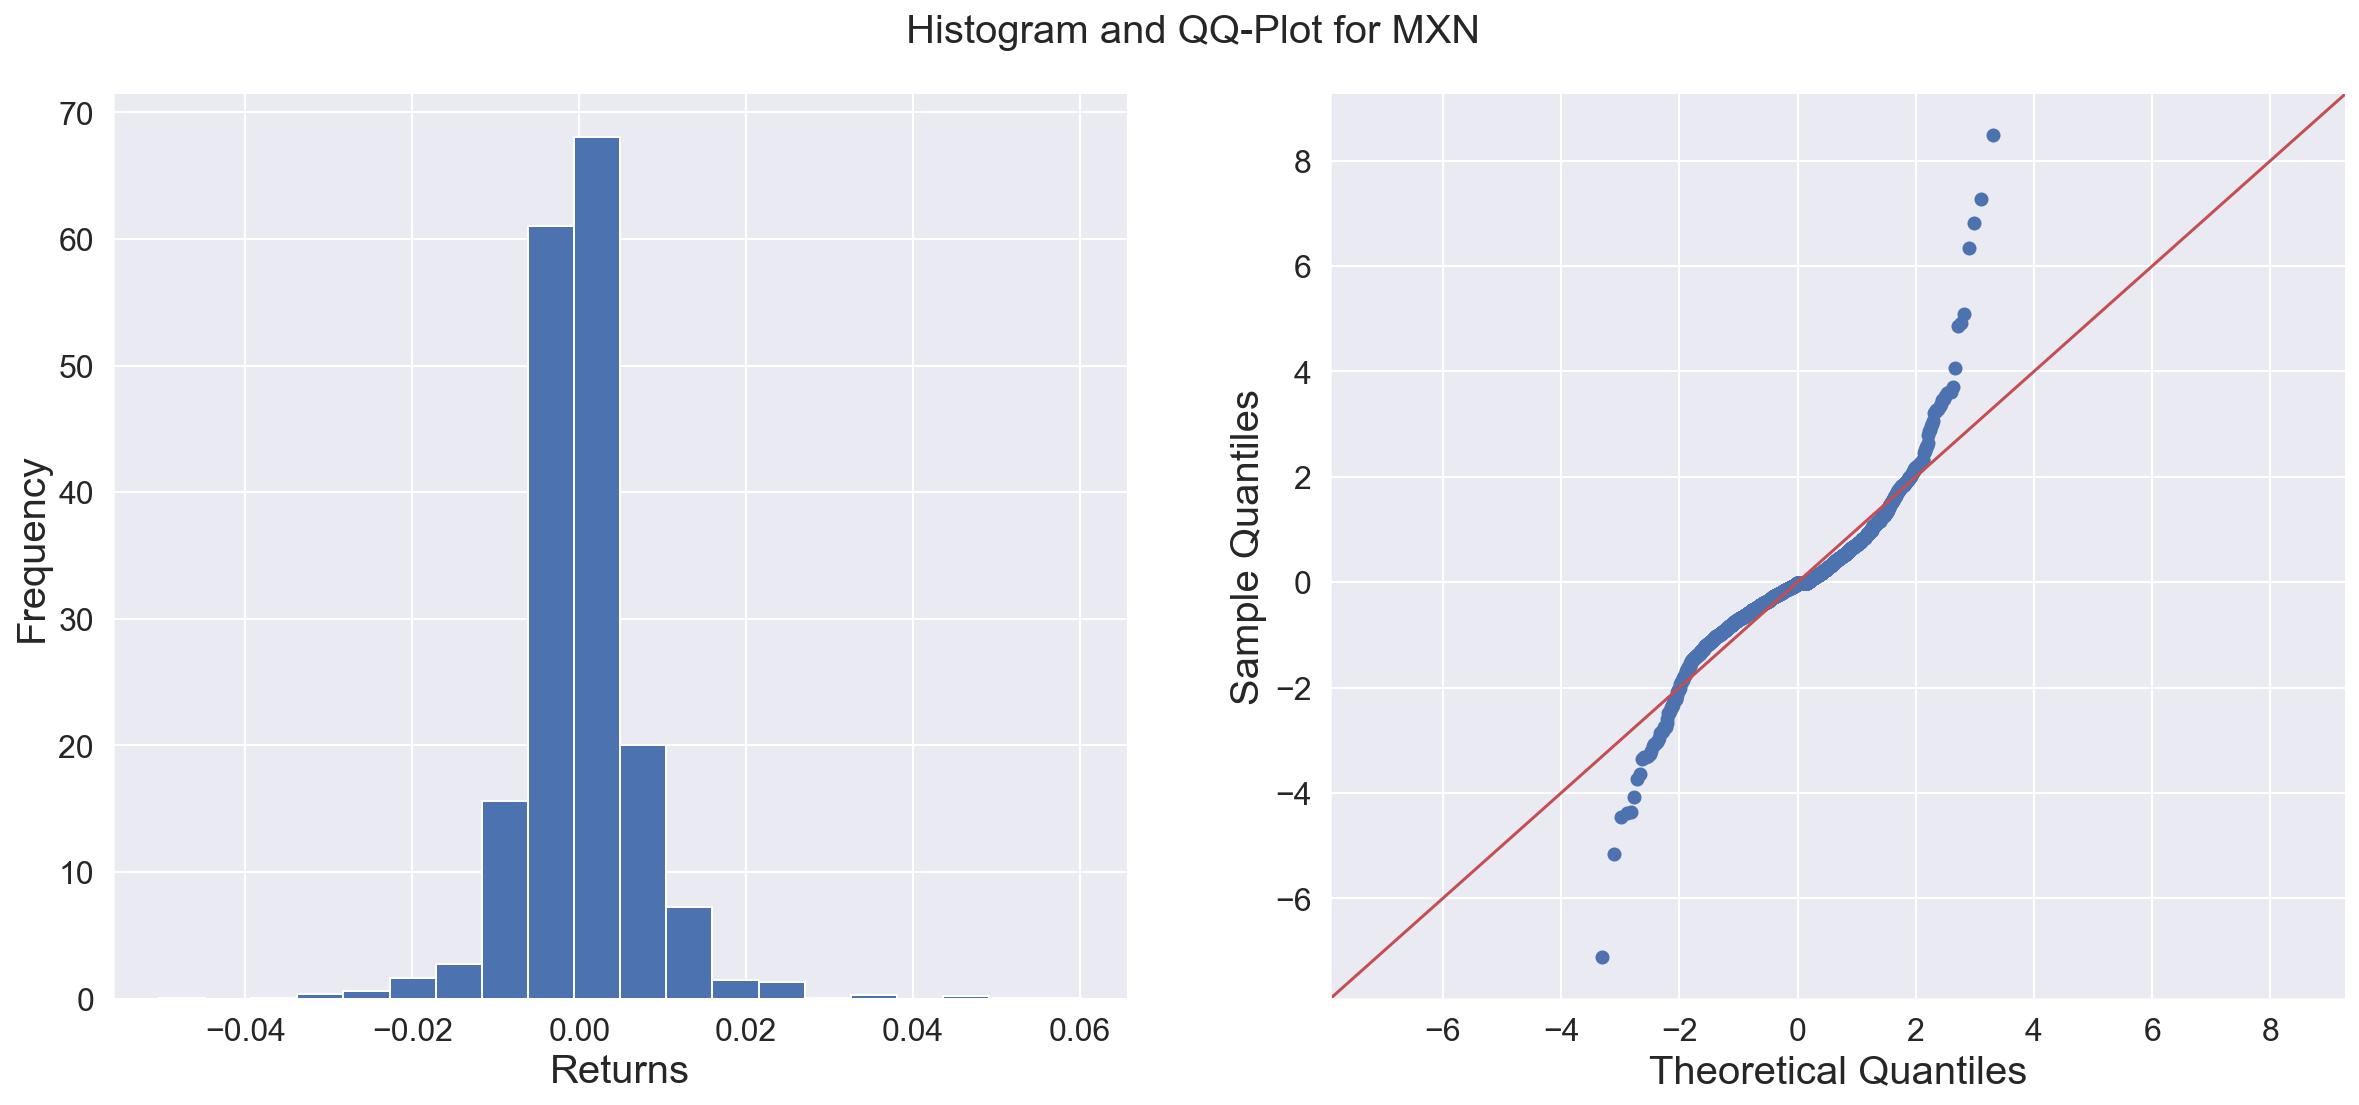

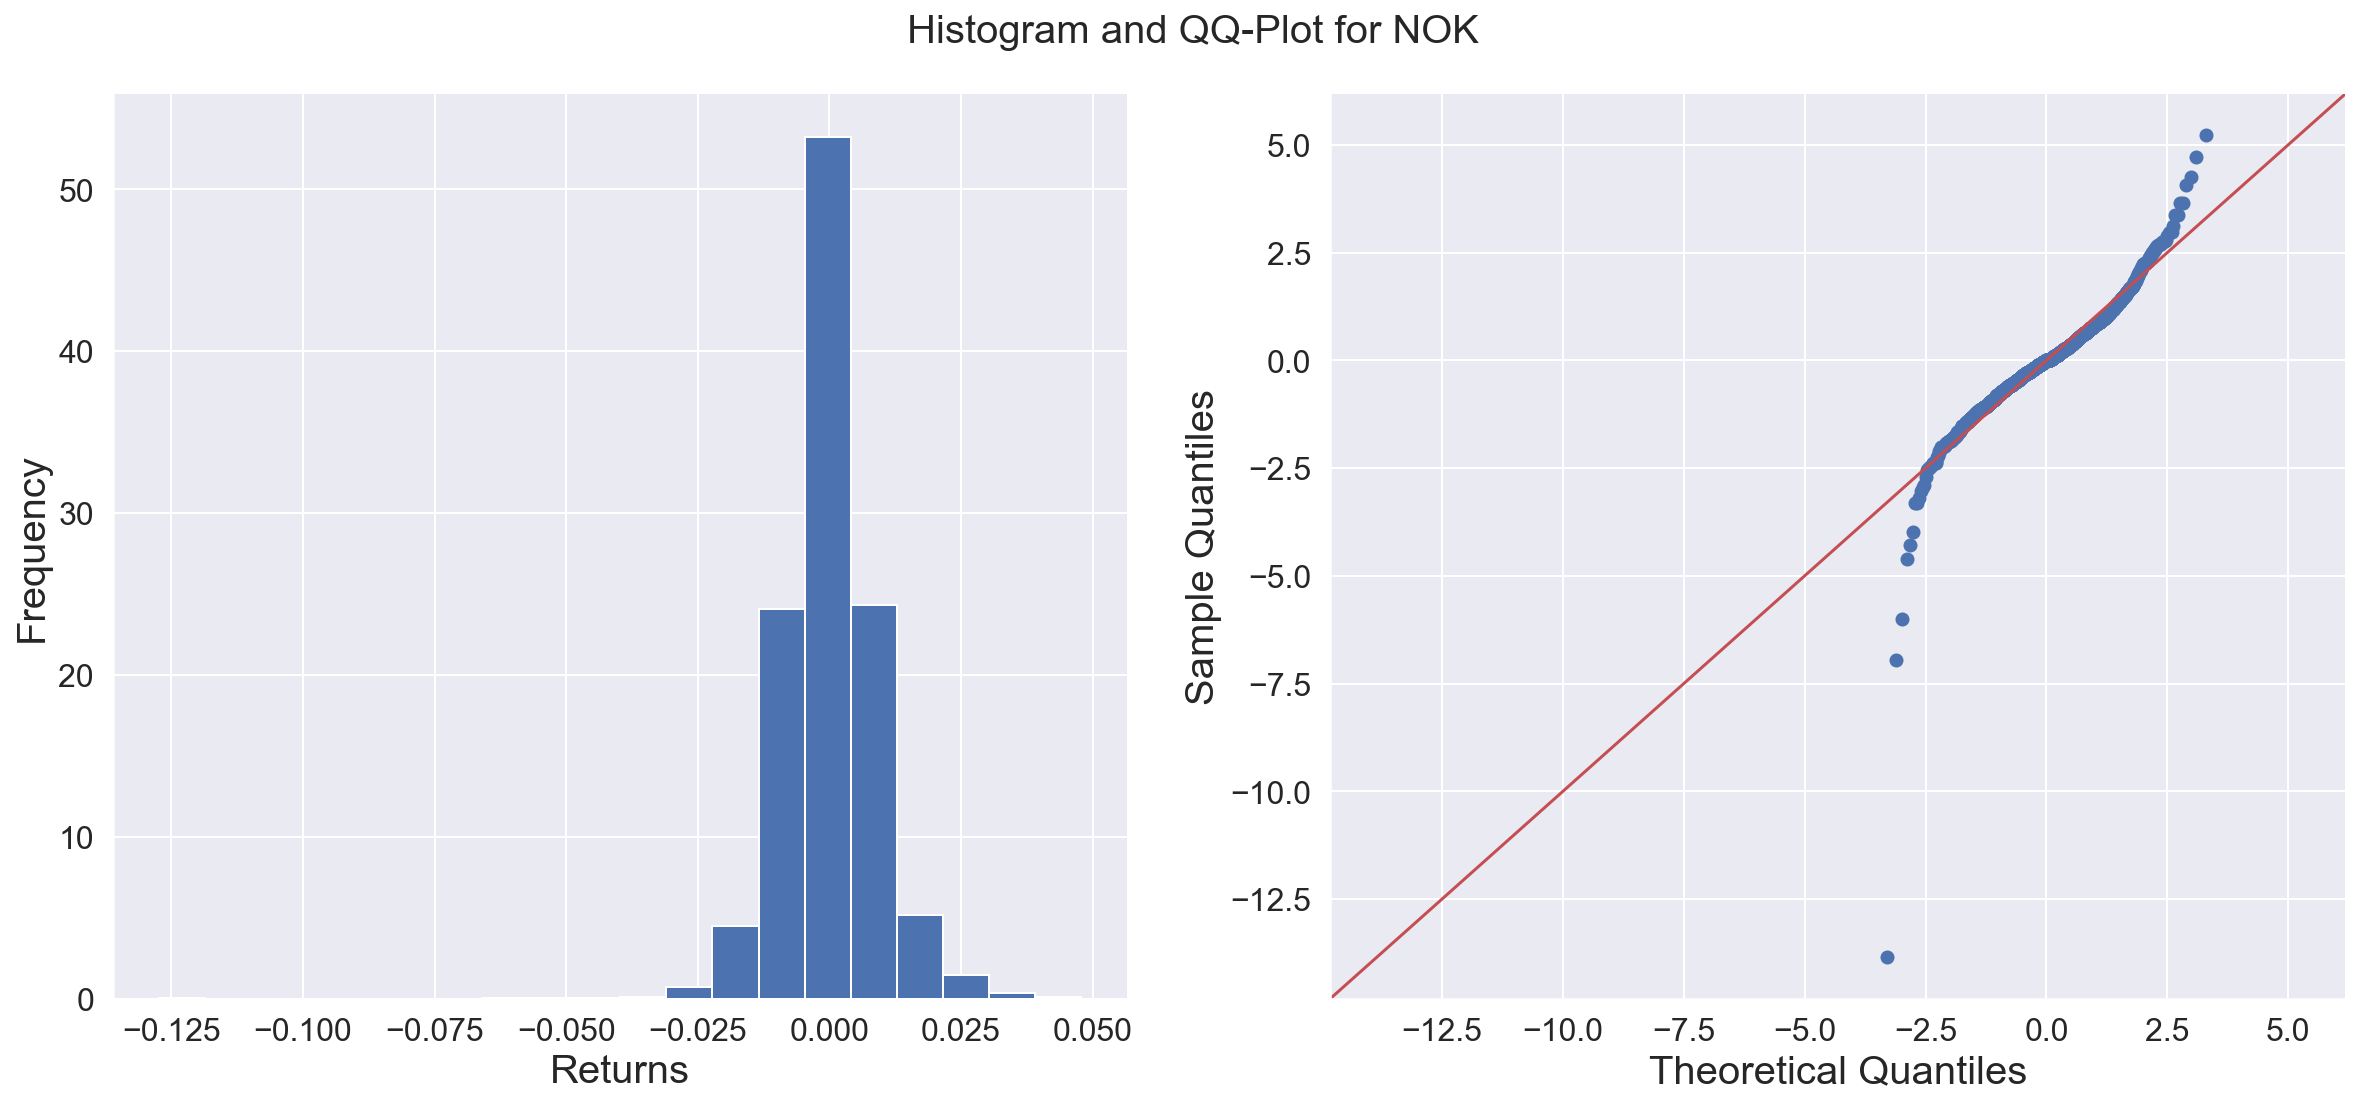

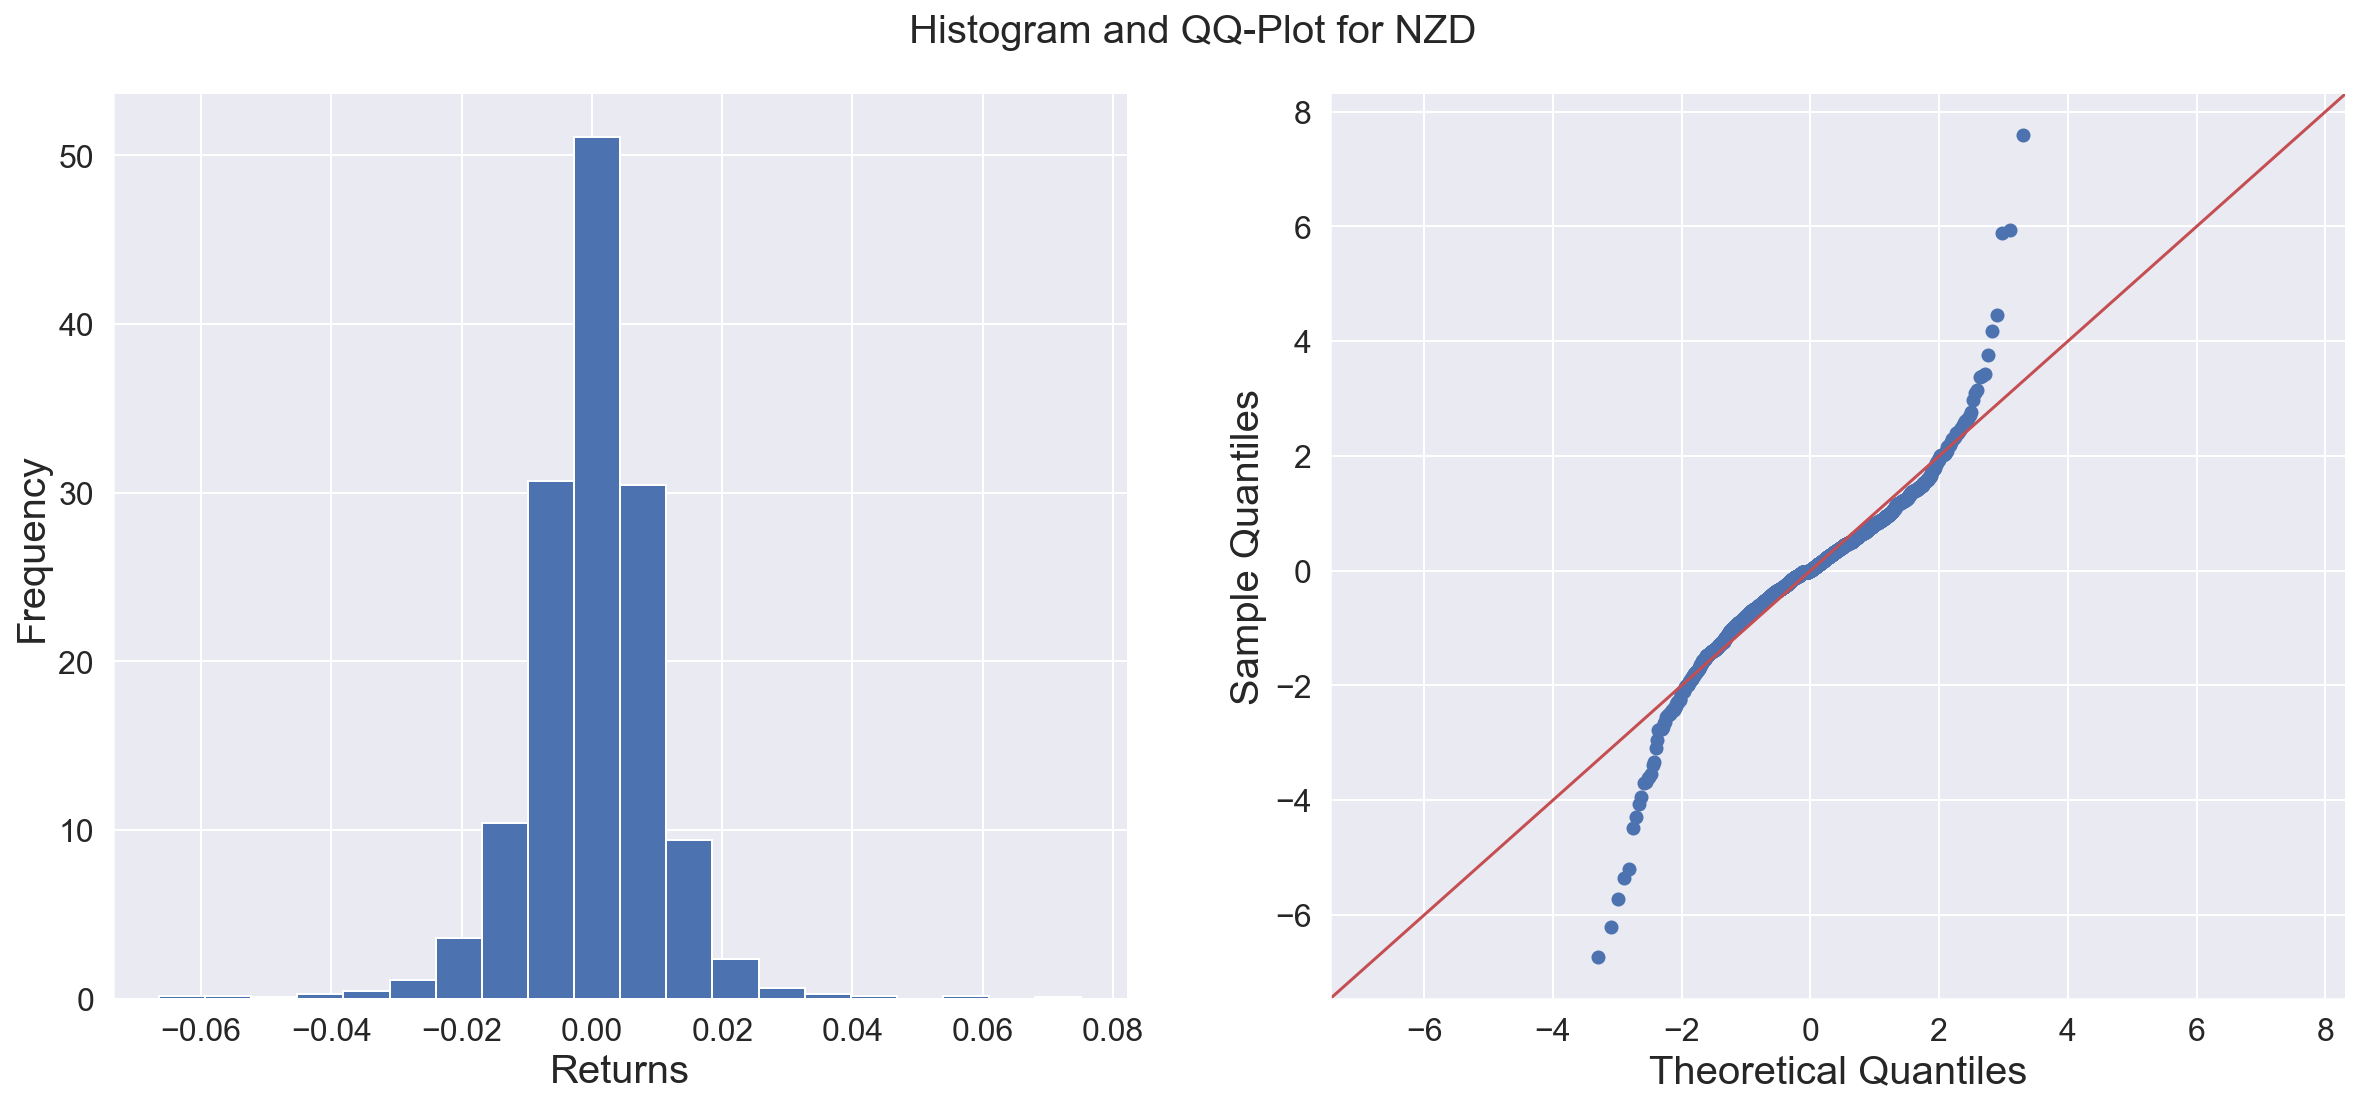

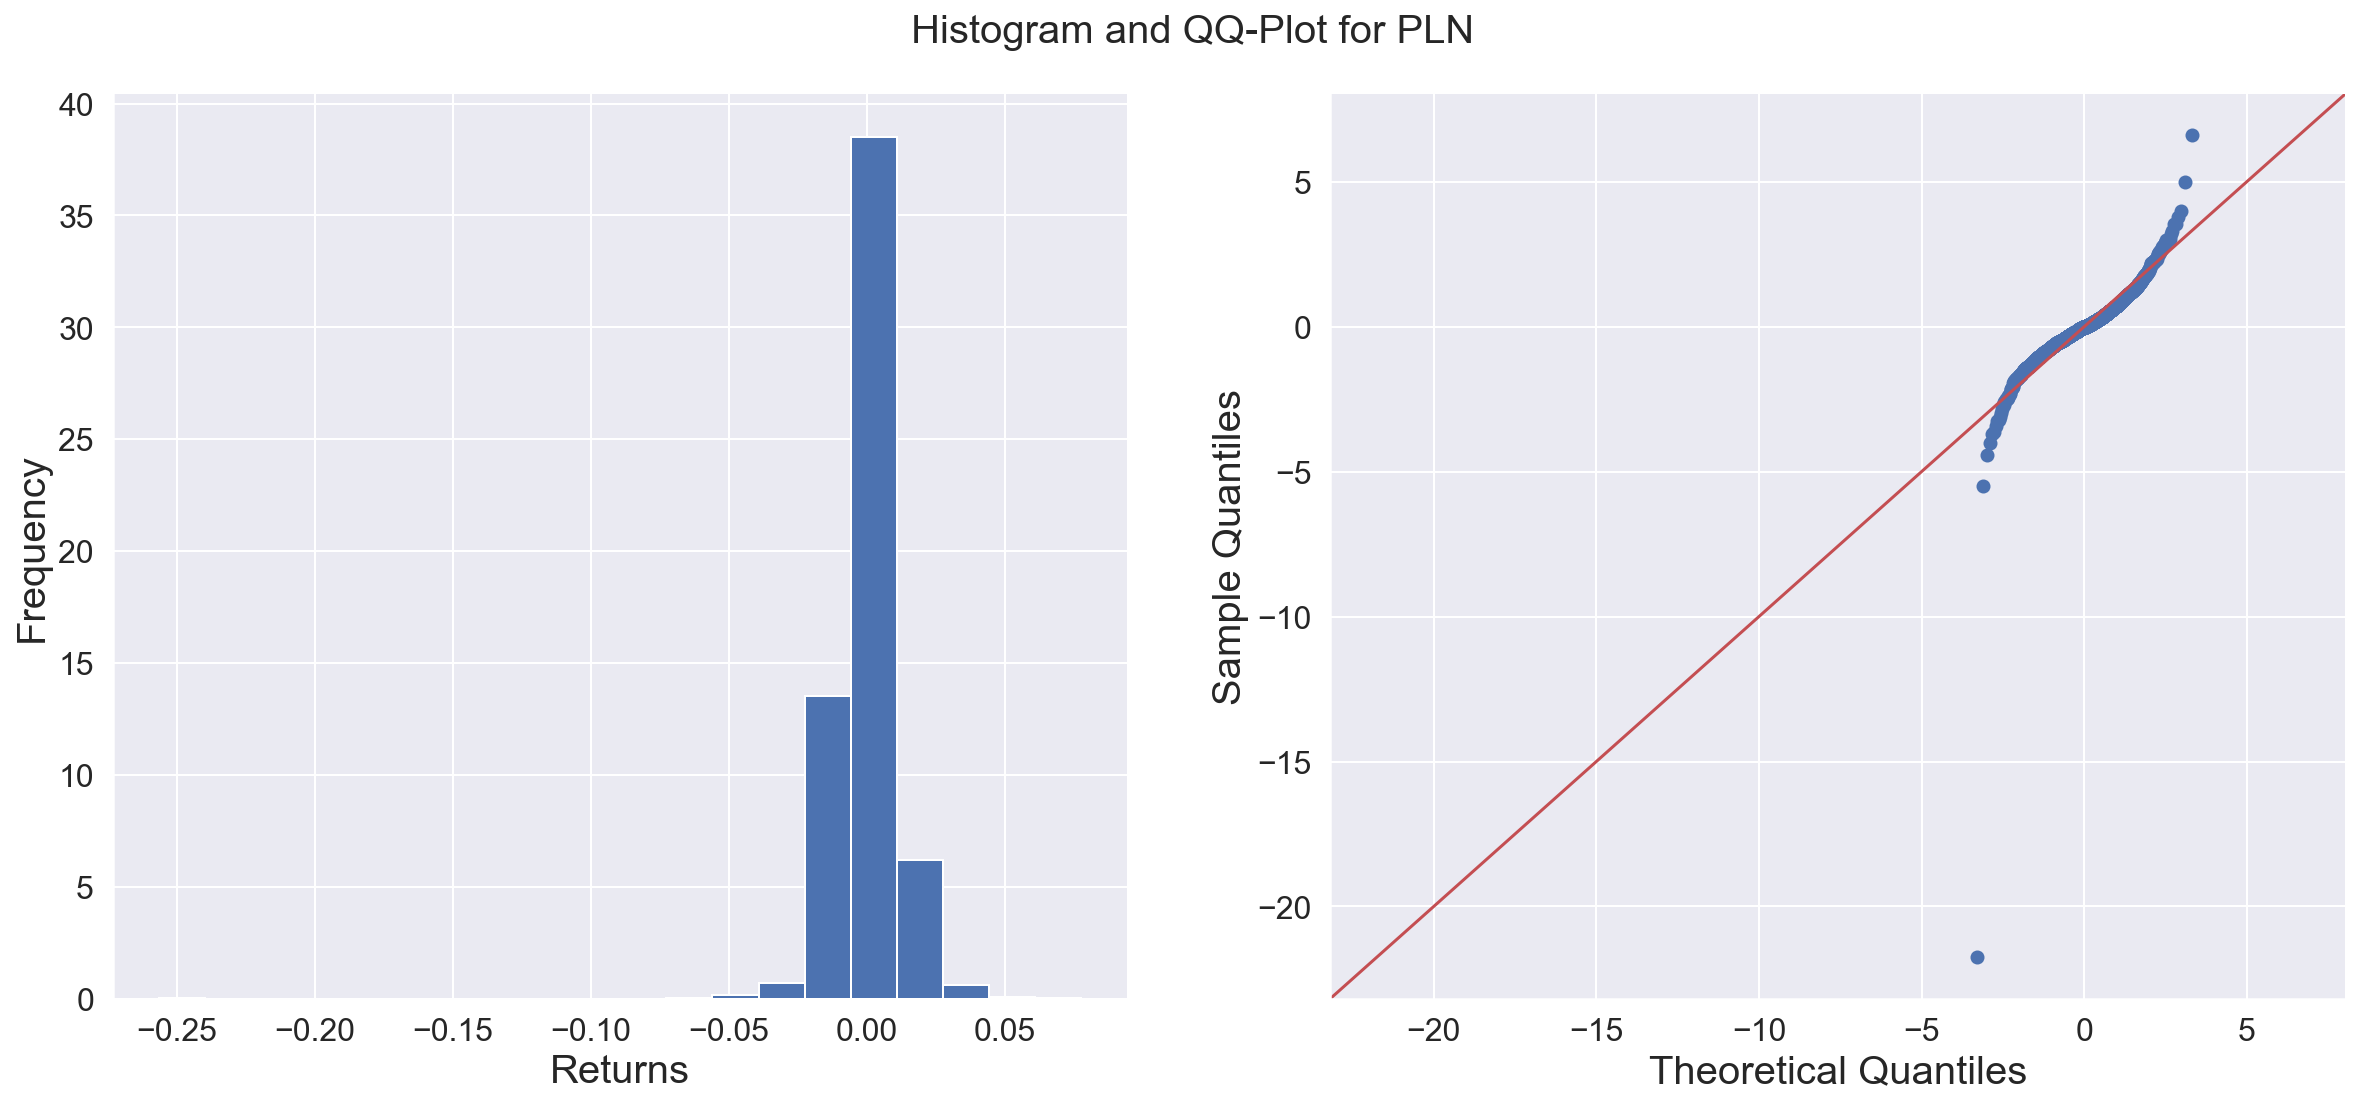

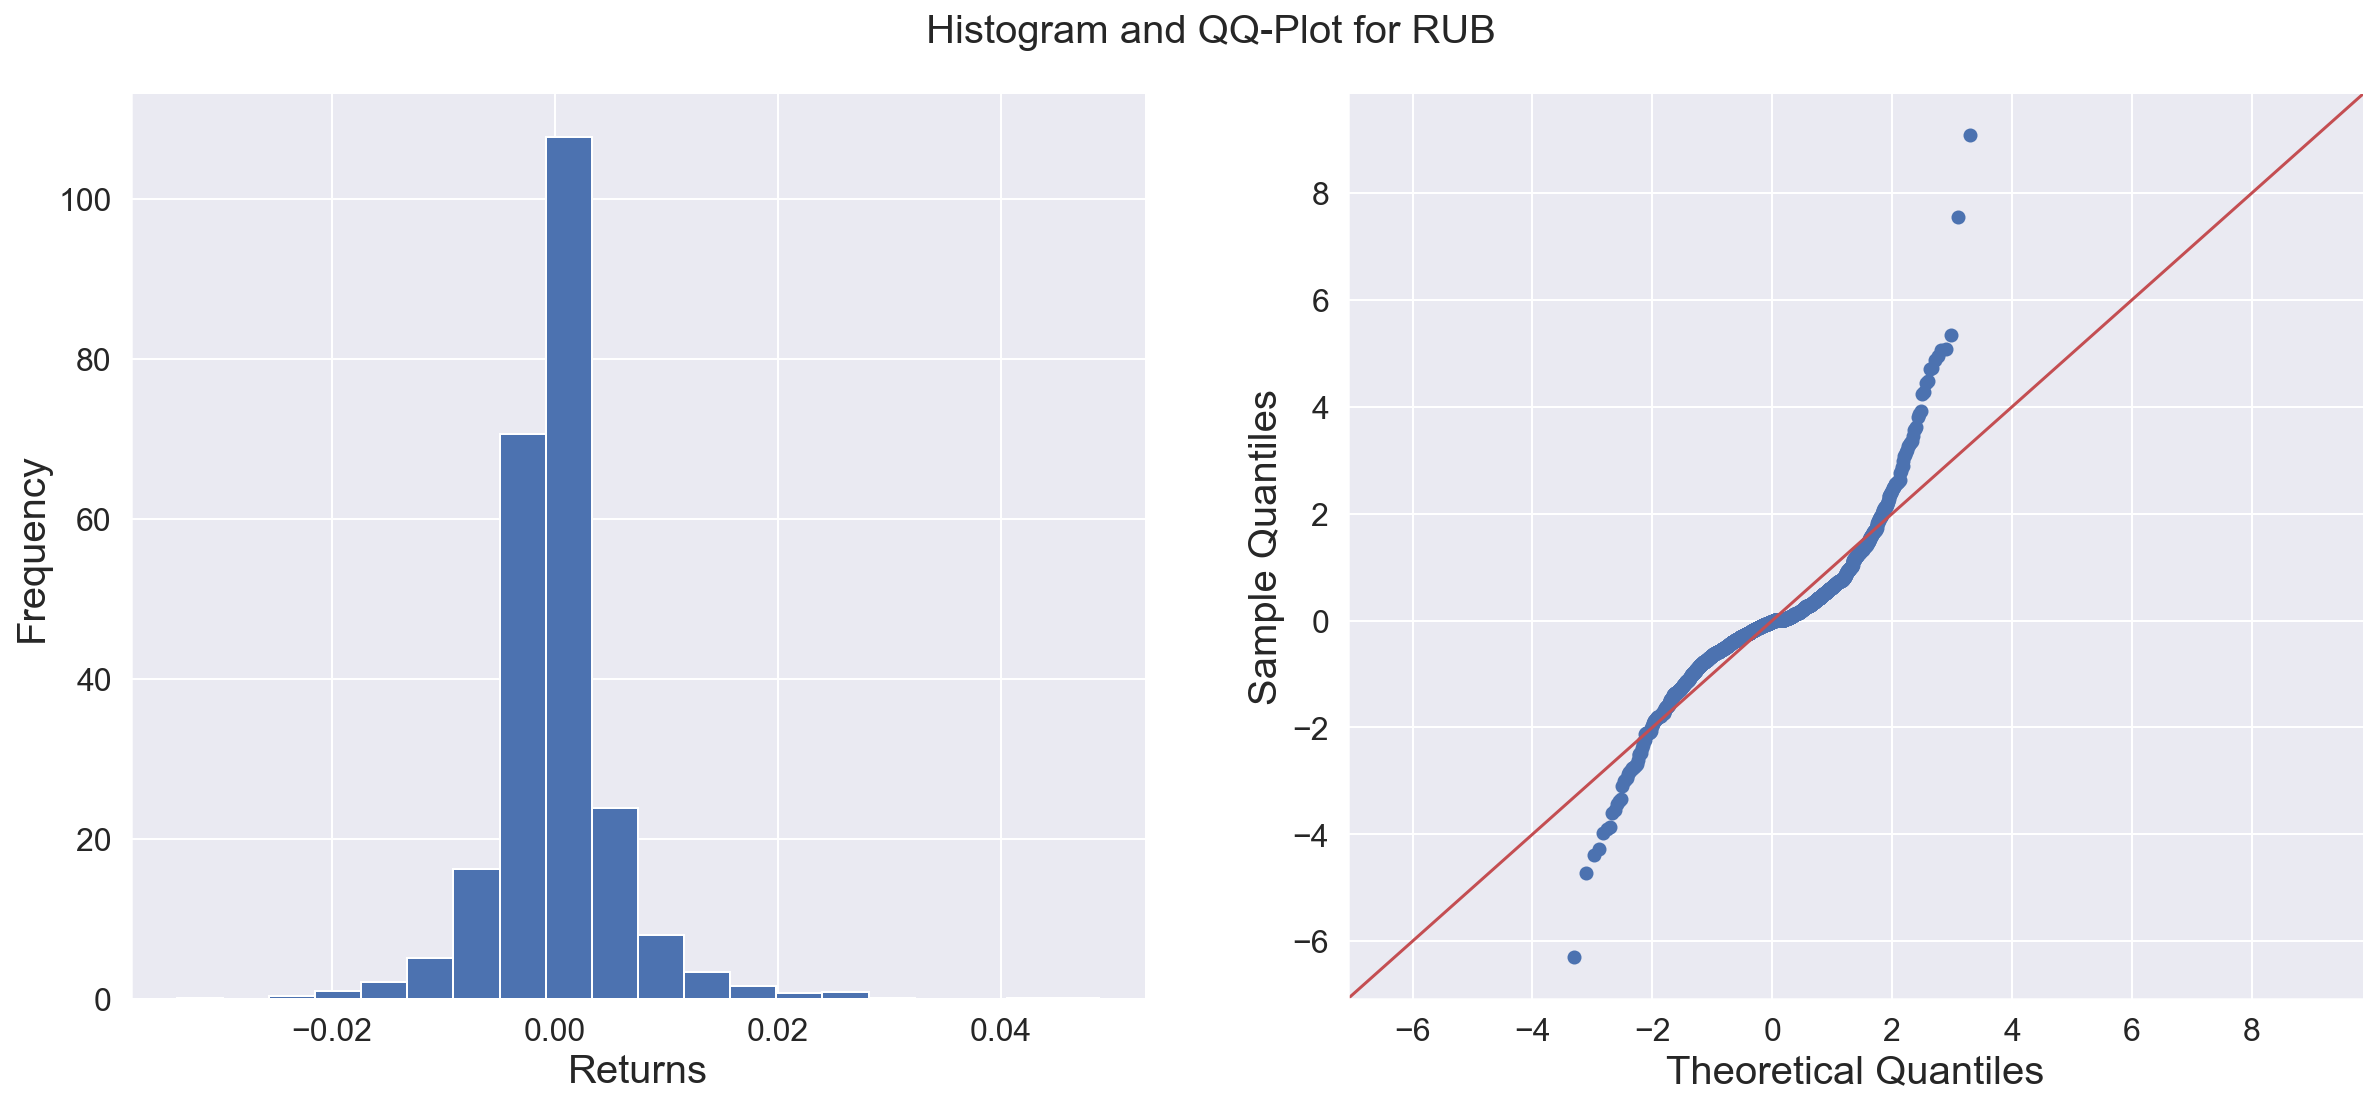

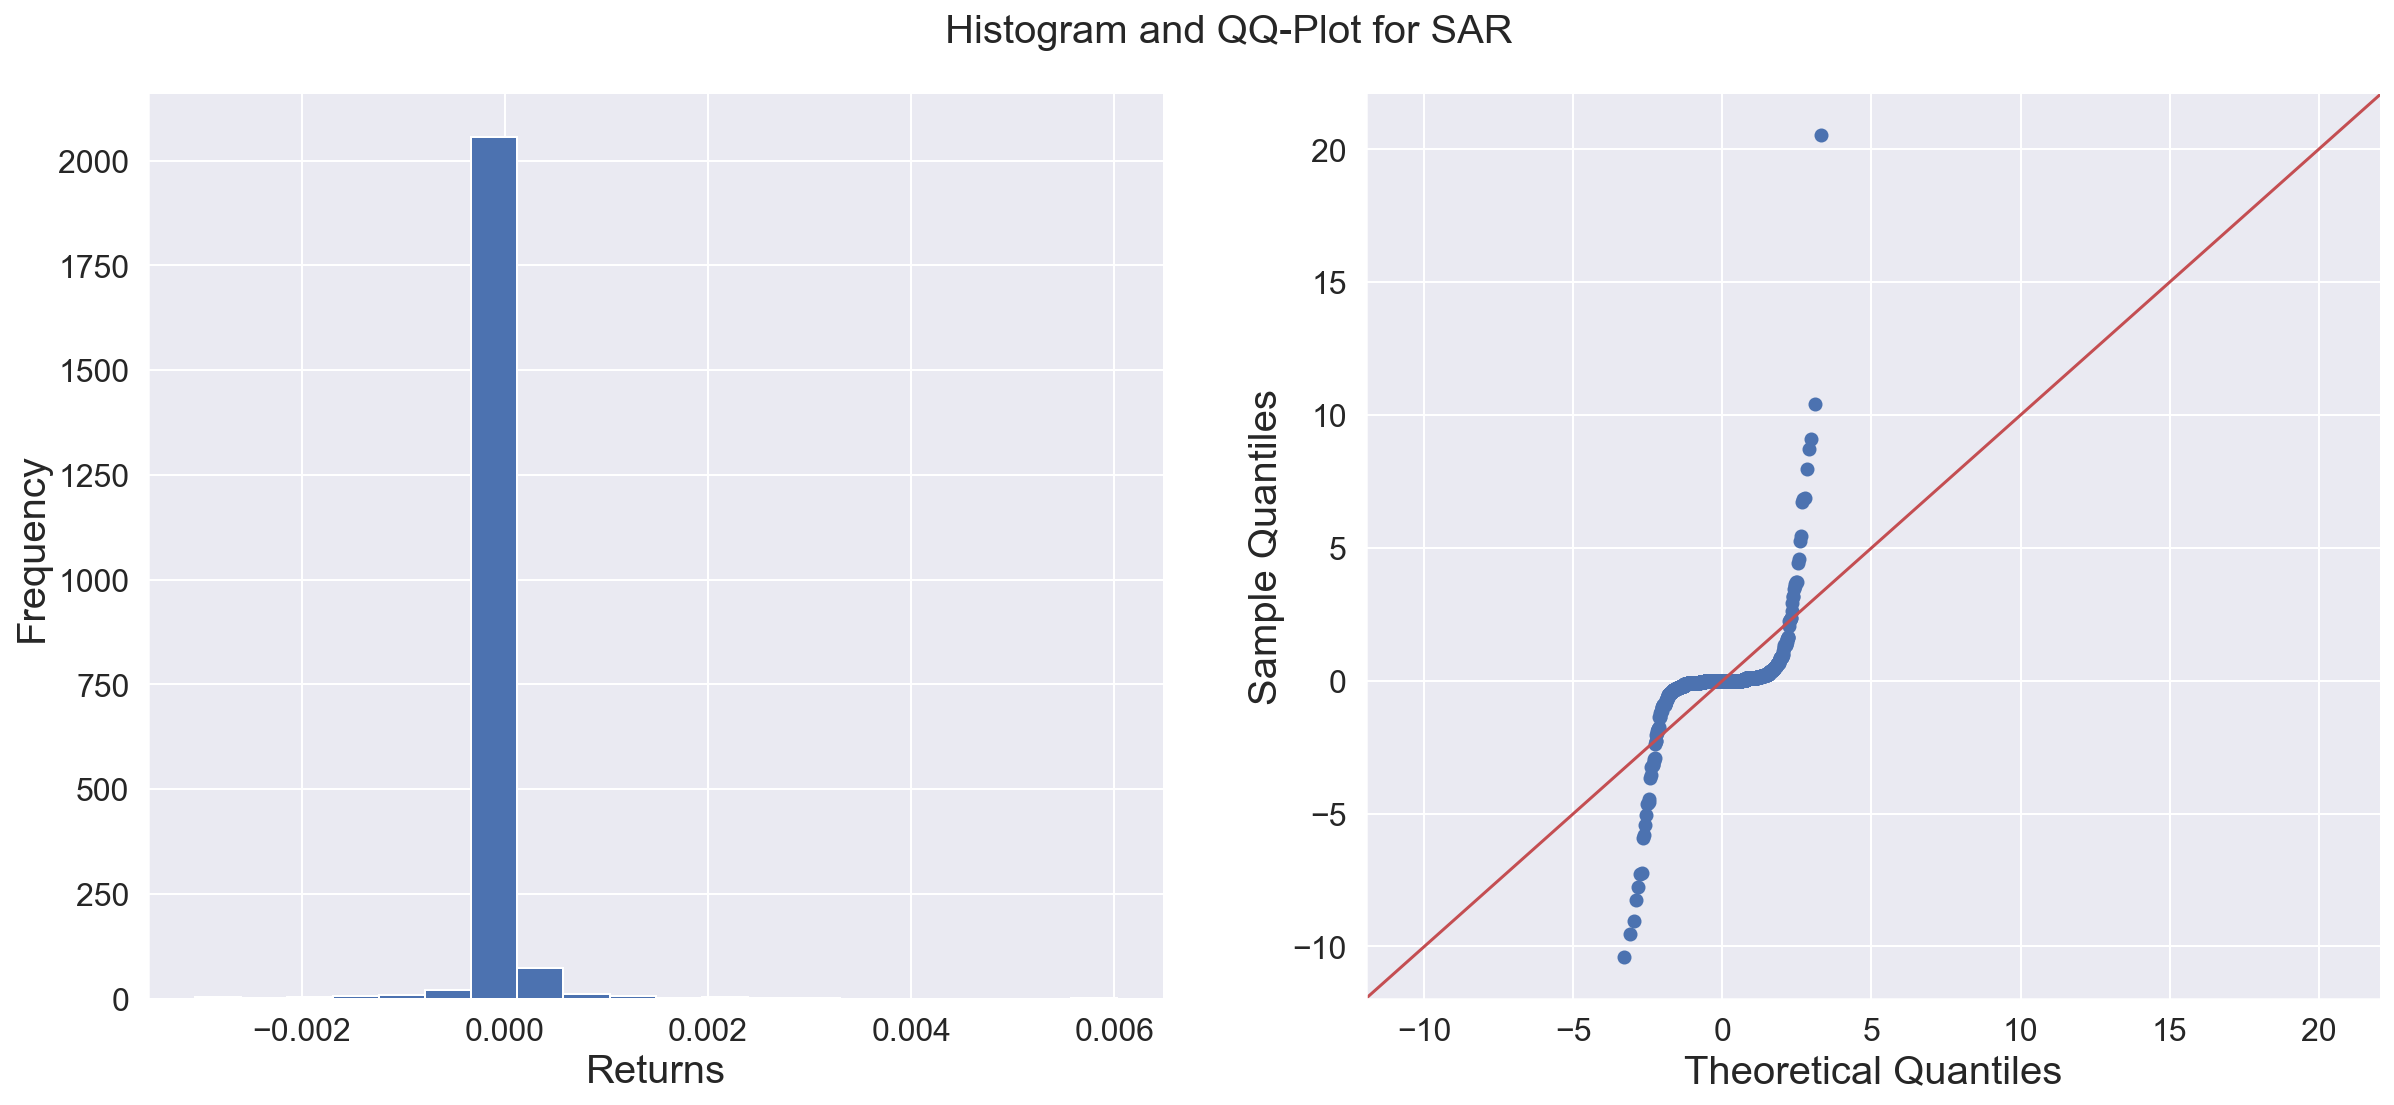

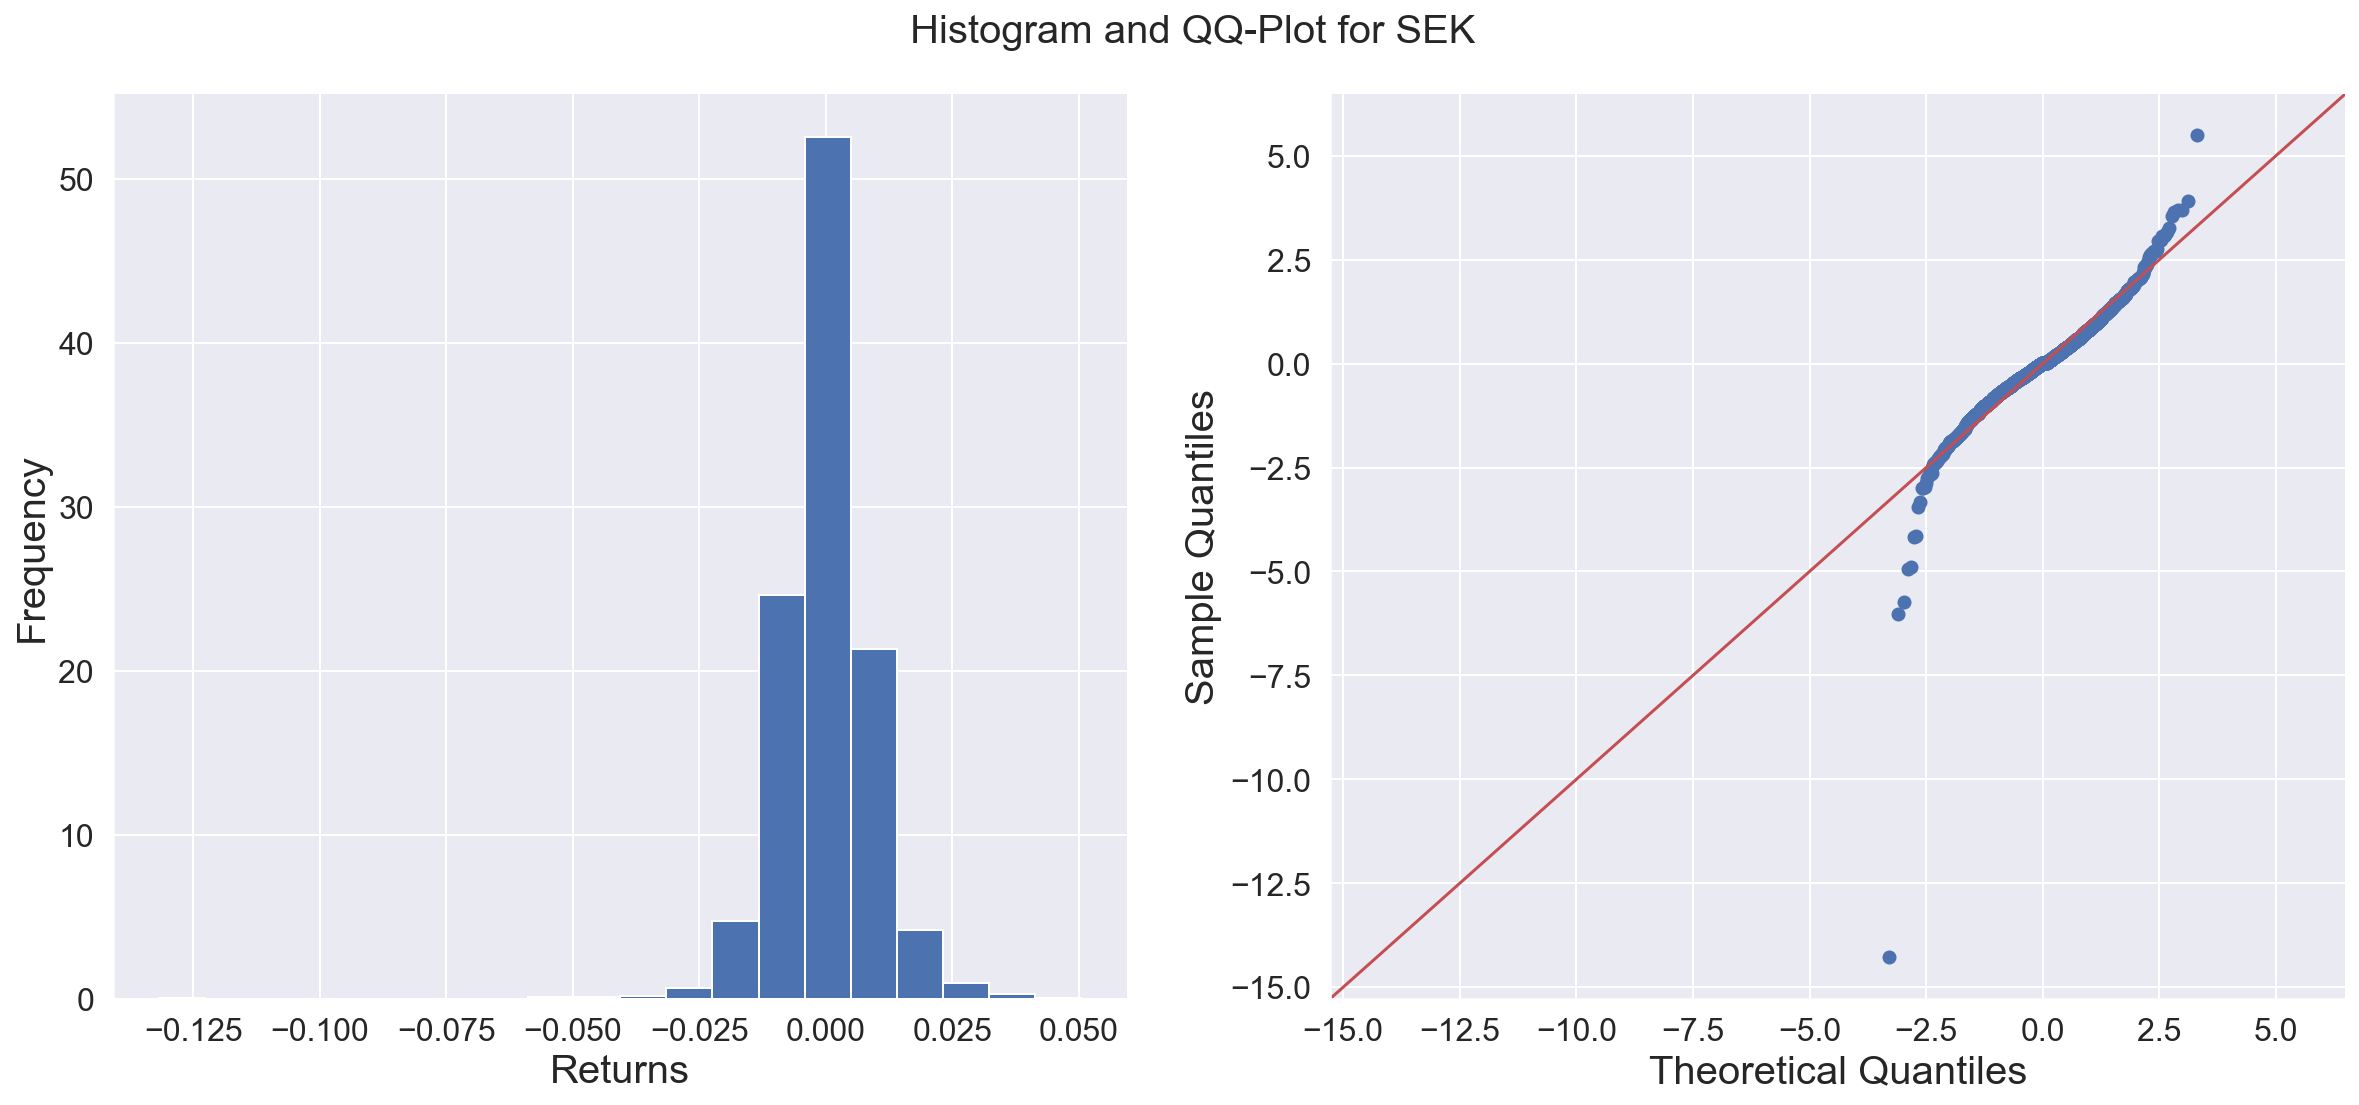

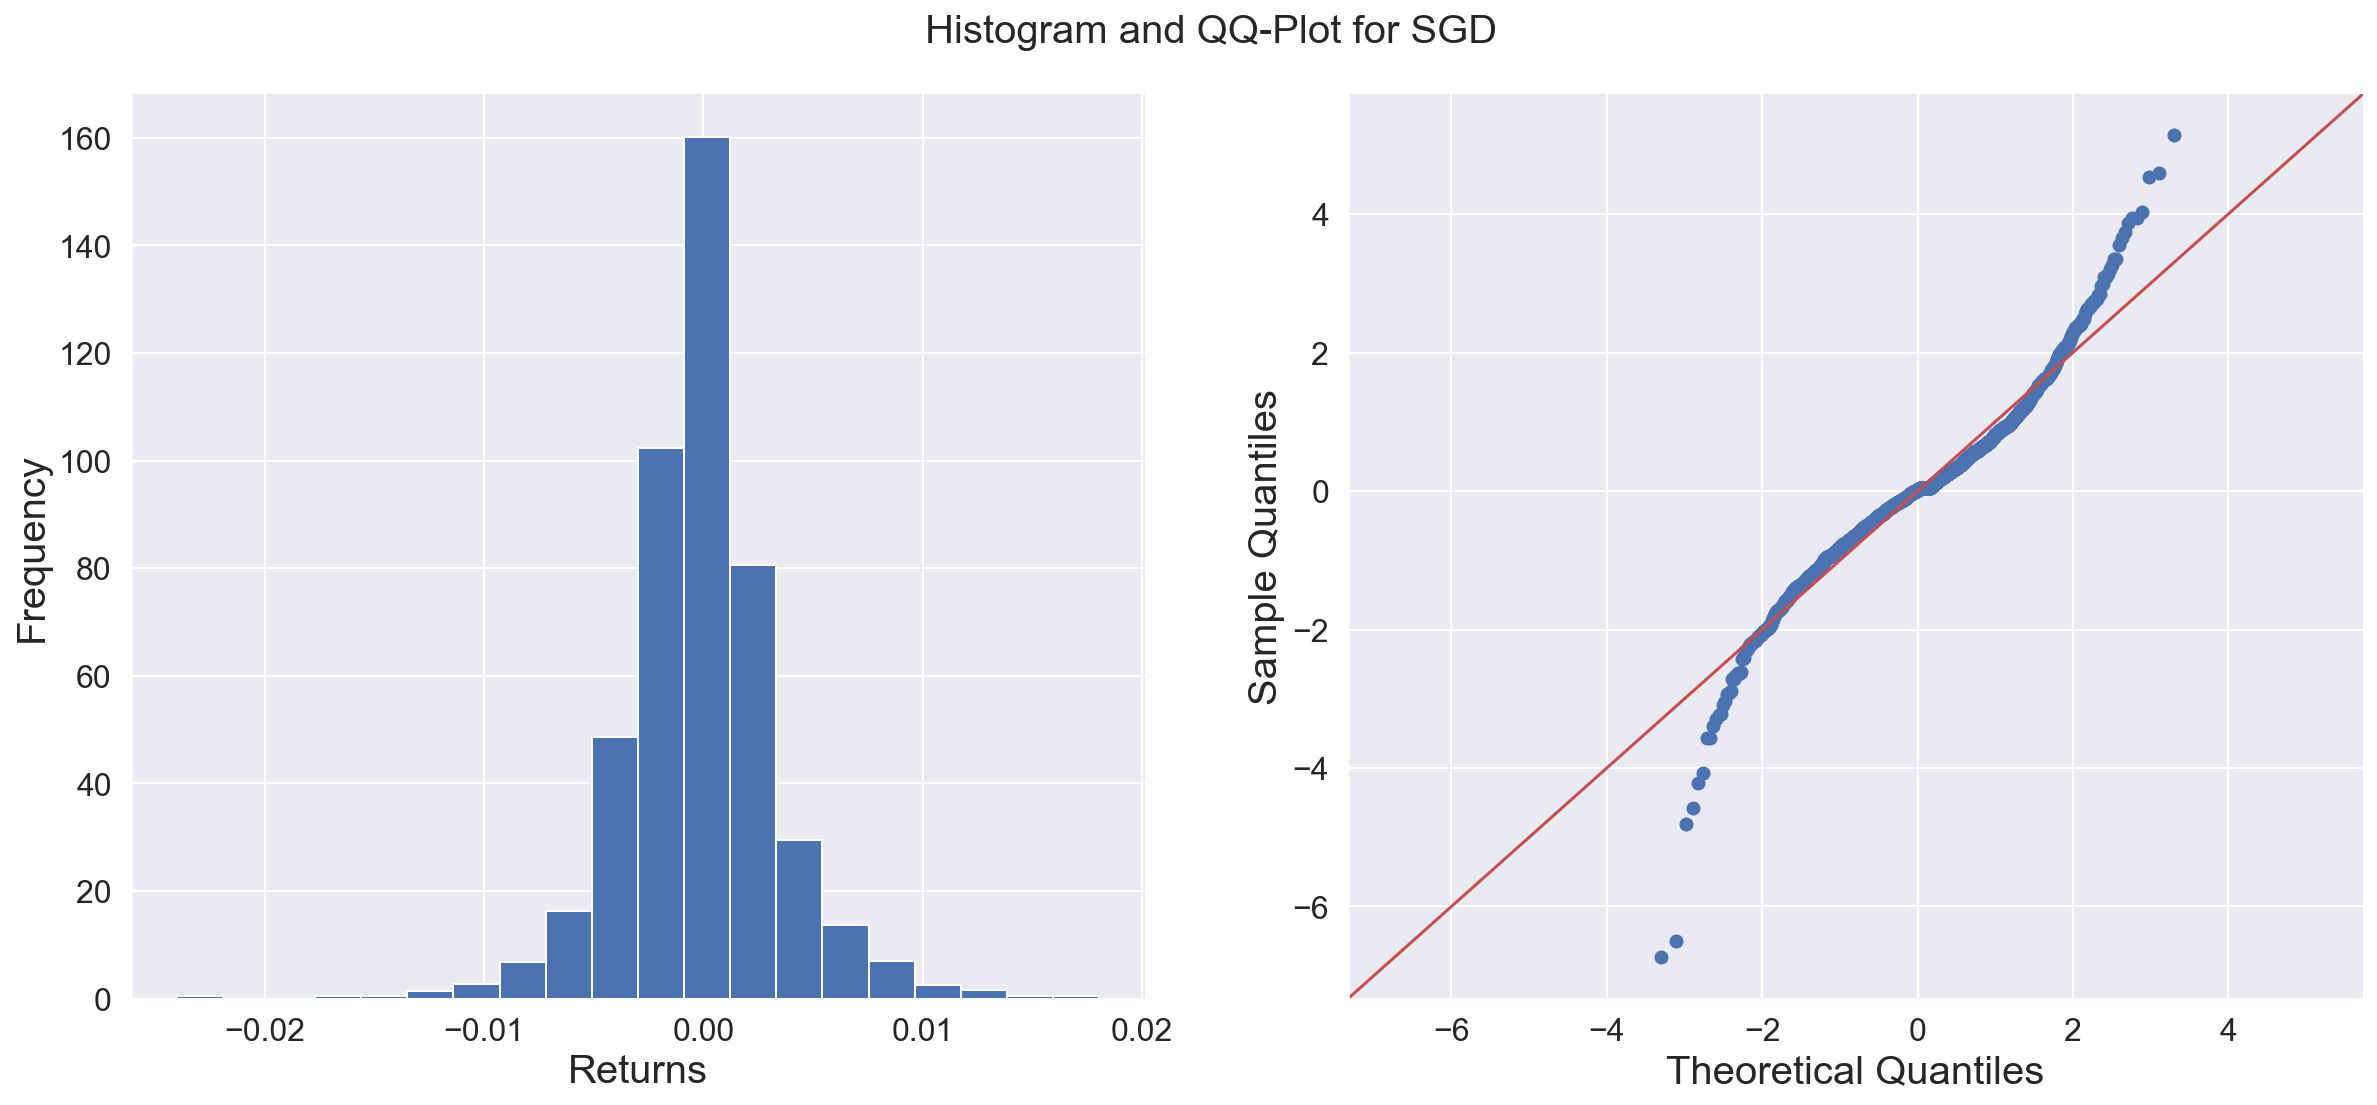

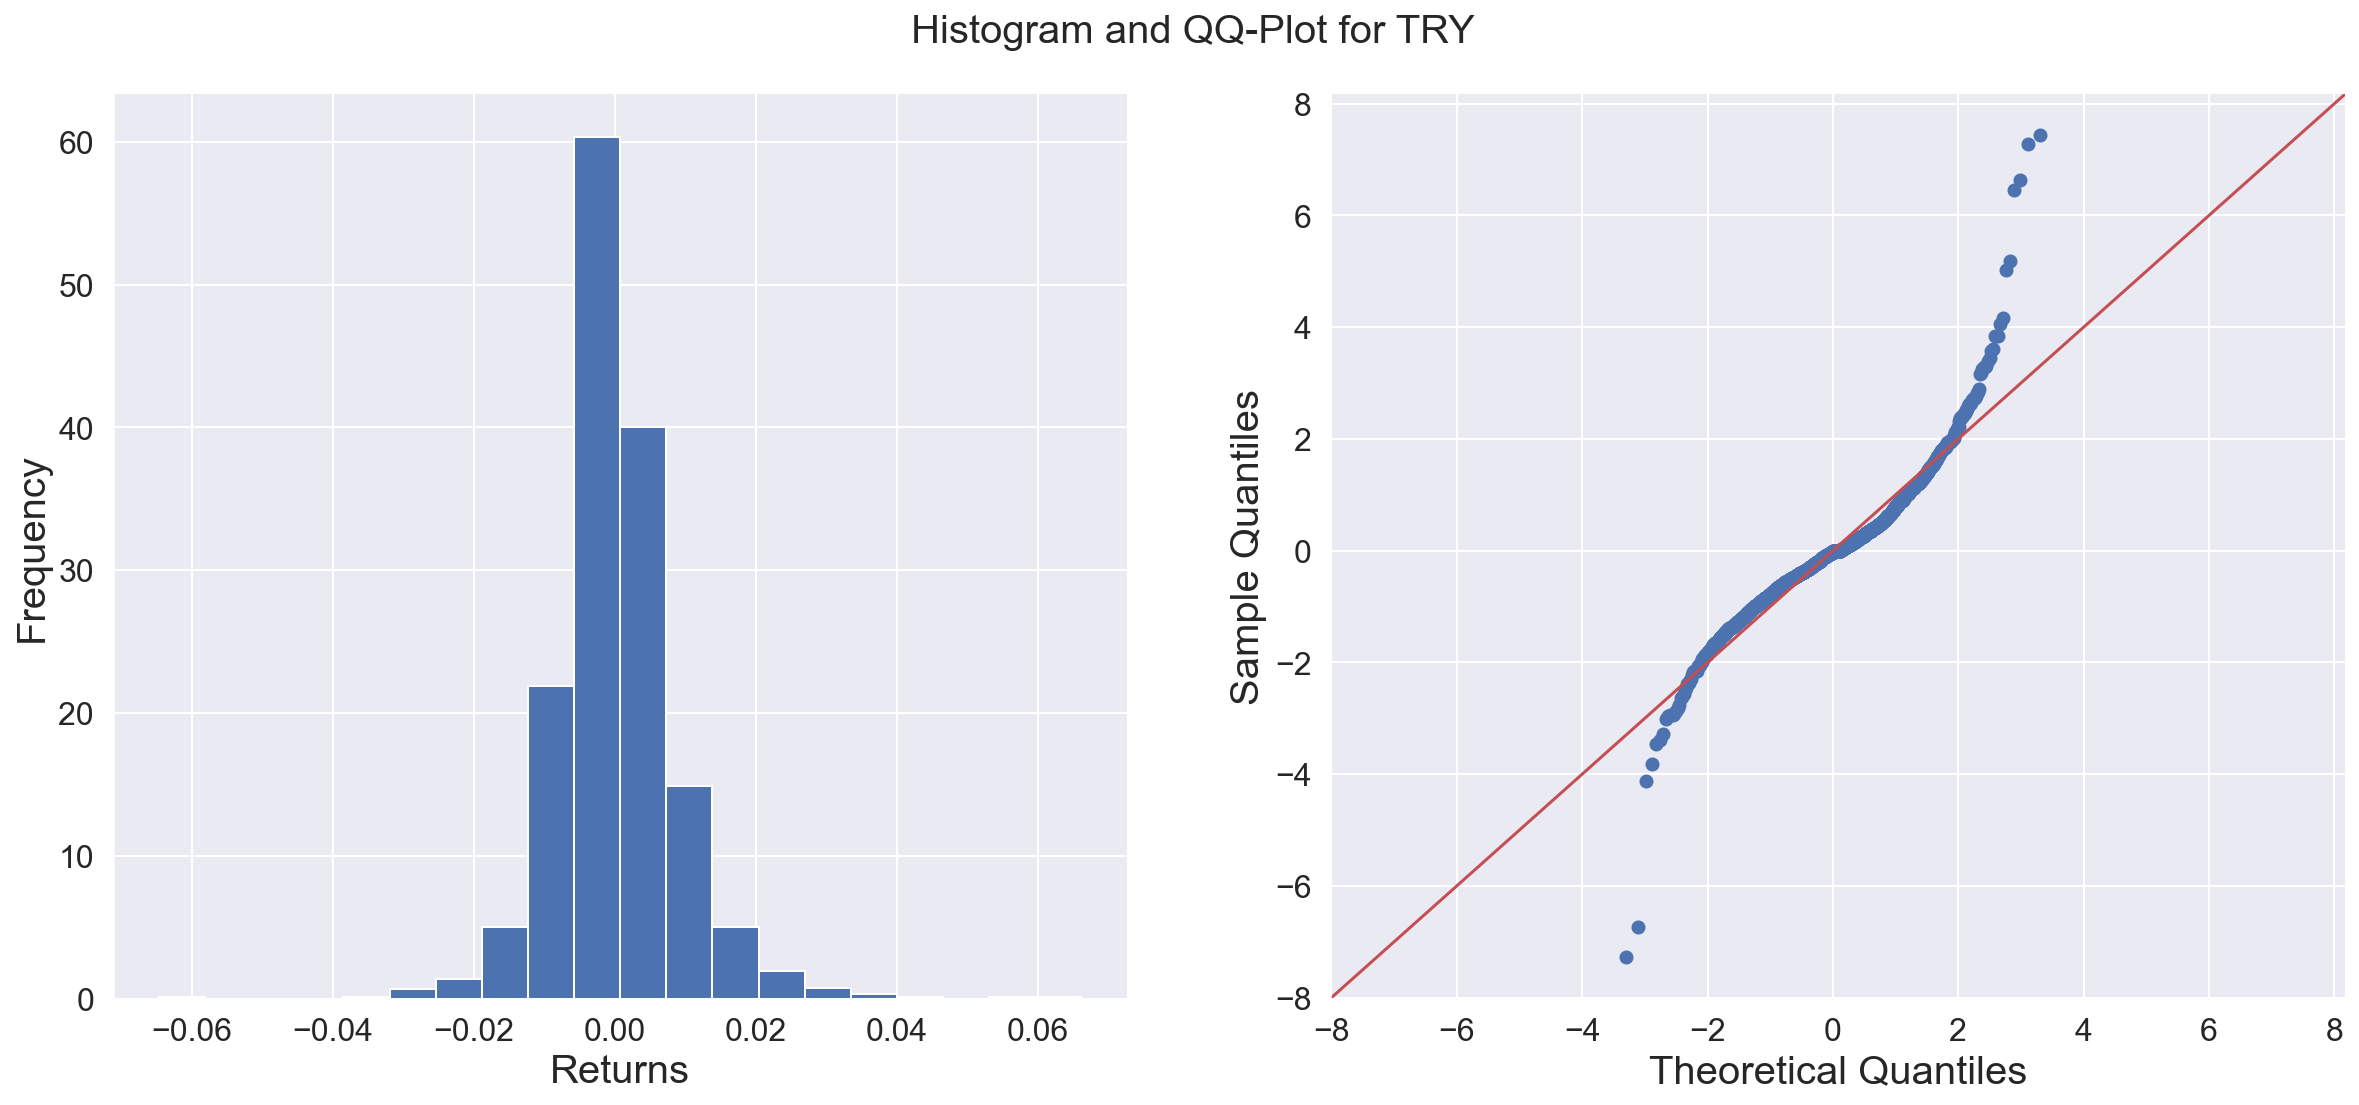

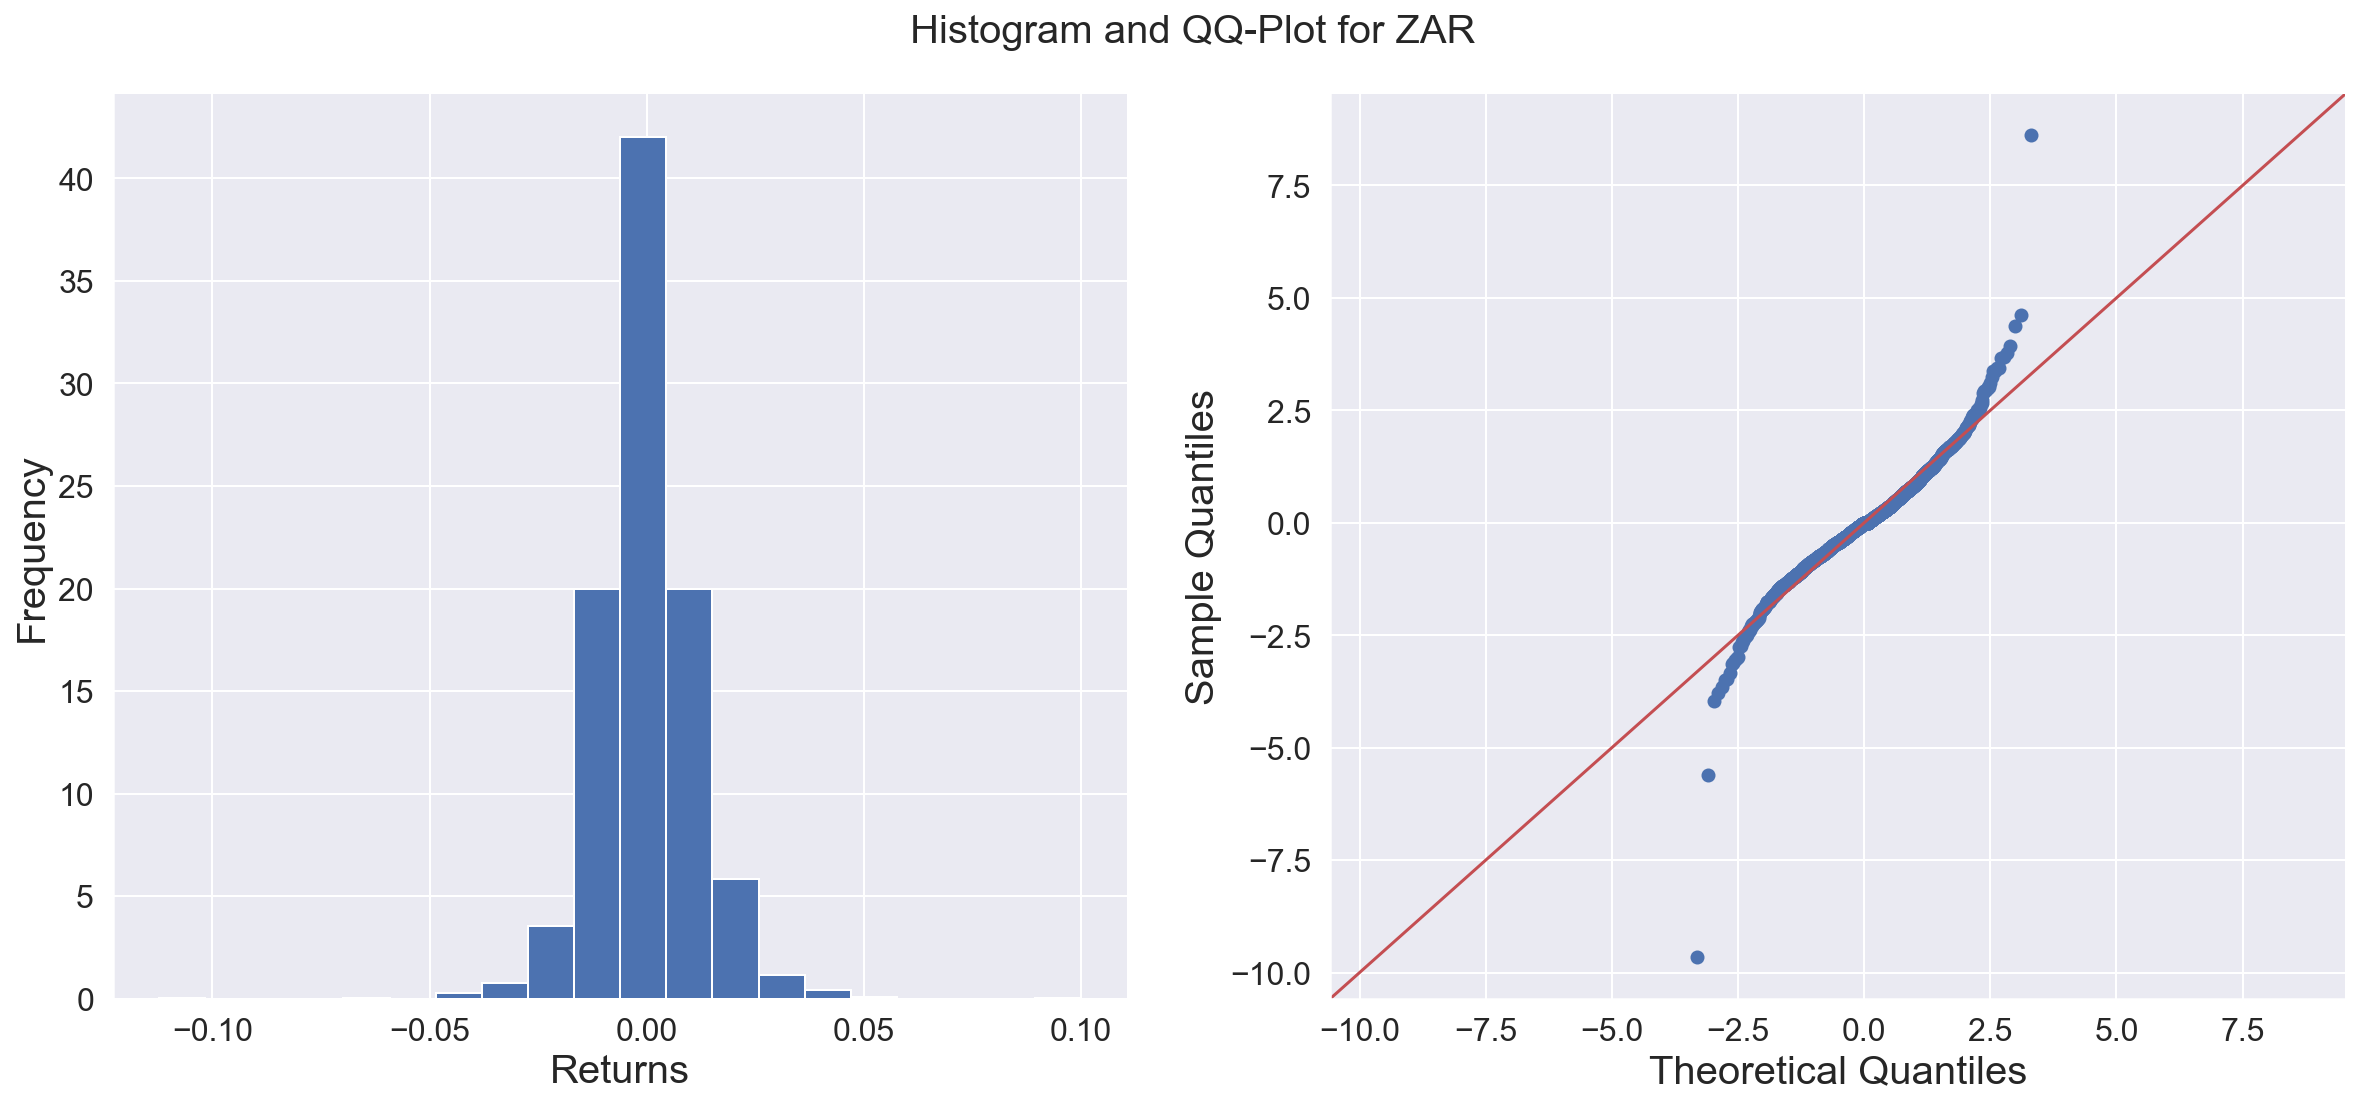

In [26]:
for cur in currencies:

    fxr = fx_returns.loc[:,cur]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))

    fig.suptitle(f"Histogram and QQ-Plot for {cur}",fontsize=20)
    fxr.plot.hist(ax=ax1,bins=20,density=True)
    ax1.set_xlabel('Returns')
    qqplot(fxr,ax=ax2,line='45',fit=True)
    fig.subplots_adjust(top=0.91)
    #plt.tight_layout()
    sns.despine()
    fig.show()

As can be seen from both the histograms and the QQ plots the return of these currencies are far from normal and have high kurtosis (fat tails) as well as skew with some large outlyers.

#### Part 2

In [67]:
def is_lag_significant(acf,c_m,c_u):
    return True if acf > c_u or acf < c_m else False

acf_info = []

for cur in currencies:

    fxr = fx_returns.loc[:,cur]
    acf_vals,conf_int = acf(fxr, nlags=10,alpha=.05)
    df = pd.DataFrame([(fxr.name,i,is_lag_significant(acf_vals[i],conf_int[i][0],conf_int[i][1])) for i in range(1,11)],
                      columns=['Currency','Lag','Significant'])
    acf_info.append(df)
acf_info = pd.concat(acf_info).set_index(['Lag','Currency'])
acf_info.unstack()

Significant                                                          \
Currency         ARS    AUD    BRL    CAD    CHF    CNY    CZK    DKK    EUR   
Lag                                                                            
1              False  False  False  False  False  False  False  False  False   
2              False  False  False  False  False  False  False  False  False   
3              False  False  False  False  False  False  False  False  False   
4              False  False  False  False  False  False  False  False  False   
5              False  False  False  False  False  False  False  False  False   
6              False  False  False  False  False  False  False  False  False   
7              False  False  False  False  False  False  False  False  False   
8              False  False  False  False  False  False  False  False  False   
9              False  False  False  False  False  False  False  False  False   
10             False  False  False  False  False  False  False  False  False   

                                                                         \
Currency    GBP    HKD    HUF    JPY    KRW    MXN    NOK    NZD    PLN   
Lag                                                                       
1         False  False  False  False  False  False  False  False  False   
2         False  False  False  False  False  False  False  False  False   
3         False  False  False  False  False  False  False  False  False   
4         False  False  False  False  False  False  False  False  False   
5         False  False  False  False  False  False  False  False  False   
6         False  False  False  False  False  False  False  False  False   
7         False  False  False  False  False  False  False  False  False   
8         False  False  False  False  False  False  False  False  False   
9         False  False  False  False  False  False  False  False  False   
10        False  False  False  False  False  False  False  False  False   

                                                    
Currency    RUB    SAR    SEK    SGD    TRY    ZAR  
Lag                                                 
1         False  False  False  False  False  False  
2         False  False  False  False  False  False  
3         False  False  False  False  False  False  
4         False  False  False  False  False  False  
5         False  False  False  False  False  False  
6         False  False  False  False  False  False  
7         False  False  False  False  False  False  
8         False  False  False  False  False  False  
9         False  False  False  False  False  False  
10        False  False  False  False  False  False

With autocorrelation being non-significance for the first 10 lags we can assume like these series are random walks.

#### Part 3


In [77]:
acf_r2_info = []

for cur in currencies:

    fxr = fx_returns.loc[:,cur]
    acf_vals,conf_int = acf(fxr**2, nlags=10,alpha=.05)
    df = pd.DataFrame([(fxr.name,i,is_lag_significant(acf_vals[i],conf_int[i][0],conf_int[i][1])) for i in range(1,11)],
                      columns=['Currency','Lag','lag_Significant'])
    acf_r2_info.append(df)
acf_r2_info = pd.concat(acf_r2_info).set_index(['Lag','Currency'])
acf_r2_info.unstack()

lag_Significant                                                   \
Currency             ARS    AUD    BRL    CAD    CHF    CNY    CZK    DKK   
Lag                                                                         
1                  False  False  False  False  False  False  False  False   
2                  False  False  False  False  False  False  False  False   
3                  False  False  False  False  False  False  False  False   
4                  False  False  False  False  False  False  False  False   
5                  False  False  False  False  False  False  False  False   
6                  False  False  False  False  False  False  False  False   
7                  False  False  False  False  False  False  False  False   
8                  False  False  False  False  False  False  False  False   
9                  False  False  False  False  False  False  False  False   
10                 False  False  False  False  False  False  False  False   

                                                                         \
Currency    EUR    GBP    HKD    HUF    JPY    KRW    MXN    NOK    NZD   
Lag                                                                       
1         False  False  False  False  False  False  False  False  False   
2         False  False  False  False  False  False  False  False  False   
3         False  False  False  False  False  False  False  False  False   
4         False  False  False  False  False  False  False  False  False   
5         False  False  False  False  False  False  False  False  False   
6         False  False  False  False  False  False  False  False  False   
7         False  False  False  False  False  False  False  False  False   
8         False  False  False  False  False  False  False  False  False   
9         False  False  False  False  False  False  False  False  False   
10        False  False  False  False  False  False  False  False  False   

                                                           
Currency    PLN    RUB    SAR    SEK    SGD    TRY    ZAR  
Lag                                                        
1         False  False  False  False  False  False  False  
2         False  False  False  False  False  False  False  
3         False  False  False  False  False  False  False  
4         False  False  False  False  False  False  False  
5         False  False  False  False  False  False  False  
6         False  False  False  False  False  False  False  
7         False  False  False  False  False  False  False  
8         False  False  False  False  False  False  False  
9         False  False  False  False  False  False  False  
10        False  False  False  False  False  False  False

In [75]:
fxr = fx_returns.loc[:,'EUR']
acf_vals,conf_int = acf(fxr**2, nlags=10,alpha=.05)

[is_lag_significant(acf_vals[i],conf_int[i][0],conf_int[i][1]) for i in range(1,11)]
acf_vals,conf_int

(array([1.        , 0.05455849, 0.02692354, 0.00763487, 0.02375971,
        0.00413135, 0.01966523, 0.01514455, 0.00276439, 0.02156838,
        0.02976689]),
 array([[ 1.        ,  1.        ],
        [ 0.01172734,  0.09738965],
        [-0.01603492,  0.06988199],
        [-0.03535453,  0.05062427],
        [-0.01923218,  0.0667516 ],
        [-0.03888462,  0.04714732],
        [-0.02335147,  0.06268192],
        [-0.02788864,  0.05817774],
        [-0.04027857,  0.04580735],
        [-0.02147491,  0.06461167],
        [-0.01329622,  0.07283   ]]))

### Question 4

Exchange rates: Consider the original series, $p_t$, in file __exchange_rates_2.csv__ for the period starting June 11, 2003. Answer the following after dividing each series by $p_1$, so that the starting points are the same.

1. Identify for each series, if there are any regime changes. Test if these changes are statistically significant.
2. Identify how many clusters are there and if the membership changes under different regimes.
3. Do the series move together? Provide some intuitive tests (more formal tests will be covered in Chapter 3).
4. Compare the results in (3) with (2). What is the connection between clustering and co-movement? Briefly discuss.



### Question 5

Consider the daily price of Apple stock from January 2, 2015 to January 2, 2018 in file aapl_daily.csv. The data have 7 columns (namely, Date, Open, High, Low, Close, Volume, Adj Close). We focus on the adjusted closing price in the last column:
1. Compute the daily log returns. Is there any serial correlation in the daily log returns? Use the test for white noise as outlined in the text.
2. Consider the pivot based on the average of high and low price and the pivot based on the average of high, low and close prices. Compute the returns based on the pivot log prices and test for serial correlation. Compare this result with the finding in (1).
3. Consider the log price series of AAPL stock. Is the log price series unit-root non-stationary? Perform a unit-root (Dickey-Fuller) test to answer the question and present your conclusion.

In [79]:
aapl = pd.read_csv('../datasets/aapl_daily.csv',index_col='Date',parse_dates=True).rename(columns={'Adj Close':'AdjClose'})
aapl.head()

Open        High         Low       Close    AdjClose  \
Date                                                                     
2015-01-02  111.389999  111.440002  107.349998  109.330002  101.963631   
2015-01-05  108.290001  108.650002  105.410004  106.250000   99.091148   
2015-01-06  106.540001  107.430000  104.629997  106.260002   99.100471   
2015-01-07  107.199997  108.199997  106.699997  107.750000  100.490089   
2015-01-08  109.230003  112.150002  108.699997  111.889999  104.351151   

              Volume  
Date                  
2015-01-02  53204600  
2015-01-05  64285500  
2015-01-06  65797100  
2015-01-07  40105900  
2015-01-08  59364500

#### Part 1

In [80]:
aapl_lr = np.log(aapl.AdjClose).diff().dropna()
aapl_lr.head()

Date
2015-01-05   -0.028576
2015-01-06    0.000094
2015-01-07    0.013925
2015-01-08    0.037703
2015-01-09    0.001072
Name: AdjClose, dtype: float64

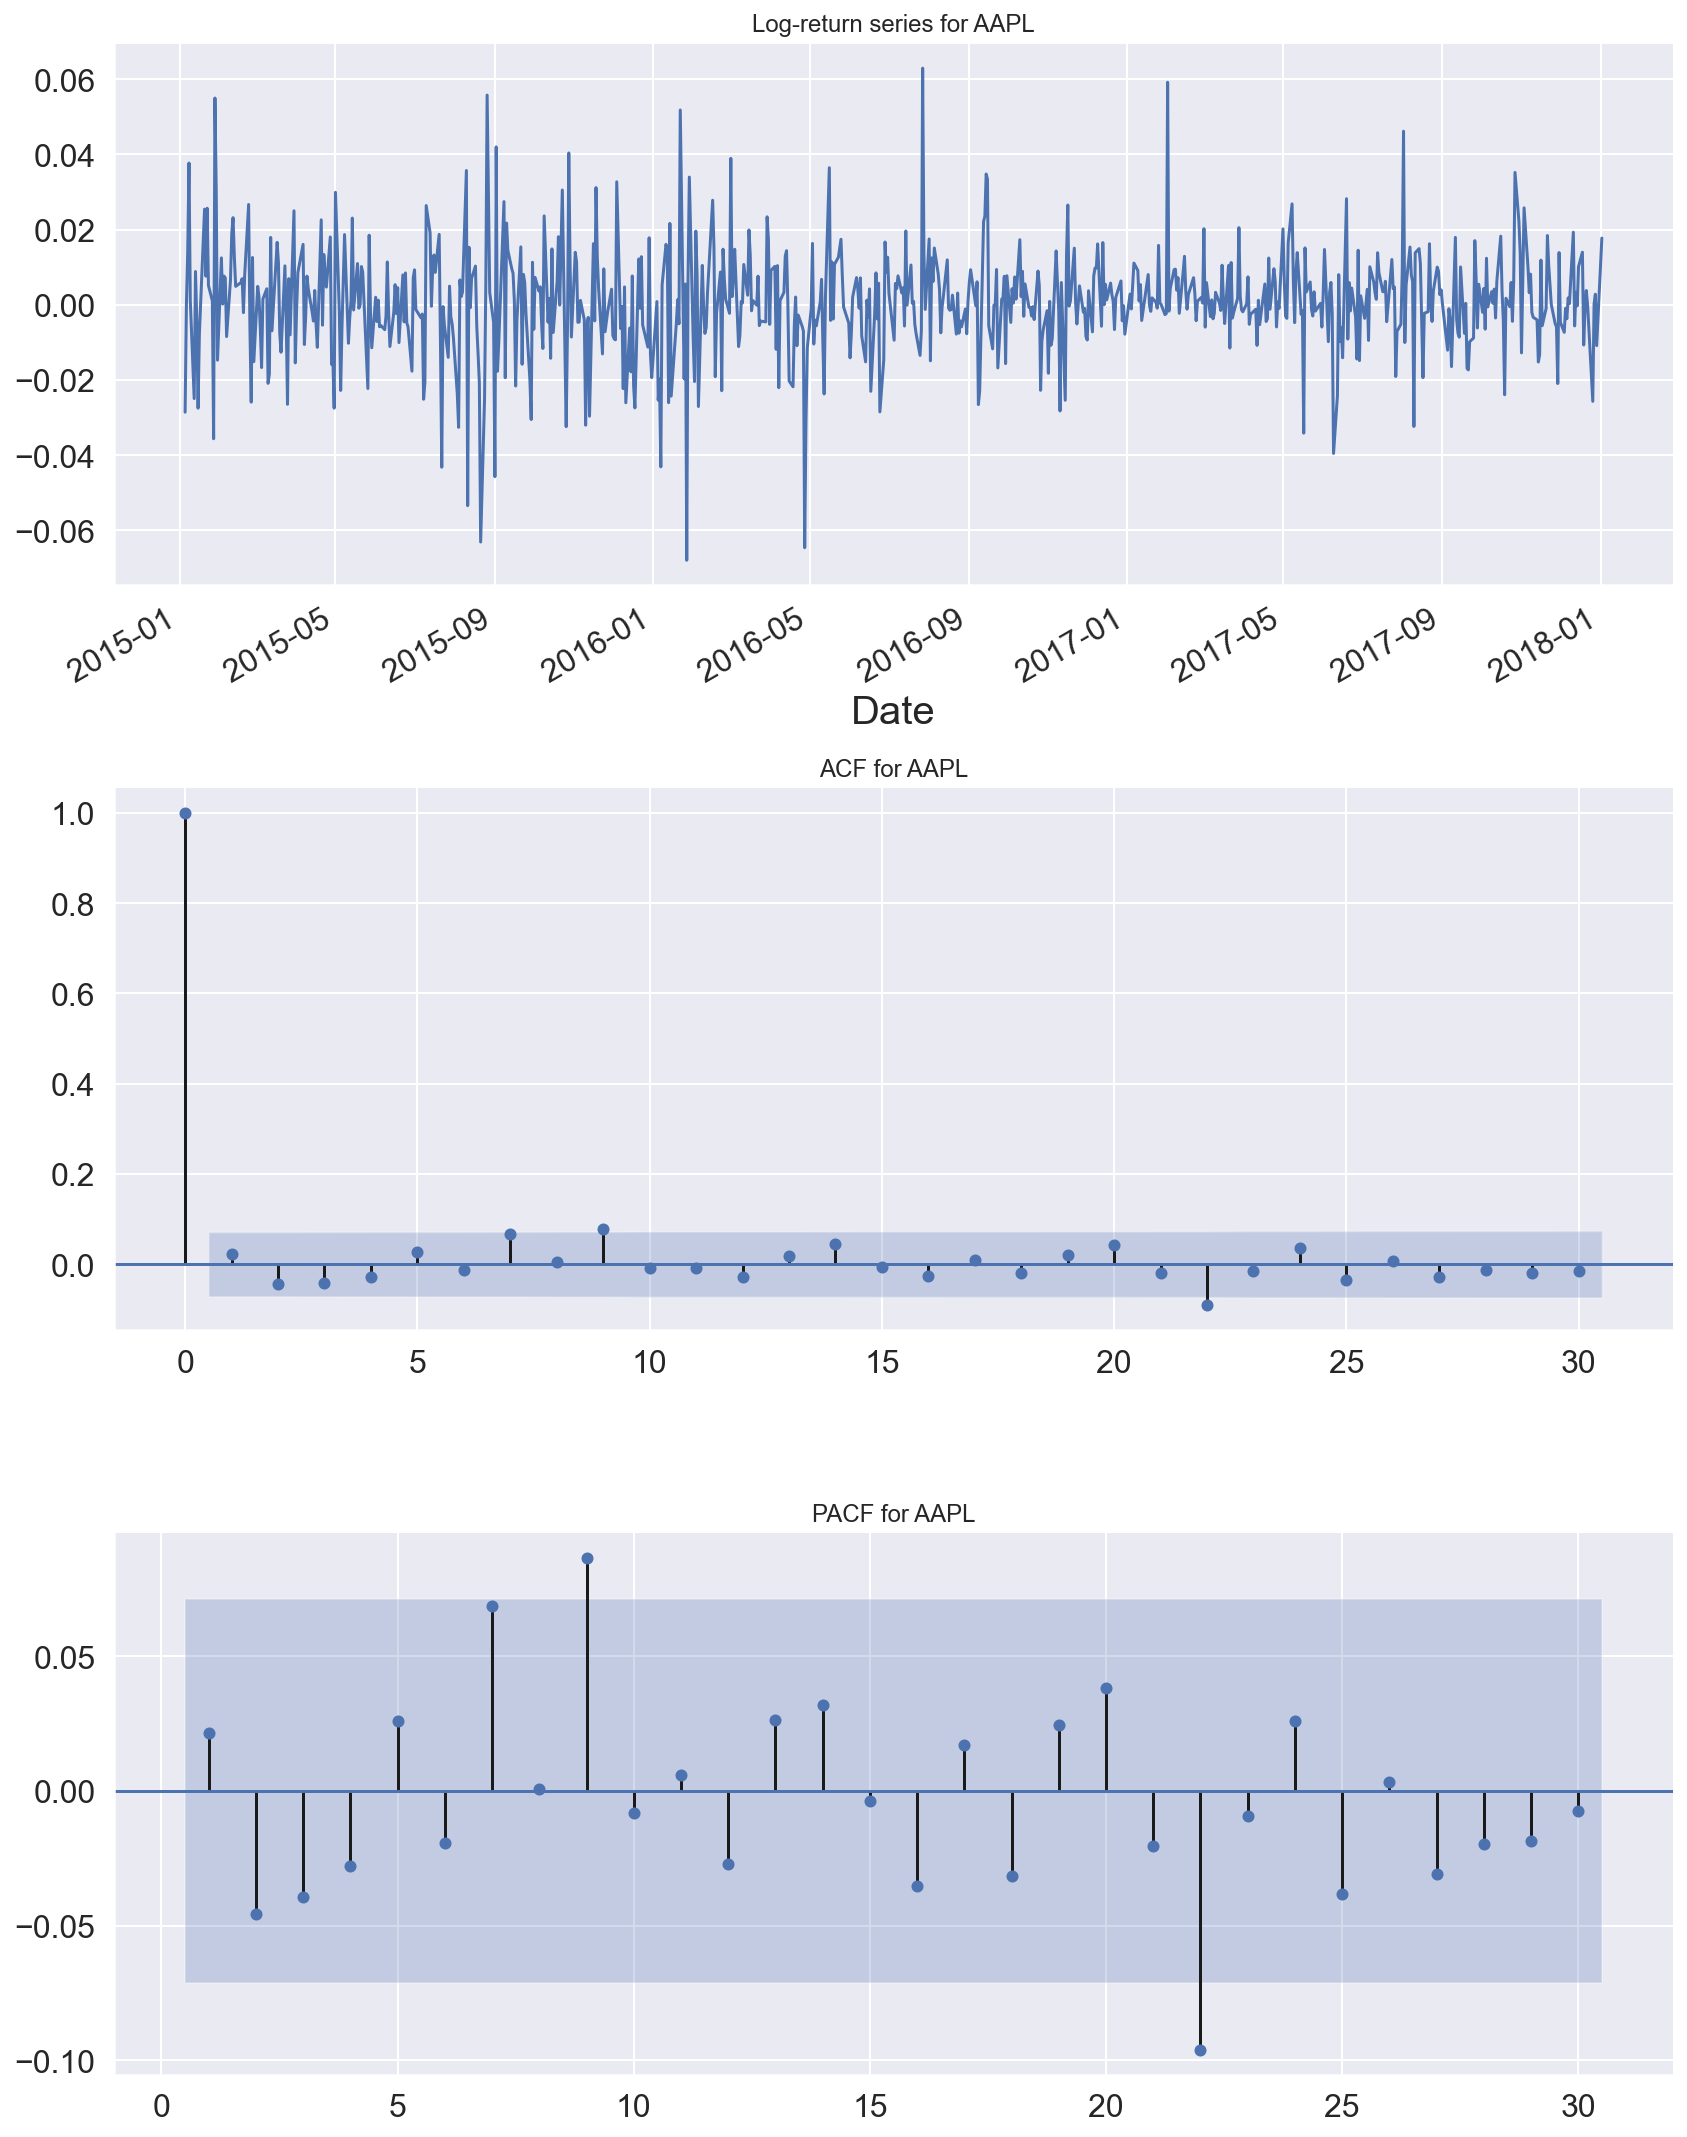

In [81]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = aapl_lr.plot(ax=ax1,title='Log-return series for AAPL')
_ = plot_acf(aapl_lr, ax=ax2,zero = True,alpha=0.05,lags=30,title='ACF for AAPL')
_ = plot_pacf(aapl_lr, ax=ax3, zero = False,alpha=0.05,lags=30,title='PACF for AAPL')
sns.despine()
plt.tight_layout()
plt.show()



The ACF and APCF show ery little significance in the first 10 lags impliying that there is no serial correlation in the log returns. We also run the LJung-Box test:

In [82]:
acorr_ljungbox(aapl_lr,lags=1,return_df=True)

lb_stat  lb_pvalue
1  0.350986   0.553556

The pvalue is high implying we cannot reject the null that there is no serial correlation

#### Part 2

In [83]:
pivot_1 = (aapl.High + aapl.Low)/2
pivot_2 = (aapl.High + aapl.Low + aapl.Close)/3
p1_lr = np.log(pivot_1).diff().dropna()
p2_lr = np.log(pivot_2).diff().dropna()

In [84]:
acorr_ljungbox(p1_lr,lags=1,return_df=True)

lb_stat  lb_pvalue
1  12.4846    0.00041

In [85]:
acorr_ljungbox(p2_lr,lags=1,return_df=True)

lb_stat  lb_pvalue
1  22.454746   0.000002

For both the 2 pivots the pvalues are small and thus we can reject the null that there is no serial correlation at lag 1.

### Exercise 6

Consider the daily price of Apple stock again in file aapl_daily.csv.
1. Compute various measures of variance computed from the entries of the price bars. Comment on their correlation with log volume.
2. Use the ARIMA modeling to come up with a parsimoniousmodel for log volume. Comment on the model accuracy by setting aside a validation data set.
<br>

#### Part 1

We create the volatility estimates suggested in the book using the same framework suggested on page 144. The measures are:
- Close to Close
- Rogers & Satchell
- Yang & Zhang

We look at the over a choose 22d (1 month) period. (Note the use of groupby and pd.grouper since we want to look at this not on a rolling window but as in non overlapping periods). 

In [86]:
def vol_estimates(df):
    o = np.log(df.Open) - np.log(df.Close.shift())
    u = np.log(df.High) - np.log(df.Open)
    d = np.log(df.Low) - np.log(df.Open)
    c = np.log(df.Close) - np.log(df.Open)
    
    n = c.shape[0]
    k = 0.34/(1.34 + (n+1)*(n-1))

    v_cc = ((o + c) - (o.mean()+c.mean())).pow(2).sum()/(n-1)
    v_rs = (u*(u-c) + d*(d-c)).sum()/n

    v_yz = (o - o.mean()).pow(2).sum()/(n-1) + k*(c - c.mean()).pow(2).sum()/(n-1) + (1-k)*v_rs
    
    return pd.Series({'Vcc':v_cc,'Vrs':v_rs,'Vyz':v_yz})

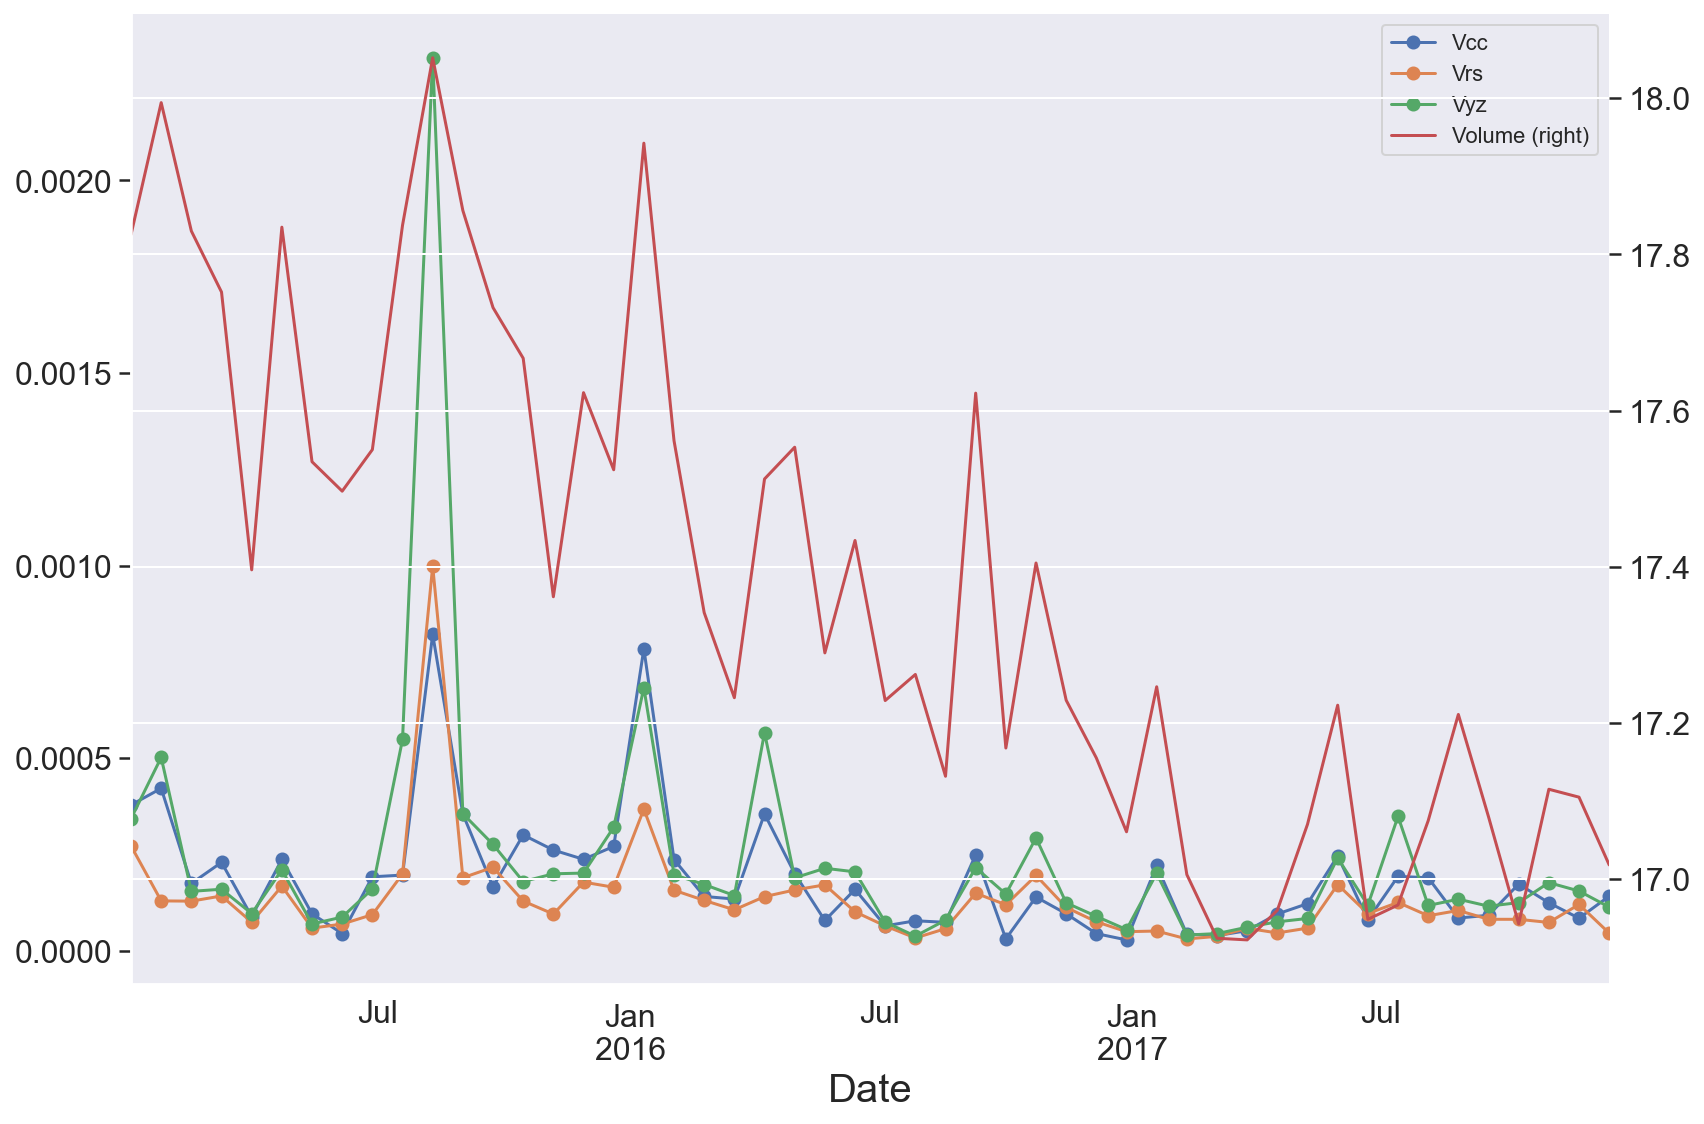

In [87]:
vol_measures = aapl.groupby(pd.Grouper(freq='22d')).apply(vol_estimates)
log_volume =  aapl.Volume.groupby(pd.Grouper(freq='22d')).apply(lambda x: np.log(x).mean())
fig,ax = plt.subplots(figsize=(12,8))
_ = vol_measures.iloc[:,0:3].plot(ax=ax,linestyle='-',marker='o')
_ = log_volume.plot(ax=ax,secondary_y=True,label=None,legend=True)
sns.despine()
plt.tight_layout()
plt.show()


Let's look at the correlation of each measure with  log volume.

In [88]:
vol_measures.corrwith(log_volume)

Vcc    0.700254
Vrs    0.574676
Vyz    0.528924
dtype: float64

#### Part 2



In [89]:
log_volume = np.log(aapl.Volume)

logv_train = log_volume[:-60]
logv_val = log_volume[-60:]

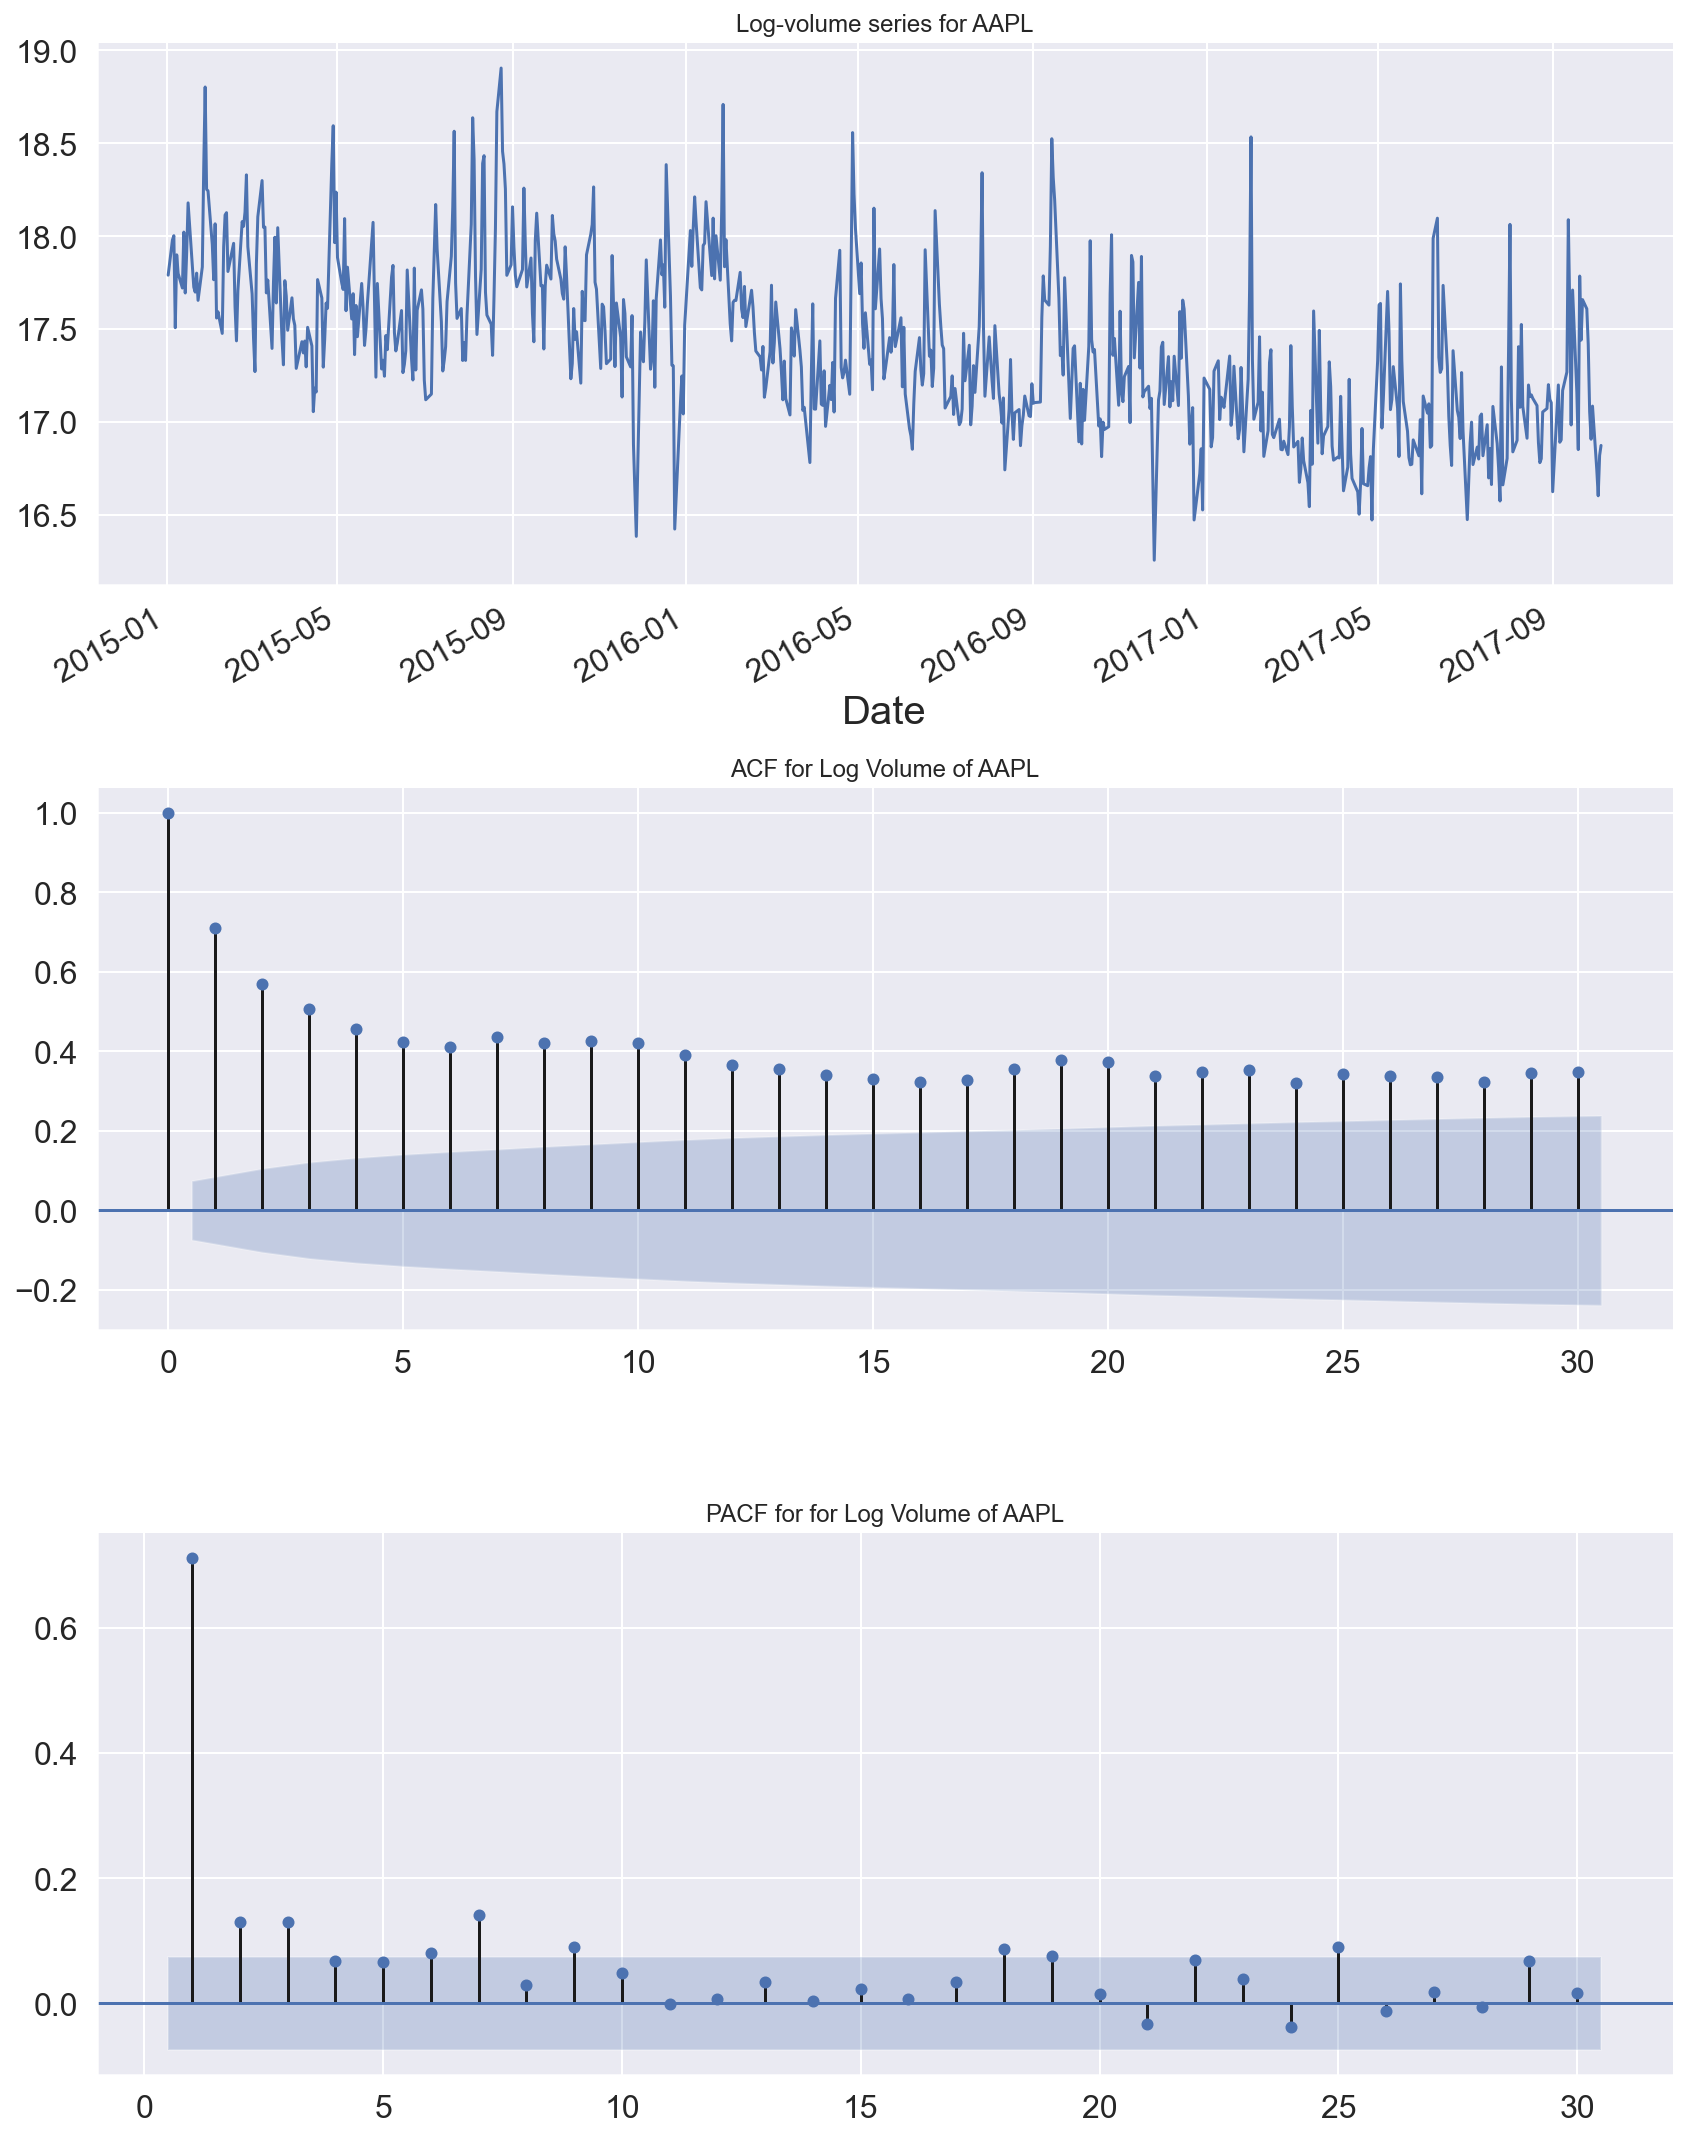

In [90]:

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = logv_train.plot(ax=ax1,title='Log-volume series for AAPL')
_ = plot_acf(logv_train, ax=ax2,zero = True,alpha=0.05,lags=30,title='ACF for Log Volume of AAPL')
_ = plot_pacf(logv_train, ax=ax3, zero = False,alpha=0.05,lags=30,title='PACF for for Log Volume of AAPL')
sns.despine()
plt.tight_layout()
plt.show()

ACF is highly significant across many lags so there is autocorrelation. PACF is significant at lag 1,2, and 3.

Let's look at the differenced data:

In [91]:
logv_diff = logv_train.diff().dropna()

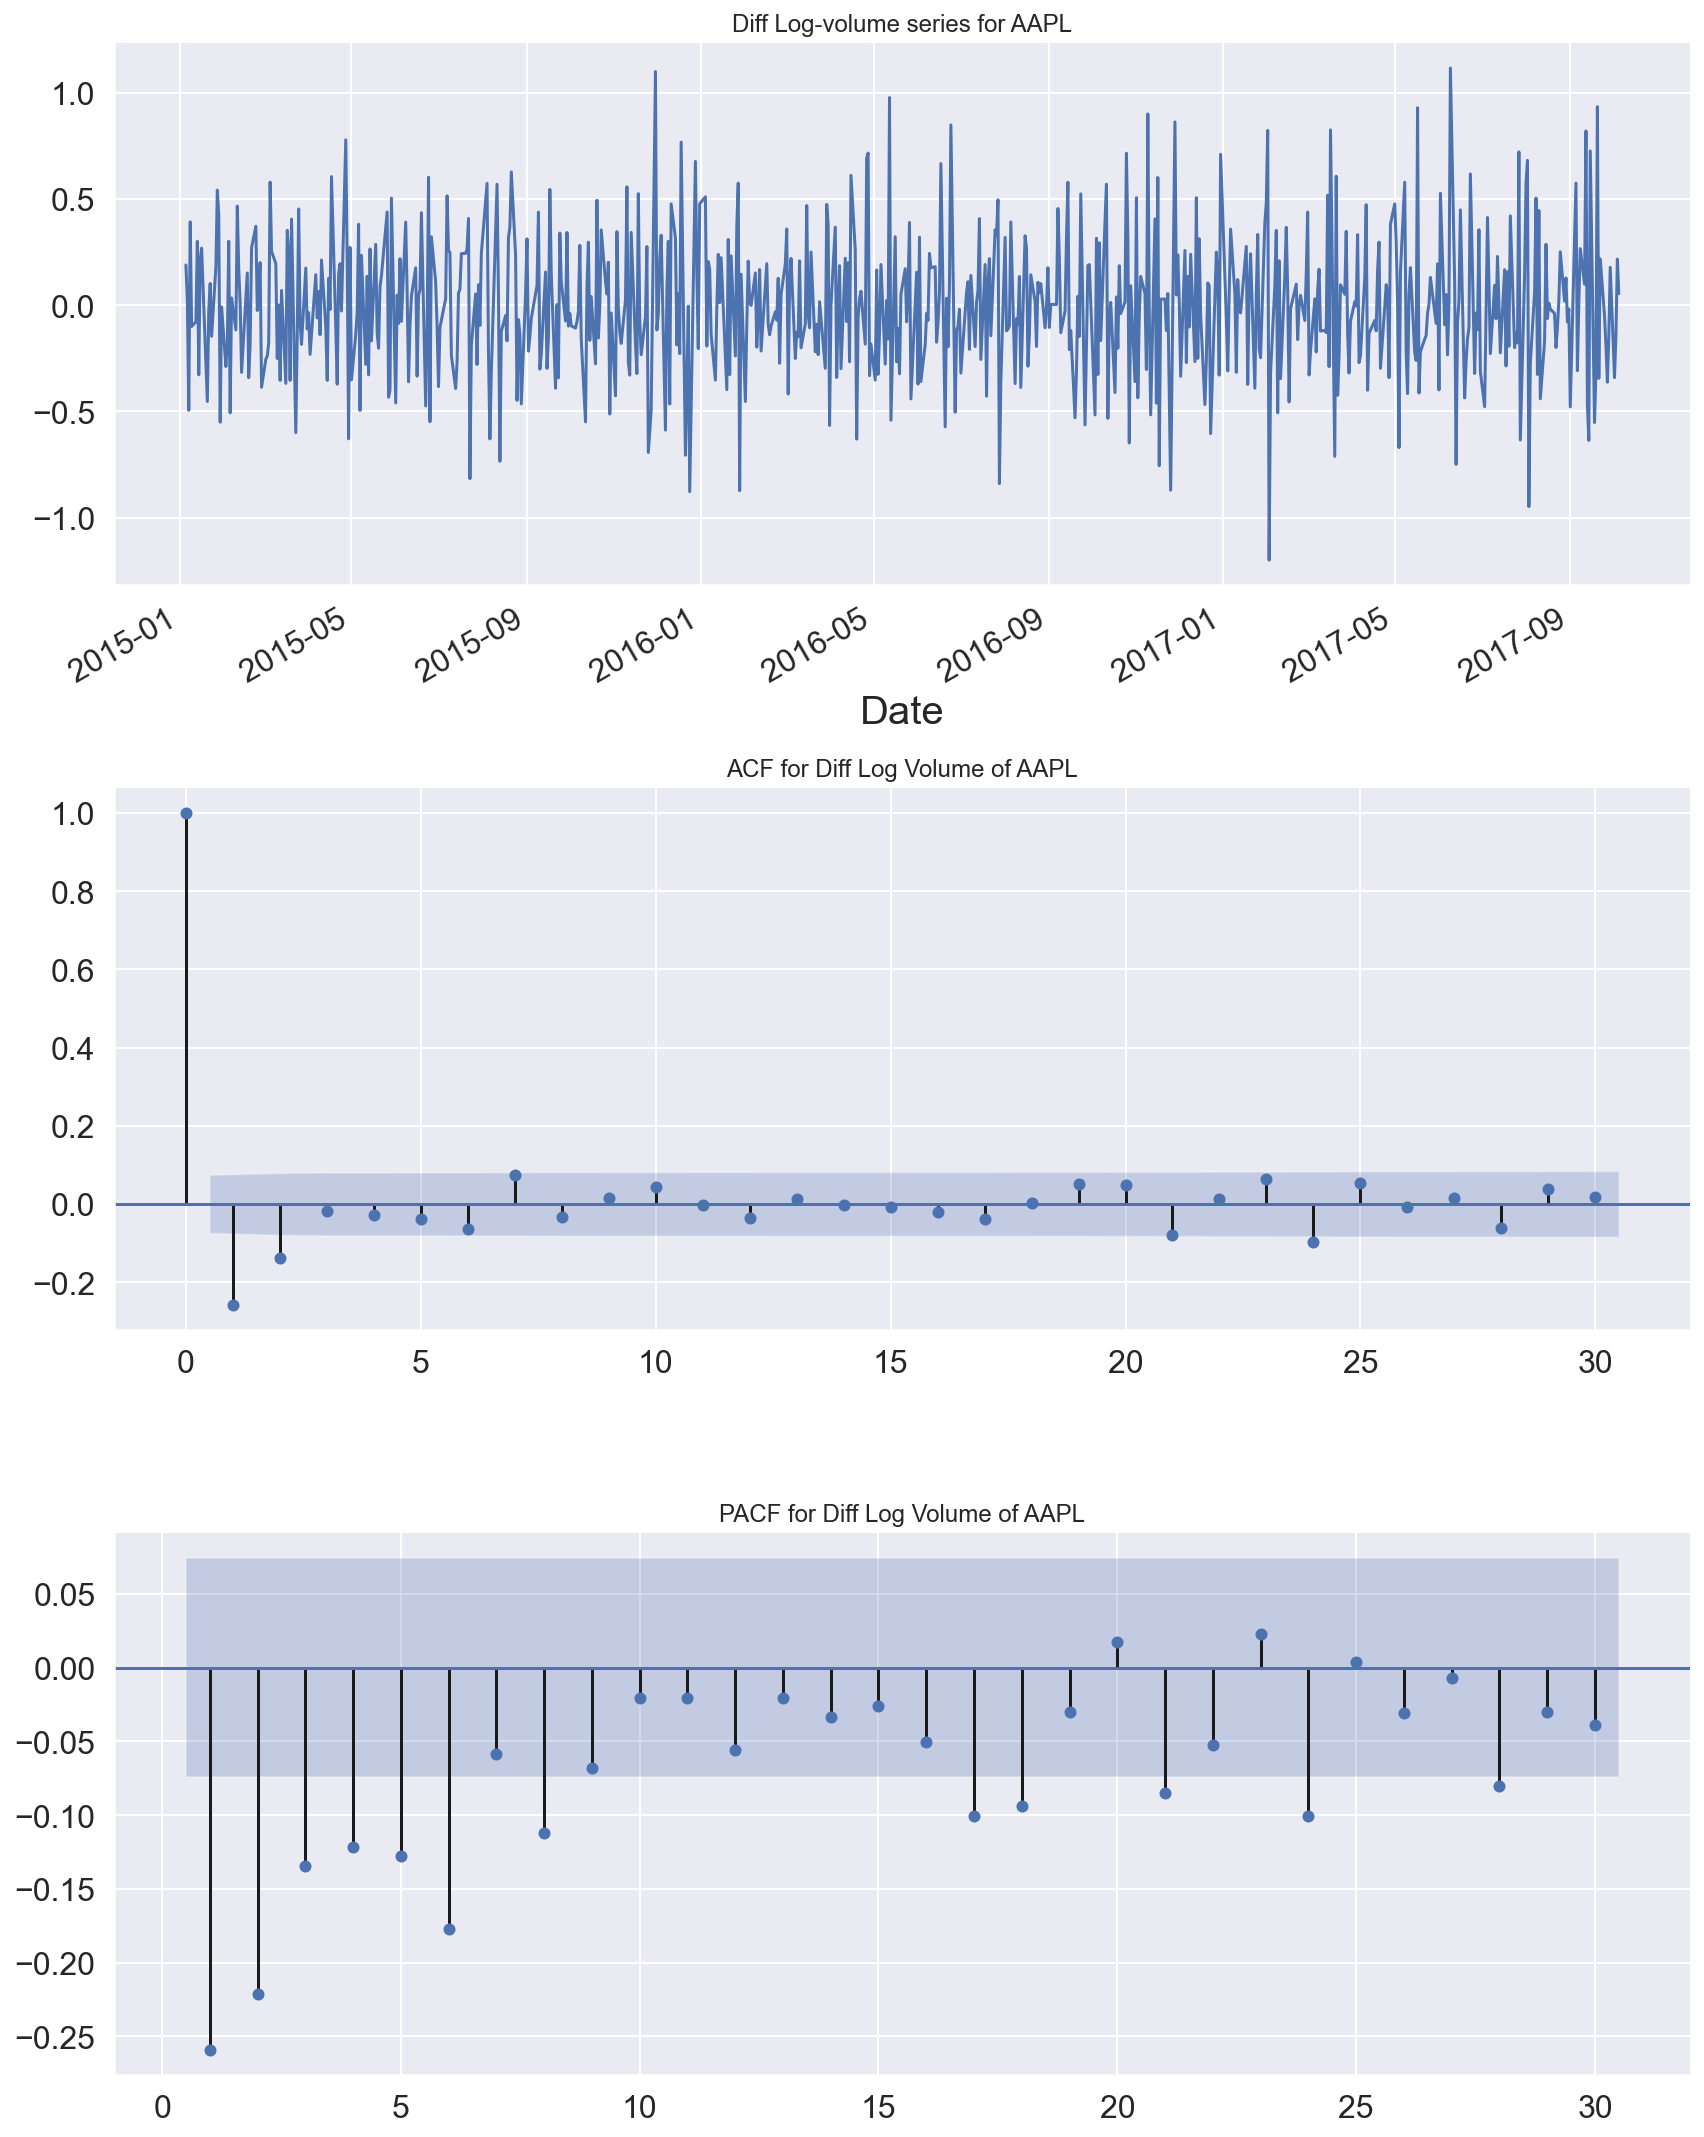

In [92]:

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
_ = logv_diff.plot(ax=ax1,title='Diff Log-volume series for AAPL')
_ = plot_acf(logv_diff, ax=ax2,zero = True,alpha=0.05,lags=30,title='ACF for Diff Log Volume of AAPL')
_ = plot_pacf(logv_diff, ax=ax3, zero = False,alpha=0.05,lags=30,title='PACF for Diff Log Volume of AAPL')
sns.despine()
plt.tight_layout()
plt.show()

After differencing the ACF is signficant at lag 1 and 2. the PACF is significant over several lags. Let's try first with ARMA(3,2).

In [93]:
model = ARIMA(logv_train,(3,1,2))

In [94]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Volume   No. Observations:                  695
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -134.341
Method:                       css-mle   S.D. of innovations              0.292
Date:                Wed, 28 Oct 2020   AIC                            282.683
Time:                        16:22:28   BIC                            314.490
Sample:                             1   HQIC                           294.982
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.000    -10.106      0.000      -0.002      -0.001
ar.L1.D.Volume    -0.4065      0.091     -4.478      0.000      -0.584      -0.229
ar.L2.D.Volume     0.5231      0.063      8.347      0.000       0.400       0.646
ar.L3.D.Volume     0.0657      0.039      1.669      0.095      -0.011       0.143
ma.L1.D.Volume    -0.0638      0.084     -0.762      0.446      -0.228       0.100
ma.L2.D.Volume    -0.9362      0.084    -11.185      0.000      -1.100      -0.772
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1055           +0.0000j            1.1055            0.5000
AR.2            1.6236           +0.0000j            1.6236            0.0000
AR.3           -8.4844           +0.0000j            8.4844            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0681           +0.0000j            1.0681            0.5000
-----------------------------------------------------------------------------
"""

The L3 AR coefficient is non significant and so is the L1 MA coefficient. Let's try a more parsimonus model to ARMA(1,1)

In [95]:
model = ARIMA(logv_train,(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Volume   No. Observations:                  695
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -136.600
Method:                       css-mle   S.D. of innovations              0.293
Date:                Wed, 28 Oct 2020   AIC                            281.200
Time:                        16:22:28   BIC                            299.375
Sample:                             1   HQIC                           288.228
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.000    -10.688      0.000      -0.002      -0.001
ar.L1.D.Volume     0.5511      0.032     17.370      0.000       0.489       0.613
ma.L1.D.Volume    -1.0000      0.005   -202.173      0.000      -1.010      -0.990
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8145           +0.0000j            1.8145            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

All Coefficients are significant and the AIC/BIC has improved. So we settle to an ARMA(1,1)

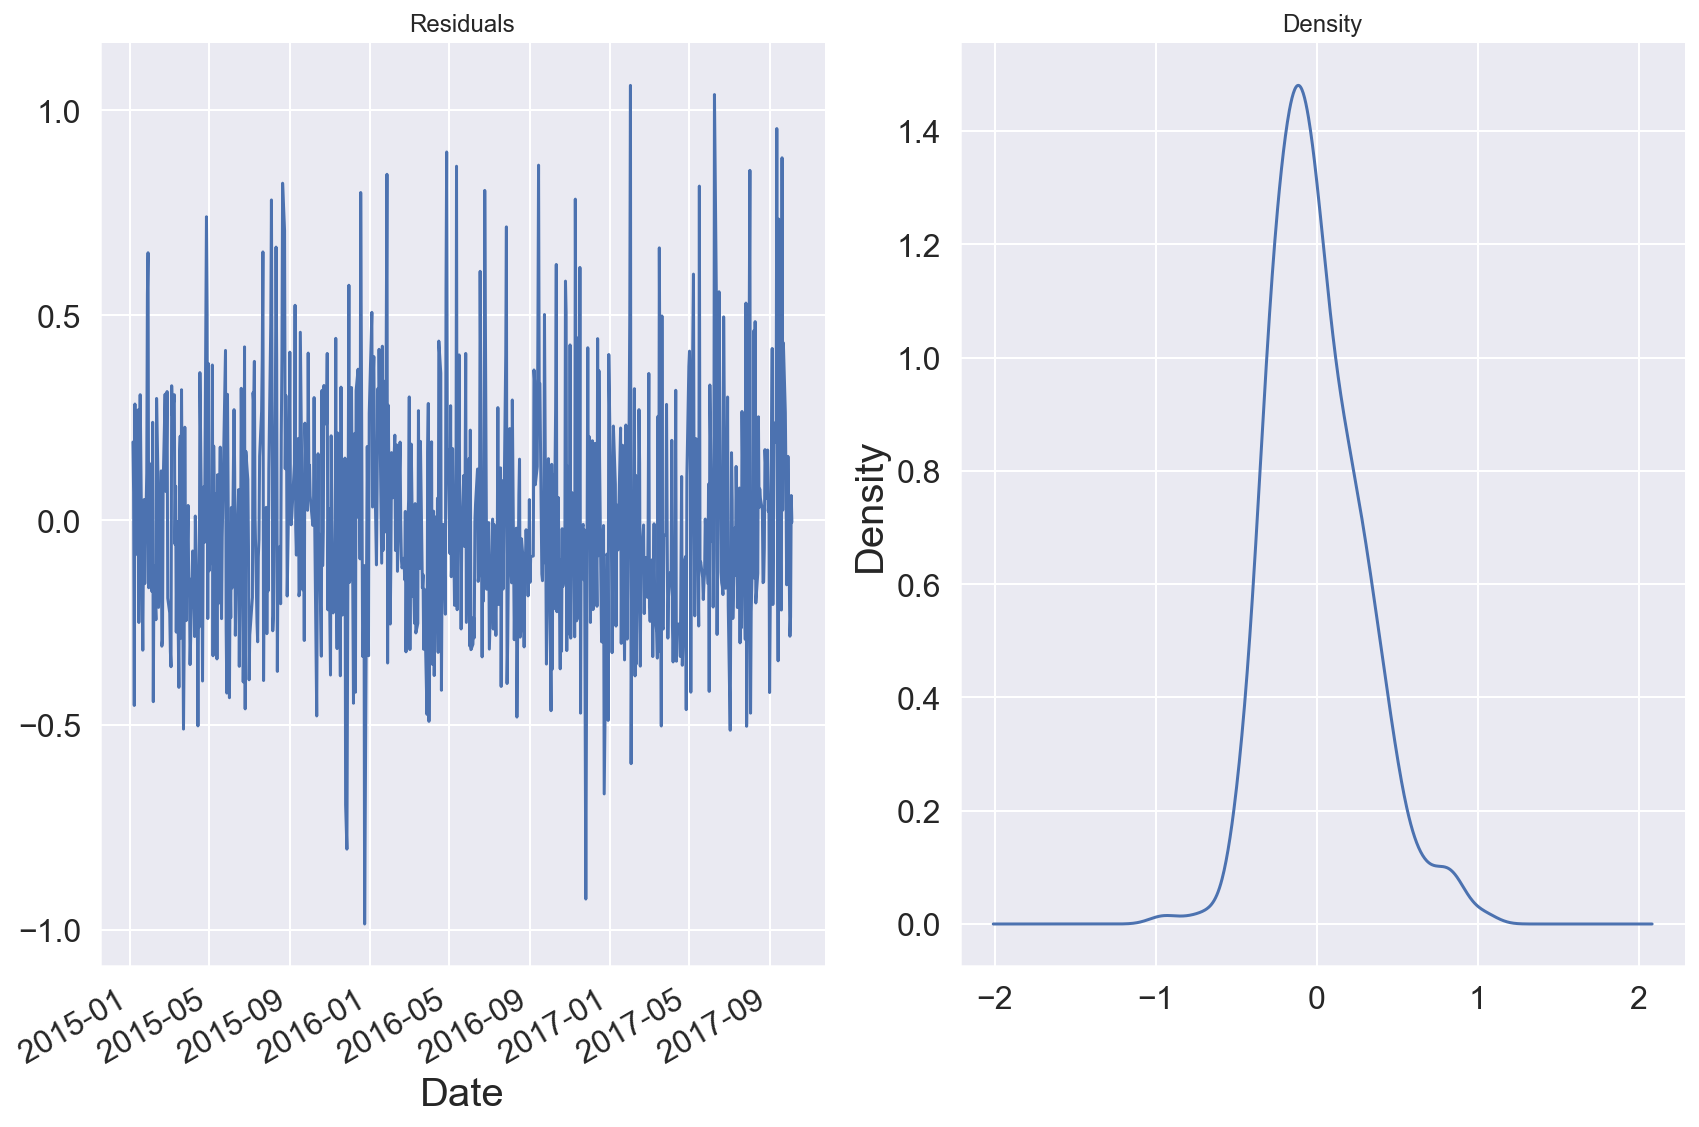

In [96]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2,figsize=(12,8))
residuals.plot(title="Residuals", ax=ax[0],legend=False)
residuals.plot(kind='kde', title='Density', ax=ax[1],legend=False)
plt.tight_layout()
sns.despine()
plt.show()

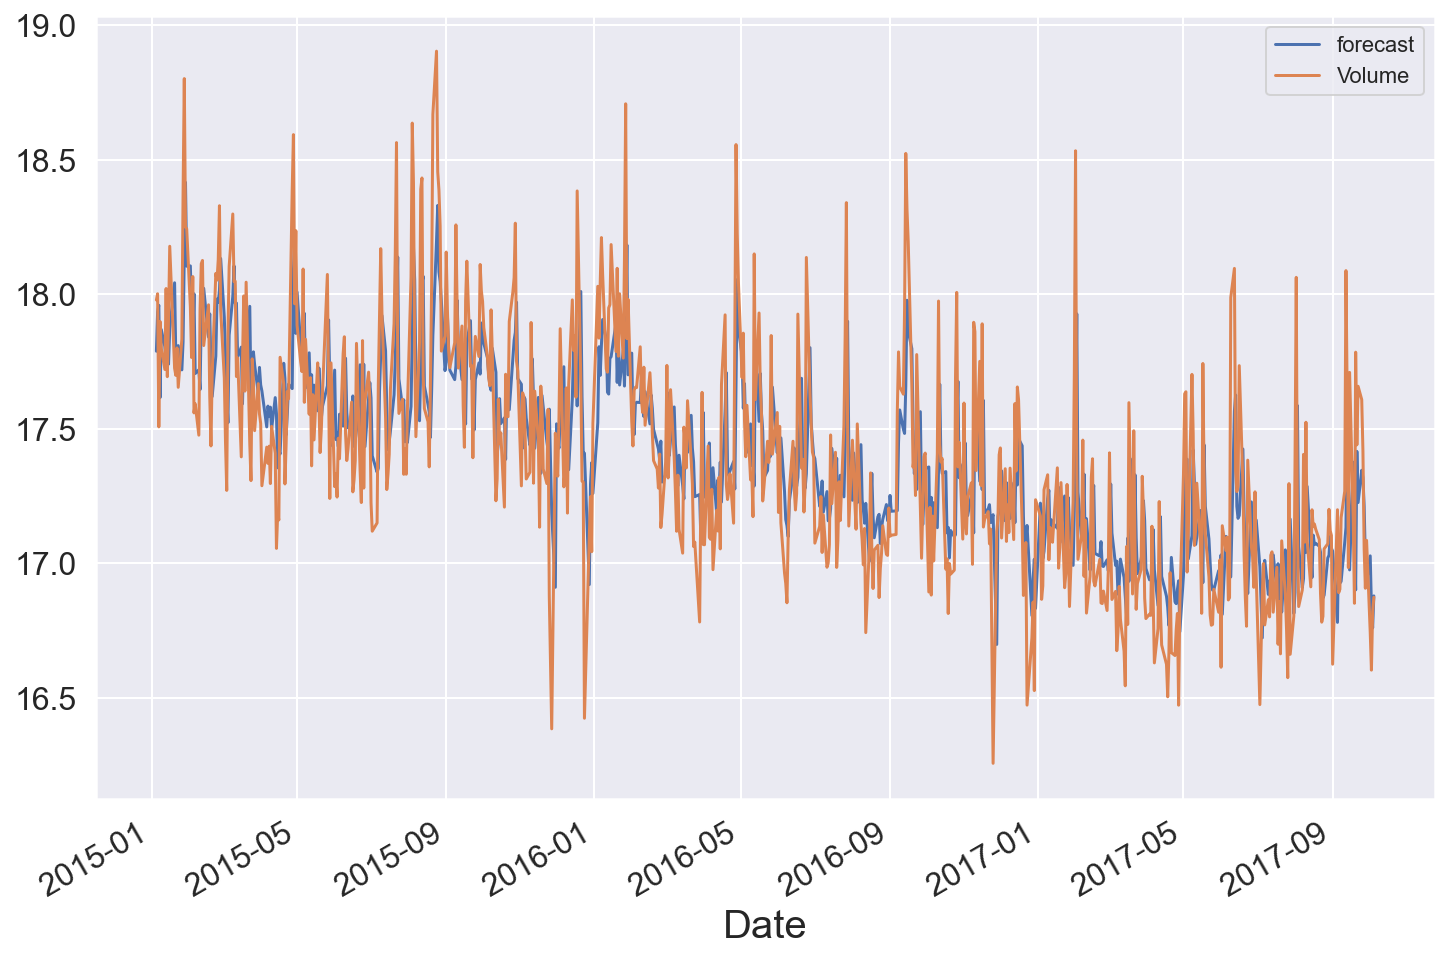

In [97]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
results.plot_predict(dynamic=False,ax=ax)
plt.show()

### Exercise 7

The Roll model for trade prices (in file aapl_daily.csv) discussed in the text can be more specifically stated as,

$$ p^{*}_{t} = p_{t-1} + \epsilon_{t}, \quad \epsilon_{t} \sim N(0,\sigma^{2})$$

$$p_{t} = p^{*}_{t} + c s_{t}, \quad \text{where} s_{t} \in \{+1,-1\}$$

where $p^{*}_{t}$ is the “true” value of a security and $p_{t}$ is the observed trade price, which differ
because of the bid-offer spread: $c$ is the half-spread and $s_{t}$ is the direction of the $t$th trade. $s_{t}$ and $\epsilon$ are serially independent and independent of each other.

1. Calculate the serial correlation of the observed prices $p_{t}$. Construct an MA(1) model with the same autocorrelation structure. Of the two such models, take the
invertible one

2. For the invertible model, construct the associated AR model

3. Use the model to show how to estimate the bid-ask spread and apply the results on the Apple data used in Exercises 5 and 6.


#### Part 1

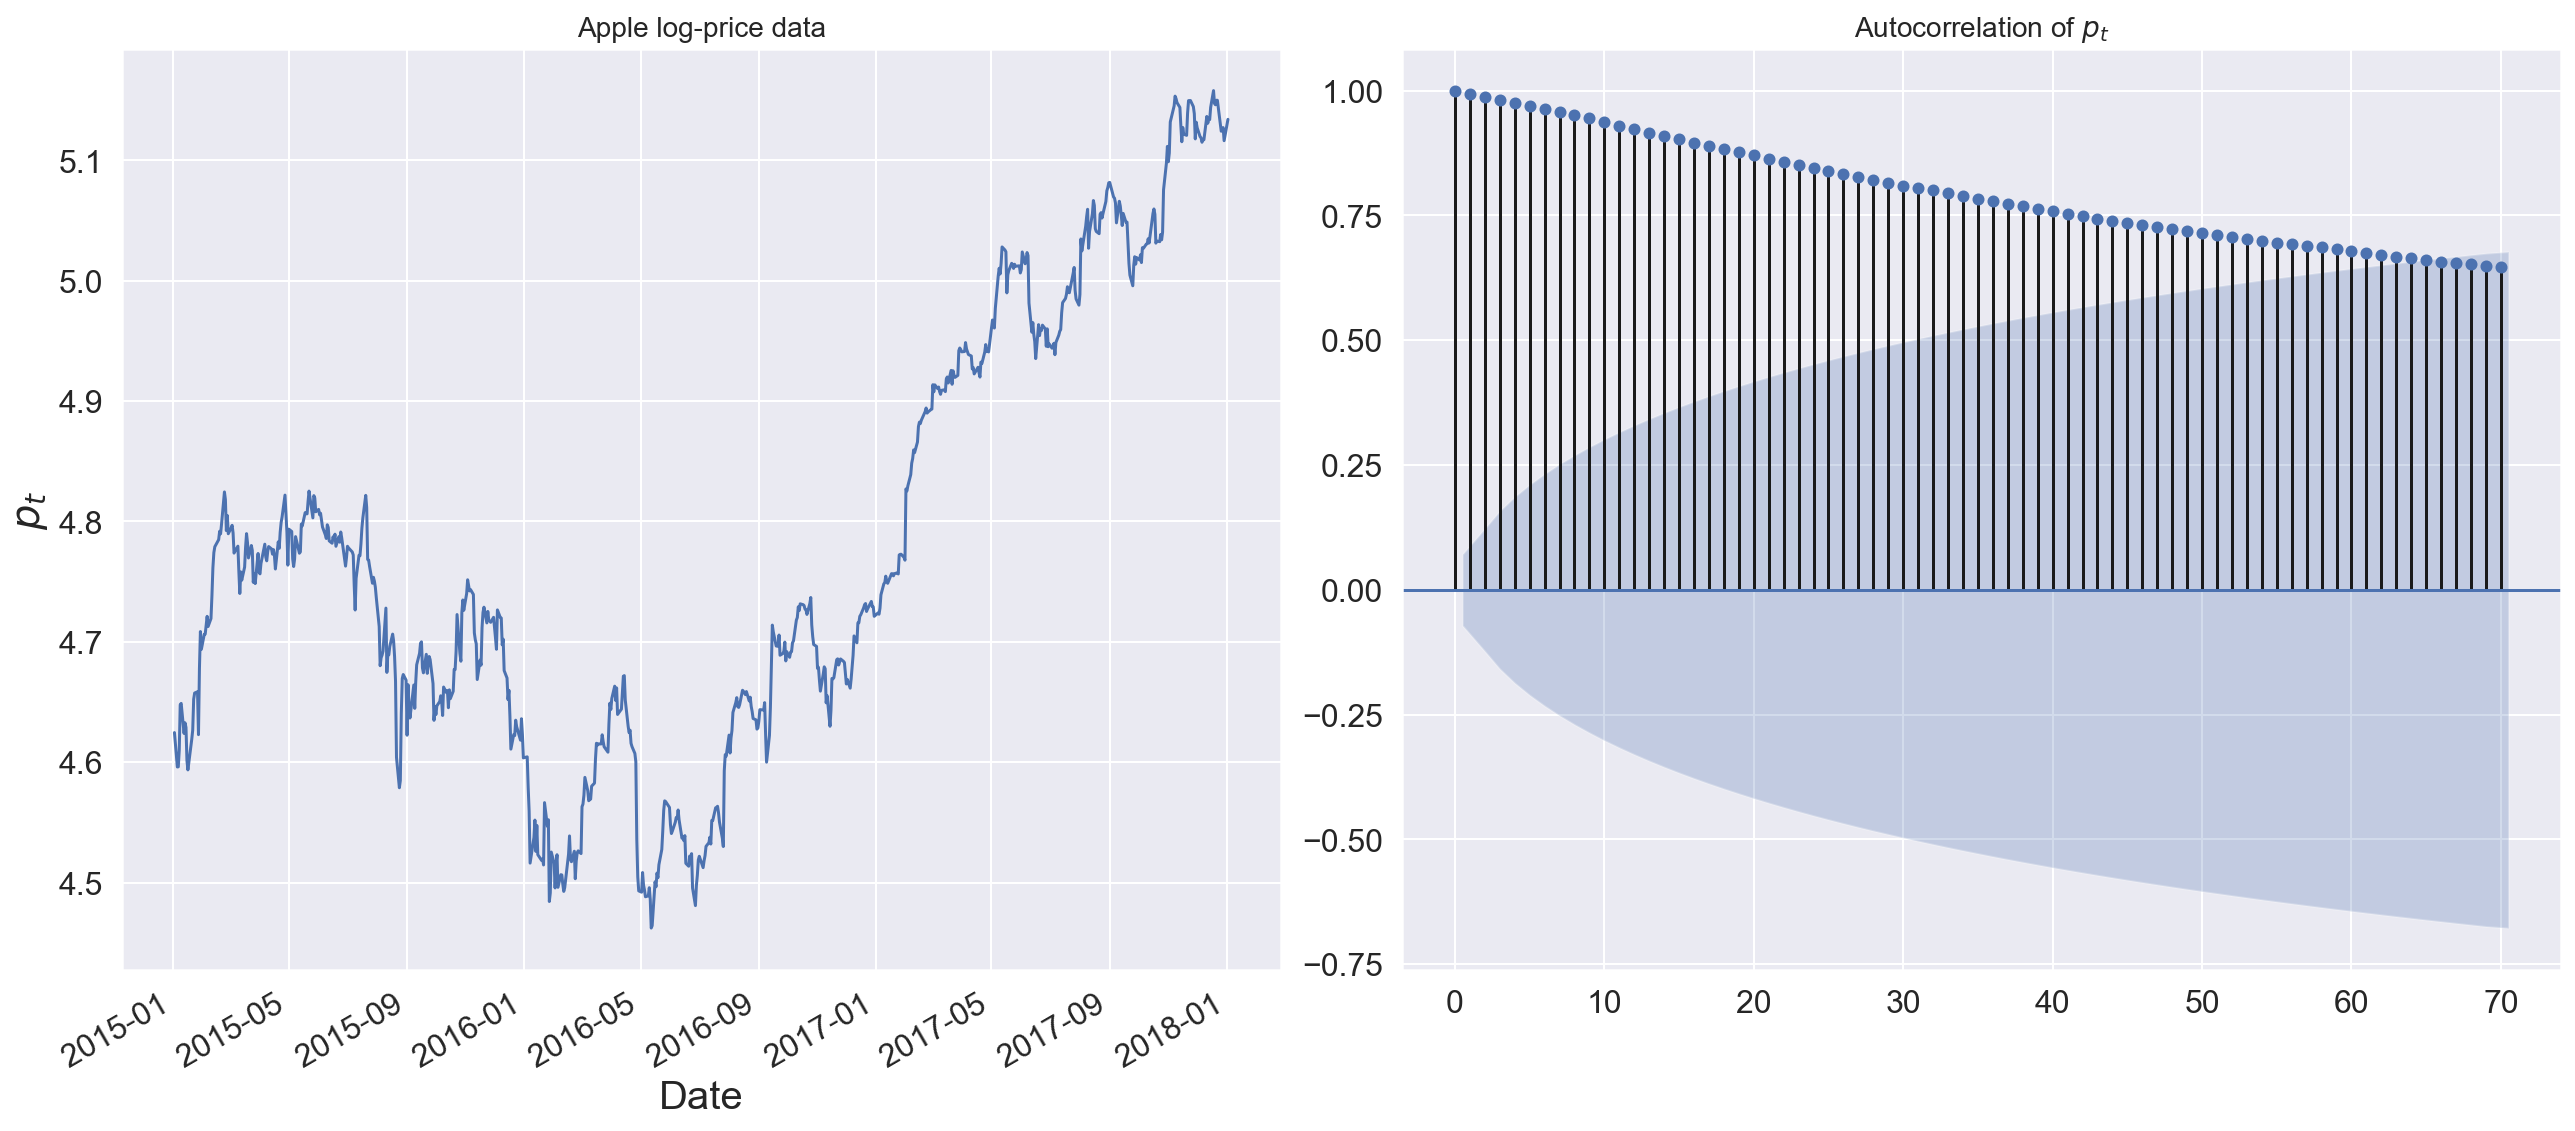

In [116]:
pt = aapl.AdjClose.apply(np.log)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18,8))

_ = pt.plot(ax=ax1)
_ = ax1.set_ylabel('$p_t$')
_ = ax1.set_title('Apple log-price data',fontsize=14)

_ = plot_acf(pt,lags=70,ax=ax2)
_ = ax2.set_title('Autocorrelation of $p_t$',fontsize=14)
plt.tight_layout()
plt.show()

In [120]:
model = ARIMA(pt,(0,0,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               AdjClose   No. Observations:                  756
Model:                     ARMA(0, 1)   Log Likelihood                 712.217
Method:                       css-mle   S.D. of innovations              0.094
Date:                Wed, 28 Oct 2020   AIC                          -1418.435
Time:                        16:33:58   BIC                          -1404.551
Sample:                             0   HQIC                         -1413.087
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7732      0.007    712.745      0.000       4.760       4.786
ma.L1.AdjClose     0.9566      0.008    125.516      0.000       0.942       0.972
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0454           +0.0000j            1.0454            0.5000
-----------------------------------------------------------------------------
"""

The MA(1) model is then: 
$$
p_t = 4.8 + a_t + 0.96a_{t-1}, \quad a_t \sim N(0,0.094^2)
$$ 

#### Part 2

The estimated model is not invertible. (MORE Explanation needed)

#### Part 3

To estimate the bid-ask spread, $c$ observe that:

$$
r_t= p_t - p_{t-1}= (p_t^* + c s_t) - (p_{t-1}^* + c s_{t-1})
= \epsilon_t + c(s_t - s_{t-1})
$$

Note $\mathbb{E}(s_t - s_{t-1})=0; \mathbb{Var}(s_t - s_{t-1})=\mathbb{Var}(s_t) - \mathbb{Var}(s_{t-1}) = \frac{1}{4} + \frac{1}{4} = \frac{1}{2}$


Note $\mathbb{Var}(r_t) = \sigma^2 + c^2/2; \mathbb{Cov}(r_t,r_{t-1}) = \mathbb{Cov}(\epsilon_t + c(s_t - s_{t-1}), \epsilon_{t-1} + c (s_{t-1} - s_{t-2}) )= -c^2/4$

An estimator of $c= \max\{0,2 \sqrt{-\mathbb{Cov}(r_t,r_{t-1})}$. Because $\mathbb{Cov}(r_t,r_{t-1})= 0.00000438>0$, $c \sim 0$.

For another approach to estimate, $c$ using price bar data, see equations (4.54) and (4.55) in the text. 

### Exercise 8

Consider the Level III data for the ticker, “BIOF” for a single day in file biof_levelIII_data.csv. The data description follows similar details as given in Table 2.1. 

This exercise consists of two parts; in the first part, we want to construct the limit order book and the second part we want to study the effect of time aggregation.
1. At any point in time, a limit-order book contains a number of buy and sell orders.
     1. Develop a program that can visually present a limit order book. Present the order book diagram as of 11:00 a.m. for the first ten positions on both sides.
     1. Aggregate demand and supply are represented as step functions of shares accumulated at each price level. The height of step $i$ on the demand side is the price difference between $(i-1)$th and the $'i'$th best price. The height of the first step is the mid-price; the length of a step, $i$, on the demand side is the total number of shares across all orders until $'i'$th price. Similarly, the supply side can be constructed. Normalize a step height by the cumulative length from the first step to tenth step. Present the aggregate curve as of 11:00 a.m.
     1. Using the aggregate graph given in (B), suggest measures for the order book imbalance, which is a key determinant in some entry/exit algorithms in the high-frequency setting.
     
     
1. Aggregate the data to a 2-minute interval, summarizing the number of transactions, volume weighted average price and average duration between transactions. Also, produce the price bars (open, close, low and high and volume) for each interval.
    1. Briefly discuss how you would quantify the loss of information due to aggregation.
    1. Calculate the variance of the returns based on the aggregated VWAP and compare it with the variance based on all observations.
    1. From Exercise 7, it follows that the true price is measured with error, which is due to market friction. The aggregation done above may cancel out the friction and may reflect the true price. Alternatively, one can sample the price every two minutes and compute the variance in the returns. How does this compare to VWAP based descriptives?

In [263]:
biof_data =pd.read_csv('../datasets/biof_levelIII_data.csv')
dt = datetime.date.today()
dt = datetime.datetime.combine(dt, datetime.datetime.min.time())
biof_data.Timestamp = biof_data.Timestamp.apply(lambda x: dt +  datetime.timedelta(milliseconds=x)) # Convert ms from midnight to time
biof_data = biof_data.drop(columns=['Ticker','MPID'])
biof_data.head()

Timestamp      OrderNumber Event  Quantity  Price Exchange
0 2020-11-04 04:00:08.550  281487861614546     B       100  14100        P
1 2020-11-04 06:50:07.246  281487861734668     S       150  32500        P
2 2020-11-04 06:50:07.246  281487861734669     S       100  29500        P
3 2020-11-04 07:23:58.264  281487861751734     S         1  35100        P
4 2020-11-04 07:32:32.470  281487861760592     S       200  28000        P

###### Columns Description

- Timestamp is the time since midnight
- Event: B: Submission of Limit Order (LO) on Buy side; S: Submission of LO on Sell side; T: Full execution of a hidden LO; F: Full execution of a visible LO; E: Partial execution of a LO; D: Full cancellation of a LO; C: Partial cancellation of a LO; 
- Price is the price * 10000
- Exchange: Q-NASDAQ; J-EDGE-A; Z-BATS-Z; K-EDGE-K; P-ARCA; etc.


#### Part 1

Lets write a small program to process the order book in a similar but simplified way as one would in real life. 
We create a order_book structure for each side and processing each event until the specified time. We also keep a time-series of all the tradesfor further processing

We ues a neat little trick to make the structures (dictionaries) easier to deal with wrapping them in an object dictionary that allow to treat keys as attributes.

In [264]:
class objdict(dict):
      
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)

def process_book_data(data,end_time):
    
    order_book = objdict()
    order_book.Buy = objdict()
    order_book.Sell = objdict()
    order_book.Orders = objdict()
    trades = []
    columns = data.columns
    
    book_data = data.loc[data.Timestamp < end_time,:]
    book_data = book_data.to_dict(orient='record')
    
    for event in book_data:
    
        event = objdict(event)

        if event.Event == 'B': # Buy Order
            order_book.Orders[event.OrderNumber] = 'Buy'
            order_book.Buy[event.OrderNumber] = event
        elif event.Event == 'S': #Sell Order
            order_book.Orders[event.OrderNumber] = 'Sell'
            order_book.Sell[event.OrderNumber] = event
        elif event.Event == 'D': # Delete Order
            side = order_book.Orders[event.OrderNumber]
            del order_book.Orders[event.OrderNumber]
            del order_book[side][event.OrderNumber]
        elif event.Event == 'T': #Dark Execution
            qty = int(event.Quantity)
            price = float(event.Price)/10000.0
            trade = objdict({
                'Timestamp': event.Timestamp,
                'Price': price,
                'Quantity': qty,
                'IsDark': True
            })

            trades.append(trade)

        elif event.Event == 'F': #Lit Full Execution
            side = order_book.Orders[event.OrderNumber]
            order = order_book[side][event.OrderNumber]
            qty = int(order.Quantity)
            price = float(order.Price)/10000.0

            trade = objdict({
                'Timestamp': event.Timestamp,
                'Price': price,
                'Quantity': qty,
                'IsDark': False
            })

            trades.append(trade)

            del order_book.Orders[event.OrderNumber]
            del order_book[side][event.OrderNumber]
        elif event.Event == 'E': #Lit Full Execution
            side = order_book.Orders[event.OrderNumber]
            order = order_book[side][event.OrderNumber]
            qty = int(event.Quantity)
            price = float(order.Price)/10000.0

            trade = objdict({
                'Timestamp': event.Timestamp,
                'Price': price,
                'Quantity': qty,
                'IsDark': False
            })

            trades.append(trade)

            order.Quantity -=qty
            if order.Quantity <= 0:
                del order_book.Orders[event.OrderNumber]
                del order_book[side][event.OrderNumber]
            else:
                order_book[side][event.OrderNumber] = order
        else:
            print(event)
            
    trades  = pd.DataFrame(trades)
    trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], format='%H:%M:%S.%f0')
    #trades = trades.set_index('Timestamp')
    #trades.index = trades.index.time
    return (order_book,trades)

In [266]:
order_book,trades = process_book_data(biof_data, datetime.datetime.combine(dt, datetime.time(11,0,0)))

{'Timestamp': Timestamp('2020-11-04 09:30:00.458000'), 'OrderNumber': 72158, 'Event': 'X', 'Quantity': 3083, 'Price': 17300, 'Exchange': 'Q'}


Now let's create a functions that extracts the top n levels for each side

In [267]:
def get_top_levels(order_book, n_levels):
    
    buys = pd.DataFrame(order_book['Buy'].values())
    buys['Price'] = buys.Price.astype(float)/10000
    buys = buys.set_index('Price').sort_index(ascending=False)
    buys = buys.iloc[:n_levels].set_index('Timestamp',append=True)
    
    sells = pd.DataFrame(order_book['Sell'].values())
    sells = sells.set_index('Price').sort_index()
    sells = sells.iloc[:n_levels].set_index('Timestamp',append=True)
    
    return(buys, sells)

In [268]:
buys,sells = get_top_levels(order_book,10)


In [269]:
buys

OrderNumber Event  Quantity Exchange
Price Timestamp                                                           
1.72  2020-11-04 10:57:59.837            75741752     B       300        Q
1.70  2020-11-04 10:41:52.595     281487864896607     B      2000        P
      2020-11-04 10:47:42.002            13158595     B      3000        K
      2020-11-04 10:48:53.372             5321078     B      1800        K
      2020-11-04 10:40:41.610  281747809852433613     B       300        Z
      2020-11-04 10:53:53.629             5321937     B      3000        K
1.69  2020-11-04 10:44:41.681     281487864979136     B       100        P
      2020-11-04 10:55:03.626            74348170     B       200        Q
      2020-11-04 10:55:03.626     281487865266047     B       200        P
      2020-11-04 10:41:18.721  281747809852444726     B       100        Z

In [270]:
sells

OrderNumber Event  Quantity Exchange
Price Timestamp                                                           
17500 2020-11-04 10:59:45.365     281487865378210     S       500        P
      2020-11-04 10:59:43.606            13174115     S      5337        K
      2020-11-04 10:57:41.348            18366833     S      4000        K
      2020-11-04 10:55:31.803  281747809852760442     S       100        Z
      2020-11-04 10:55:30.614  281747809852760130     S       100        Z
      2020-11-04 10:55:02.511            74341311     S       800        Q
      2020-11-04 10:54:10.777     281487865245375     S       500        P
      2020-11-04 10:42:12.938  281747809852464542     S       100        Z
      2020-11-04 10:32:58.687  281747809852255830     S       100        Z
      2020-11-04 10:14:04.985            14300342     S      7339        K

In [271]:
b = buys.groupby('Price')[['Quantity']].sum().sort_index(ascending=False).reset_index()

#### Part 2

In [308]:
def aggregate_trades_1(df):
    num_trades = df.Quantity.shape[0]
    vwap = (df.Quantity*df.Price).sum()/df.Quantity.sum()
    avg_duration = df.Timestamp.diff().mean().seconds
    return pd.Series({'N':num_trades,'VWAP':vwap,'AvgDuration':avg_duration})

def aggregate_trades_2(df):
    volume = df.Quantity.sum()
    if volume == 0:
        p_open = np.NaN
        p_close = np.NaN
        p_hi = np.NaN
        p_lo = np.NaN
    else:
        p_open = df.Price.iloc[0]
        p_close = df.Price.iloc[-1]
        p_hi = df.Price.max()
        p_lo = df.Price.min()
    
    return pd.Series({'Open':p_open,'Close':p_close,'High':p_hi,'Low':p_lo,'Volume':volume})

In [314]:
agg_1 = trades.groupby(pd.Grouper(key='Timestamp', freq='2T')).apply(aggregate_trades_1)
agg_1

/Users/nehrend/opt/miniconda3/envs/atqs/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


N      VWAP  AvgDuration
Timestamp                                       
2020-11-04 09:30:00   5.0  1.712000          0.0
2020-11-04 09:32:00   2.0  1.700000          0.0
2020-11-04 09:34:00   2.0  1.730000          0.0
2020-11-04 09:36:00   0.0       NaN          NaN
2020-11-04 09:38:00  46.0  1.739050          1.0
2020-11-04 09:40:00  52.0  1.789566          1.0
2020-11-04 09:42:00  33.0  1.806284          3.0
2020-11-04 09:44:00  15.0  1.801957          8.0
2020-11-04 09:46:00   5.0  1.787692         20.0
2020-11-04 09:48:00   5.0  1.771515          6.0
2020-11-04 09:50:00   1.0  1.770000          NaN
2020-11-04 09:52:00   1.0  1.780000          NaN
2020-11-04 09:54:00   0.0       NaN          NaN
2020-11-04 09:56:00   0.0       NaN          NaN
2020-11-04 09:58:00   3.0  1.750000          0.0
2020-11-04 10:00:00   1.0  1.740000          NaN
2020-11-04 10:02:00   0.0       NaN          NaN
2020-11-04 10:04:00   0.0       NaN          NaN
2020-11-04 10:06:00   0.0       NaN          NaN
2020-11-04 10:08:00   0.0       NaN          NaN
2020-11-04 10:10:00   5.0  1.732647          6.0
2020-11-04 10:12:00  10.0  1.723750          2.0
2020-11-04 10:14:00   0.0       NaN          NaN
2020-11-04 10:16:00   5.0  1.721000          0.0
2020-11-04 10:18:00   0.0       NaN          NaN
2020-11-04 10:20:00  12.0  1.720909          0.0
2020-11-04 10:22:00   6.0  1.730000          2.0
2020-11-04 10:24:00   2.0  1.740000          0.0
2020-11-04 10:26:00  10.0  1.727934          3.0
2020-11-04 10:28:00   0.0       NaN          NaN
2020-11-04 10:30:00   0.0       NaN          NaN
2020-11-04 10:32:00   0.0       NaN          NaN
2020-11-04 10:34:00   0.0       NaN          NaN
2020-11-04 10:36:00  10.0  1.698261          8.0
2020-11-04 10:38:00   1.0  1.700000          NaN
2020-11-04 10:40:00   0.0       NaN          NaN
2020-11-04 10:42:00   0.0       NaN          NaN
2020-11-04 10:44:00   0.0       NaN          NaN
2020-11-04 10:46:00   0.0       NaN          NaN
2020-11-04 10:48:00   0.0       NaN          NaN
2020-11-04 10:50:00   1.0  1.720000          NaN
2020-11-04 10:52:00   0.0       NaN          NaN
2020-11-04 10:54:00   9.0  1.731272          7.0

In [315]:
agg_2 = trades.groupby(pd.Grouper(key='Timestamp', freq='2T')).apply(aggregate_trades_2)
agg_2

Open  Close  High   Low   Volume
Timestamp                                            
2020-11-04 09:30:00  1.71   1.72  1.72  1.71   1000.0
2020-11-04 09:32:00  1.70   1.70  1.70  1.70   1700.0
2020-11-04 09:34:00  1.73   1.73  1.73  1.73   1000.0
2020-11-04 09:36:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 09:38:00  1.73   1.74  1.75  1.73  32214.0
2020-11-04 09:40:00  1.75   1.84  1.84  1.75  40070.0
2020-11-04 09:42:00  1.81   1.80  1.84  1.79  21800.0
2020-11-04 09:44:00  1.82   1.80  1.82  1.79   9200.0
2020-11-04 09:46:00  1.80   1.78  1.80  1.78   1300.0
2020-11-04 09:48:00  1.78   1.77  1.78  1.77   3300.0
2020-11-04 09:50:00  1.77   1.77  1.77  1.77    500.0
2020-11-04 09:52:00  1.78   1.78  1.78  1.78    100.0
2020-11-04 09:54:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 09:56:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 09:58:00  1.76   1.74  1.76  1.74    300.0
2020-11-04 10:00:00  1.74   1.74  1.74  1.74    500.0
2020-11-04 10:02:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:04:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:06:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:08:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:10:00  1.74   1.73  1.74  1.73   3400.0
2020-11-04 10:12:00  1.73   1.75  1.75  1.72   4000.0
2020-11-04 10:14:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:16:00  1.73   1.71  1.73  1.71   2000.0
2020-11-04 10:18:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:20:00  1.71   1.73  1.73  1.71   2200.0
2020-11-04 10:22:00  1.73   1.73  1.73  1.73   6900.0
2020-11-04 10:24:00  1.74   1.74  1.74  1.74    200.0
2020-11-04 10:26:00  1.73   1.72  1.73  1.72   6050.0
2020-11-04 10:28:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:30:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:32:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:34:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:36:00  1.70   1.70  1.71  1.69   2300.0
2020-11-04 10:38:00  1.70   1.70  1.70  1.70    100.0
2020-11-04 10:40:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:42:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:44:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:46:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:48:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:50:00  1.72   1.72  1.72  1.72    158.0
2020-11-04 10:52:00   NaN    NaN   NaN   NaN      0.0
2020-11-04 10:54:00  1.72   1.74  1.74  1.72   1242.0

In [319]:
v1 = agg_1.VWAP.dropna().pct_change().var()
v2= trades.Price.pct_change().var()
print(f'Agg Variance: {v1} vs. ')